<a href="https://colab.research.google.com/github/pintorem/ML-Ensemble-Transferable-Attack/blob/master/MLSec_Pintore_Monni_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ML Security Project

The repository is organized as follows: first, we do the training and testing of a simple I-FGSM on a 2D toy case. After that, we define the helper functions and the attacks for the model ensemble, so that we can perform the real attack on the 3-model ensemble. In the end, the adversarial examples that were created are transferred to the other 7 models.

In [ ]:
!pip install git+https://github.com/RobustBench/robustbench.git

  Cloning https://github.com/RobustBench/robustbench.git to /tmp/pip-req-build-70ta3fzc
  Running command git clone --filter=blob:none --quiet https://github.com/RobustBench/robustbench.git /tmp/pip-req-build-70ta3fzc
  Resolved https://github.com/RobustBench/robustbench.git to commit 78fcc9e48a07a861268f295a777b975f25155964
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/fra31/auto-attack.git (to revision a39220048b3c9f2cca9a4d3a54604793c68eca7e) to /tmp/pip-install-d5qktdkm/autoattack_208bc3b90c2c4eb79e9164c4e3c46db7
  Running command git clone --filter=blob:none --quiet https://github.com/fra31/auto-attack.git /tmp/pip-install-d5qktdkm/autoattack_208bc3b90c2c4eb79e9164c4e3c46db7
  Running command git rev-parse -q --verify 'sha^a39220048b3c9f2cca9a4d3a54604793c68eca7e'
  Running command git fetch -q https://github.com/fra31/auto-attack.git a39220048b3c9f2cca9a4d3a54604793c68eca7e
  Resolved https://github.com/fra31/auto-attack.git to commit a39220048b3c9f2cca9a4

#FGSM 2D

Epoch [100/1000], Loss: 0.6517
Epoch [200/1000], Loss: 0.3307
Epoch [300/1000], Loss: 0.1603
Epoch [400/1000], Loss: 0.0857
Epoch [500/1000], Loss: 0.0515
Epoch [600/1000], Loss: 0.0339
Epoch [700/1000], Loss: 0.0240
Epoch [800/1000], Loss: 0.0178
Epoch [900/1000], Loss: 0.0137
Epoch [1000/1000], Loss: 0.0109
confidence before tensor([[-1.9679, -1.7418,  3.9322]], grad_fn=<AddmmBackward0>)
confidence after tensor([[0.6560, 1.8931, 0.2454]], grad_fn=<AddmmBackward0>)
confidence before tensor([[-1.4422, -2.2733,  3.9145]], grad_fn=<AddmmBackward0>)
confidence after tensor([[1.1816, 1.3616, 0.2277]], grad_fn=<AddmmBackward0>)
confidence before tensor([[-1.3473, -1.4849,  3.4052]], grad_fn=<AddmmBackward0>)
confidence after tensor([[0.6206, 1.2412, 0.6401]], grad_fn=<AddmmBackward0>)


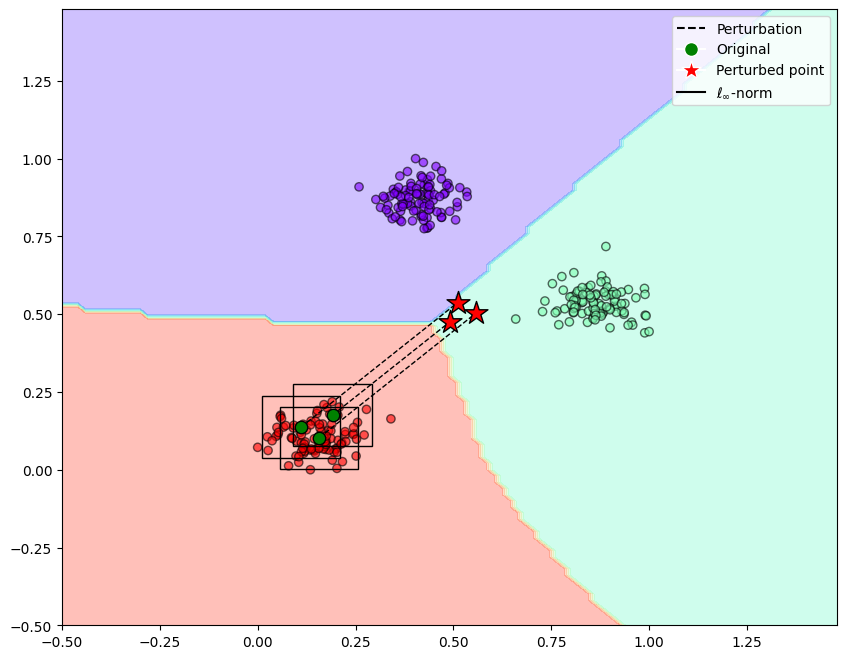

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

class Net(nn.Module):
    def __init__(self, n_features, n_outputs):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_features, 50)
        self.fc2 = nn.Linear(50, n_outputs)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def margin_loss(logits, target):
    logits = logits.squeeze()  # remove batch size (in this small example is 1)
    true_class_logit = logits[target.item()]

    masked_logits = logits.detach().clone()
    masked_logits[target.item()] = -torch.inf

    max_other_logit = masked_logits.max()

    return max_other_logit - true_class_logit

def train(model, X_train, y_train, optimizer, criterion, epochs=10):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        logits = model(X_train)
        loss = criterion(logits, y_train)
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

def fgsm_attack(model, x, y, loss_fct, epsilon=0.1):
    x.requires_grad = True
    logits = model(x)
    loss = loss_fct(logits, y)
    model.zero_grad()
    loss.backward()
    perturbation = epsilon * x.grad.data.sign()
    x_adv = x + perturbation
    return x_adv.detach()

def pgd(model, x, y_true, loss_fct, epsilon=0.1, max_iter=20):
    x_start = x.detach().clone()
    print('confidence before', model(x_start))
    for _ in range(max_iter):
        with torch.no_grad():
            if model(x_start).argmax() != y_true:
                break
        x_start = fgsm_attack(model, x_start, y_true, loss_fct, epsilon)

    print('confidence after', model(x_start))

    return x_start.detach()

def main_fgsm_2d():
    ################### Train a simple fully connected neural network
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    seed = 42
    X, y = make_blobs(n_samples=300, centers=3, n_features=2, random_state=seed)
    X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

    X = torch.tensor(X, dtype=torch.float32).to(device)
    y = torch.tensor(y, dtype=torch.long).to(device)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

    model = Net(X_train.shape[1], len(torch.unique(y))).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    train(model, X_train, y_train, optimizer, criterion, epochs=1000)

    ################### Compute adv examples against the FC neural network
    epsilon = 0.1
    indices = np.random.choice(len(X_test), 3, replace=False)
    adv_examples = []

    for i in indices:
        x = X_test[i].unsqueeze(0)
        y_true = y_test[i].unsqueeze(0)
        x_adv = pgd(model, x, y_true, margin_loss, epsilon) # try also fgsm!
        adv_examples.append((x.squeeze().cpu().detach().numpy(), x_adv.squeeze().cpu().numpy()))

    ################### Plot decision regions and adversarial examples
    plt.figure(figsize=(10, 8))
    h = 0.02
    xx, yy = np.meshgrid(np.arange(-0.5, 1.5, h), np.arange(-0.5, 1.5, h))
    grid_tensor = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32).to(device)
    with torch.no_grad():
        Z = model(grid_tensor).argmax(dim=1).cpu().numpy()
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.rainbow)

    plt.scatter(X[:, 0].cpu(), X[:, 1].cpu(), c=y.cpu(), cmap=plt.cm.rainbow,
              edgecolors='k', alpha=0.6, label='Dataset')

    for orig, adv in adv_examples:
        plt.plot([orig[0], adv[0]], [orig[1], adv[1]], 'k--', lw=1)
        plt.scatter(orig[0], orig[1], c='green', s=80, edgecolors='k', zorder=3)
        plt.scatter(adv[0], adv[1], c='red', s=300, edgecolors='k', marker='*', zorder=3)
        plt.gca().add_patch(plt.Rectangle(
            (orig[0]-epsilon, orig[1]-epsilon), 2*epsilon, 2*epsilon,
            linewidth=1, edgecolor='black', facecolor='none', linestyle='-'
        ))

    legend_elements = [
        plt.Line2D([0], [0], color='k', linestyle='--', label='Perturbation'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Original'),
        plt.Line2D([0], [0], marker='*', color='w', markerfacecolor='red', markersize=15, label='Perturbed point'),
        plt.Line2D([0],[0], color='black', linestyle='-', label=r"$\ell_{\infty}$-norm")
    ]

    plt.legend(handles=legend_elements, loc='best')
    plt.show()

main_fgsm_2d()

In [ ]:
!pip install git+https://github.com/RobustBench/robustbench.git

  Cloning https://github.com/RobustBench/robustbench.git to /tmp/pip-req-build-ze6oa6vr
  Running command git clone --filter=blob:none --quiet https://github.com/RobustBench/robustbench.git /tmp/pip-req-build-ze6oa6vr
  Resolved https://github.com/RobustBench/robustbench.git to commit 9cd54ee2c0197f024124f836e7b10c883b143adf
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/fra31/auto-attack.git (to revision a39220048b3c9f2cca9a4d3a54604793c68eca7e) to /tmp/pip-install-vrnilnfb/autoattack_ed86916367d94eb599266ee889d00009
  Running command git clone --filter=blob:none --quiet https://github.com/fra31/auto-attack.git /tmp/pip-install-vrnilnfb/autoattack_ed86916367d94eb599266ee889d00009
  Running command git rev-parse -q --verify 'sha^a39220048b3c9f2cca9a4d3a54604793c68eca7e'
  Running command git fetch -q https://github.com/fra31/auto-attack.git a39220048b3c9f2cca9a4d3a54604793c68eca7e
  Resolved https://github.com/fra31/auto-attack.git to commit a39220048b3c9f2cca9a4

#Optimize the attack against 3 models simultaneously

In this section, are implemented 3 different attacks against the ensemble model. They are:
- fgsm_ensemble with averaged logits margin loss
- pgd_ensemble with sum of margin losses
- mi_fgsm_ensemble with cross entropy loss

In [ ]:
# Helper functions

def ensemble_predict(models, x):
    """
      Compute the avareged logits for each model.

      Use this function only for inference, avoid for computing
      adversarial examples because uses torch.no_grad()
    """
    with torch.no_grad():
       logits = [model(x) for model in models]
       avg_logits = torch.mean(torch.stack(logits), dim=0)
    return avg_logits.argmax().item(), avg_logits

def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def margin_loss(logits, target):
    logits = logits.squeeze()
    true_class_logit = logits[target.item()]
    masked_logits = logits.detach().clone()
    masked_logits[target.item()] = -torch.inf
    max_other_logit = masked_logits.max()
    return max_other_logit - true_class_logit

def plot_original_adv_images(x, x_adv, y_pred, y_pred_adv):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    axes[0].imshow(np.transpose(x.squeeze().cpu().numpy(), (1, 2, 0)))
    axes[0].set_title(f"Original: {CIFAR10_CLASSES[y_pred]}")
    axes[0].axis("off")
    rect1 = patches.Rectangle((0, 0), 1, 1, linewidth=5, edgecolor="black", facecolor='none', transform=axes[0].transAxes)
    axes[0].add_patch(rect1)

    axes[1].imshow(np.transpose(x_adv.squeeze().cpu().detach().numpy(), (1, 2, 0)))
    axes[1].set_title(f"Adv: {CIFAR10_CLASSES[y_pred_adv]}")
    axes[1].axis("off")
    rect2 = patches.Rectangle((0, 0), 1, 1, linewidth=5, edgecolor="black", facecolor='none', transform=axes[1].transAxes)
    axes[1].add_patch(rect2)

    perturbation = np.abs((x_adv - x).squeeze().cpu().detach().numpy())
    perturbation /= perturbation.max()
    axes[2].imshow(np.transpose(perturbation, (1, 2, 0)))
    axes[2].set_title("Perturbation")
    axes[2].axis("off")
    rect3 = patches.Rectangle((0, 0), 1, 1, linewidth=5, edgecolor="black", facecolor='none', transform=axes[2].transAxes)
    axes[2].add_patch(rect3)

    plt.show()

Method A - FGSM Ensemble attack

In [ ]:
def fgsm_ensemble(models, x, y_true, epsilon=8/255):
    '''
      A standard FGSM, the only difference is that the the loss is computed
      starting from the average logits of the ensemble.
    '''
    x_adv = x.clone().detach()
    x_adv.requires_grad = True

    logits = torch.mean(torch.stack([model(x_adv) for model in models]), dim=0)
    loss = margin_loss(logits, y_true)

    grad = torch.autograd.grad(loss, x_adv)[0]
    x_adv = x_adv.detach() + epsilon * torch.sign(grad.detach())
    x_adv = torch.clamp(x_adv, min=0, max=1).detach()

    y_pred, _ = ensemble_predict(models, x_adv)

    return x_adv, y_pred

Method B - I-FGSM Ensemble attack

In [ ]:
def pgd_ensemble(models, x, y_true, epsilon=8/255, eta=3/255, max_iter=20):
    """
      A standard I-FGSM/PGD implementation, the only difference is that the
      loss is computed using sum of the margin losses.
    """
    x_adv = x.clone().detach()
    x_orig = x.clone().detach()
    y_pred = y_true

    for i in range(max_iter):
        x_adv.requires_grad = True
        losses = []

        # Custom loss: sum of margin losses
        for model in models:
            logits = model(x_adv)
            loss = margin_loss(logits, y_true)
            losses.append(loss)
        total_loss = sum(losses)

        if DEBUG:
          print(f"Iteration {i}: Total Loss = {total_loss.item():.4f}")

        for model in models:
            model.zero_grad()
        total_loss.backward()

        # FGSM update
        x_adv = x_adv + eta * x_adv.grad.data.sign()

        # Projection l-inf norm + [0,1] constraint
        delta = torch.clamp(x_adv - x_orig, min=-epsilon, max=epsilon)
        x_adv = torch.clamp(x_orig + delta, min=0, max=1).detach()

        # Early stopping when during the optimization, the ensemble have already
        # misclassified the adversarial example
        y_pred, _ = ensemble_predict(models, x_adv)
        if y_pred != y_true:
            print(f'Early stopping at iter {i}: ensemble misclassification!')
            break

    return x_adv, y_pred

Method C - MI-FGSM Ensemble attack

In [ ]:
def mi_fgsm_ensemble(models, x, y_true, epsilon=8/255, eta=3/255, max_iter=10, mu=0.9, weights=None):
    """
      MI-FGSM: uses momentum and a custom fused logit loss
    """
    x_adv = x.clone().detach()
    momentum = torch.zeros_like(x_adv)

    # Optional: pass ensemble weights
    if weights is None:
        weights = [1.0 / len(models)] * len(models)
    else:
        weights = [w / sum(weights) for w in weights]

    for i in range(max_iter):
        x_adv.requires_grad = True

        # Custom fused logits loss (check the paper)
        fused_logits = sum(weight * model(x_adv) for model, weight in zip(models, weights))
        loss = F.cross_entropy(fused_logits, y_true)

        for model in models:
            model.zero_grad()
        loss.backward()

        # Normalize the gradient
        grad = x_adv.grad.data
        grad_norm = torch.sum(torch.abs(grad), dim=(1, 2, 3), keepdim=True) + 1e-12
        normalized_grad = grad / grad_norm

        # MI-FGSM update
        momentum = mu*momentum + normalized_grad
        x_adv = x_adv + eta*torch.sign(momentum)

        # Projection l-inf norm + [0,1] constraint
        delta = torch.clamp(x_adv - x, min=-epsilon, max=epsilon)
        x_adv = torch.clamp(x + delta, min=0, max=1).detach()

        # Early stopping when during the optimization, the ensemble have already
        # misclassified the adversarial example
        y_pred, _ = ensemble_predict(models, x_adv)
        if y_pred != y_true:
            print(f'Early stopping at iter {i}: ensemble misclassification!')
            break

    return x_adv, y_pred

In the next block, the defined attacks will be optimised against the model ensamble. The results will be saved in a dictionary called res_adv_images

Sample 0/100


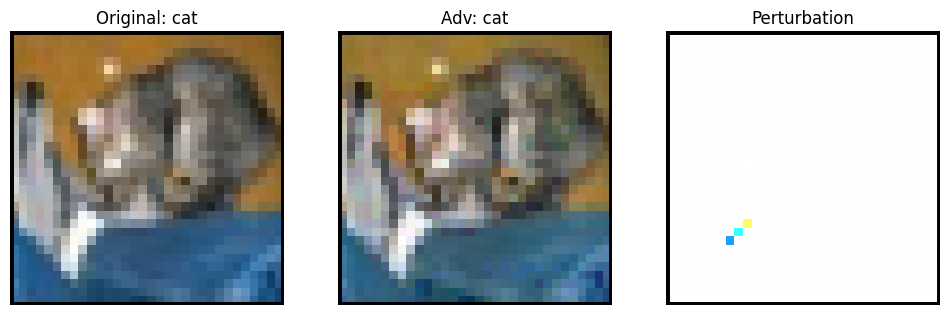

Sample 1/100


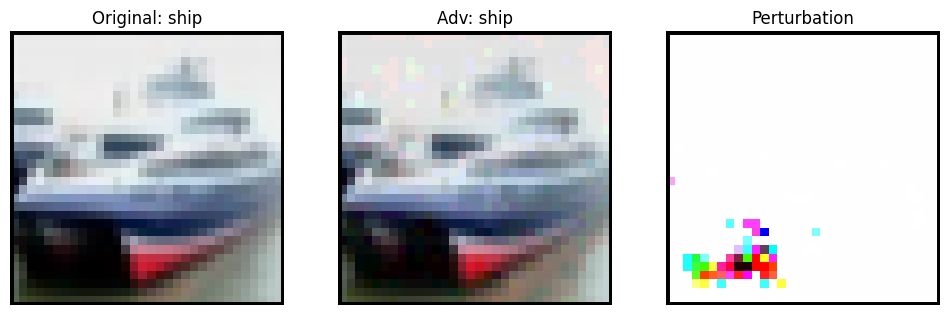

Sample 2/100


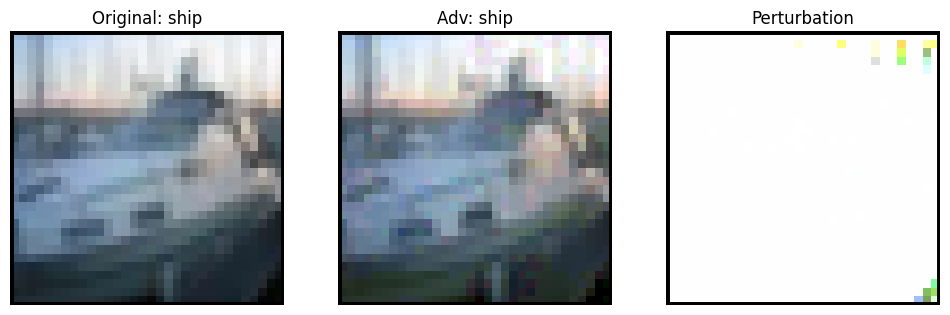

Sample 3/100


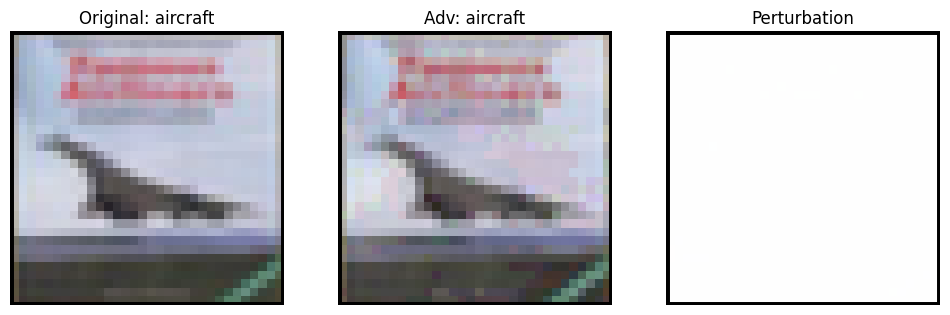

Sample 4/100


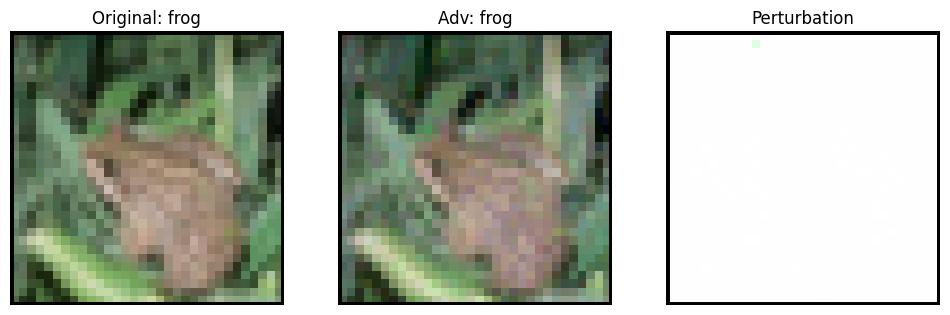

Sample 5/100


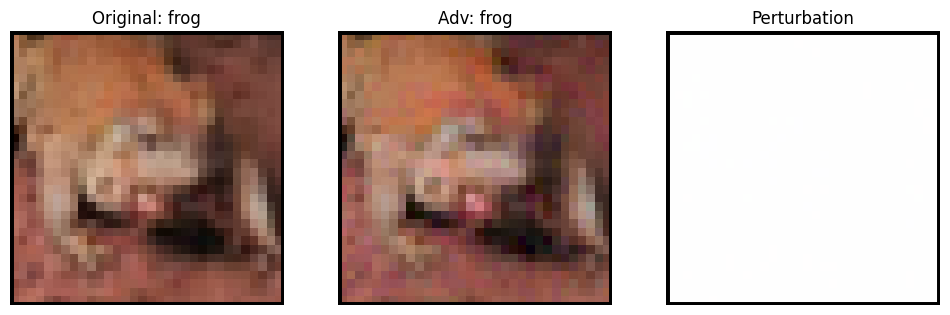

Sample 6/100


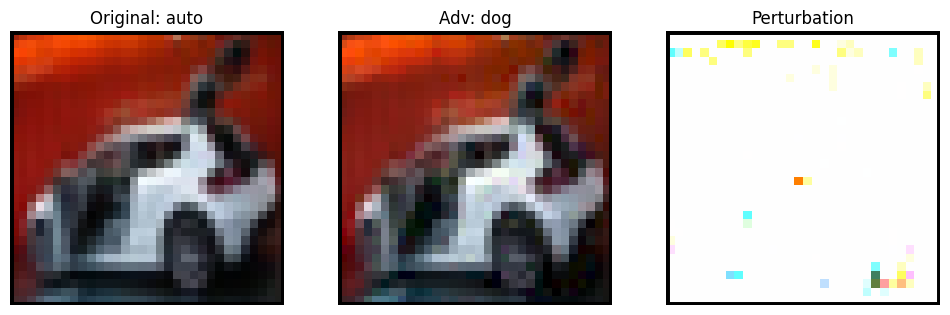

Sample 7/100


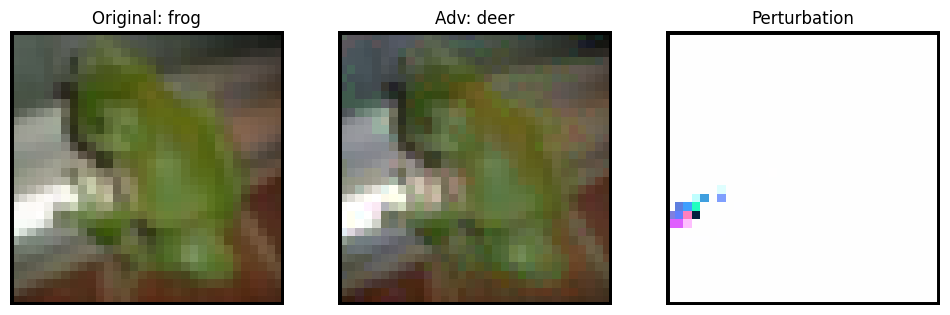

Sample 8/100


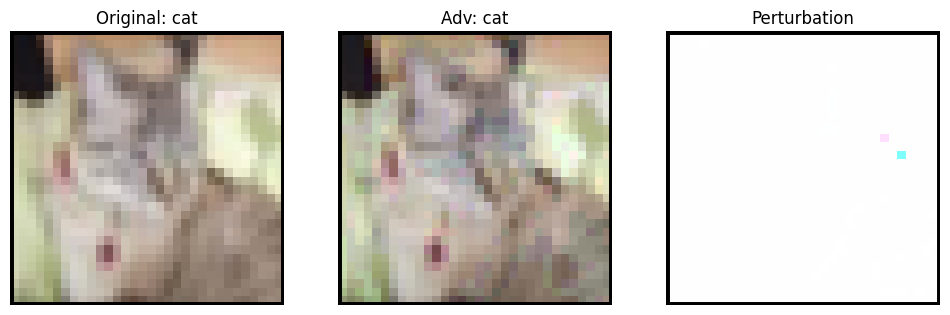

Sample 9/100


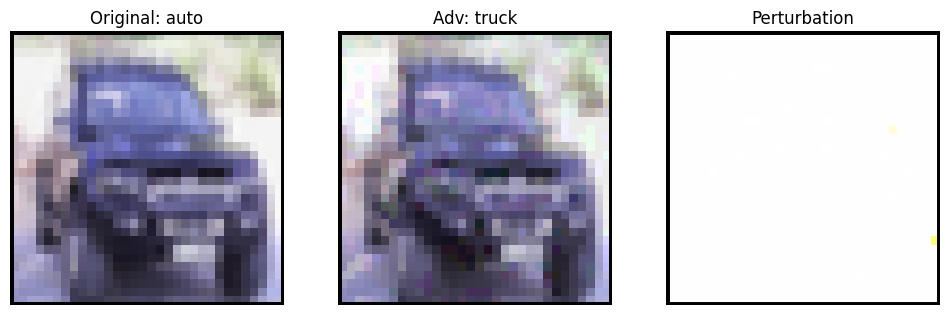

Sample 10/100


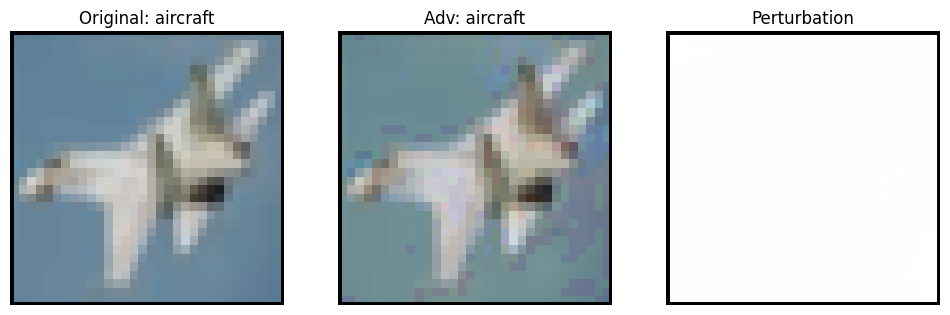

Sample 11/100


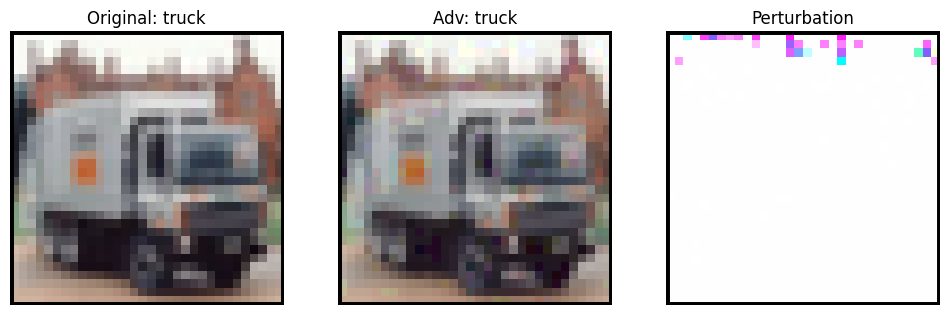

Sample 12/100
skipped element because y_pred=4 and y_true=tensor([5])
Sample 13/100


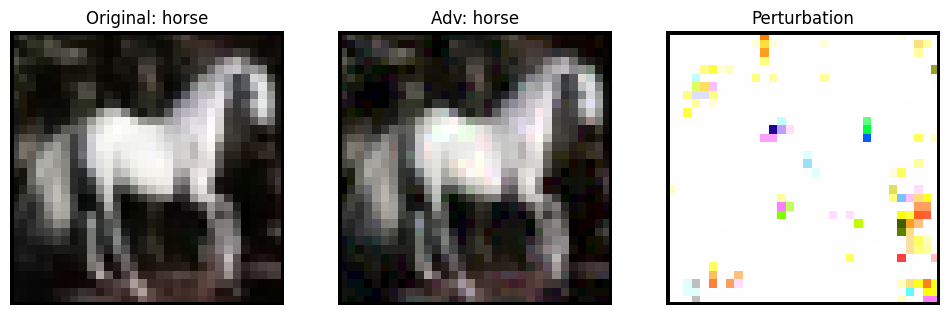

Sample 14/100


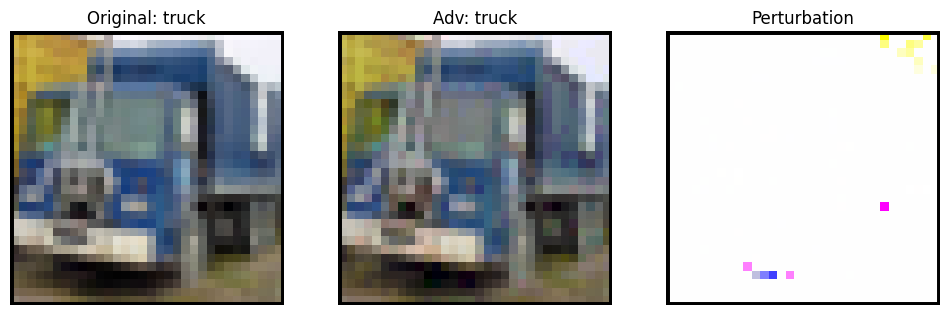

Sample 15/100


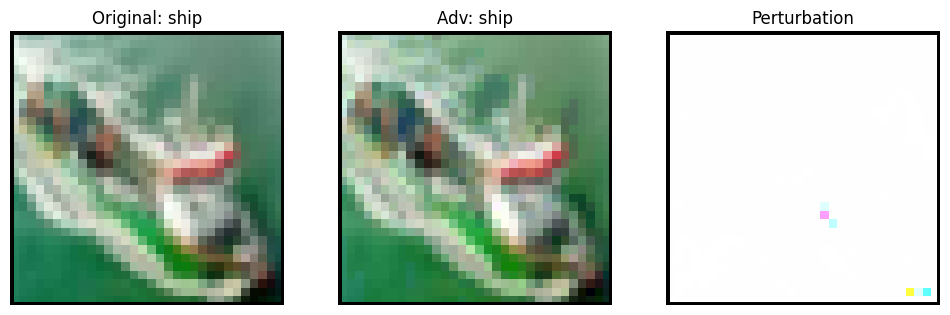

Sample 16/100


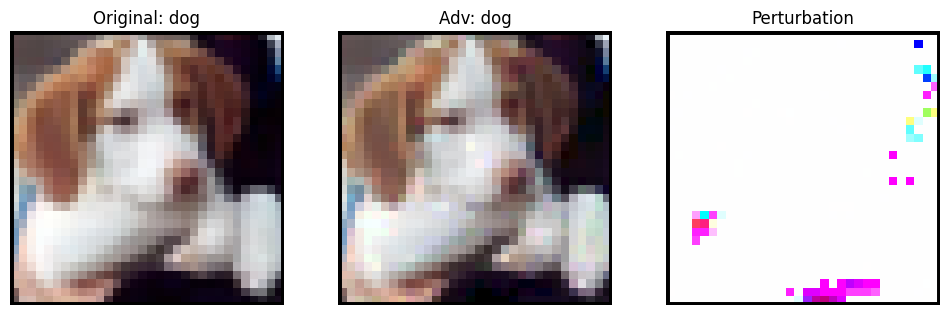

Sample 17/100


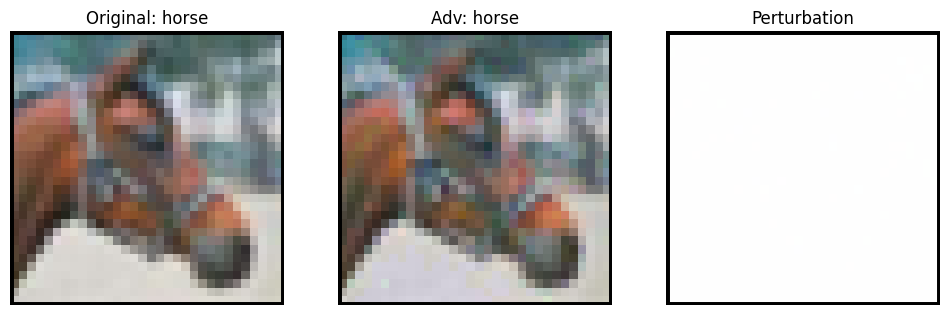

Sample 18/100


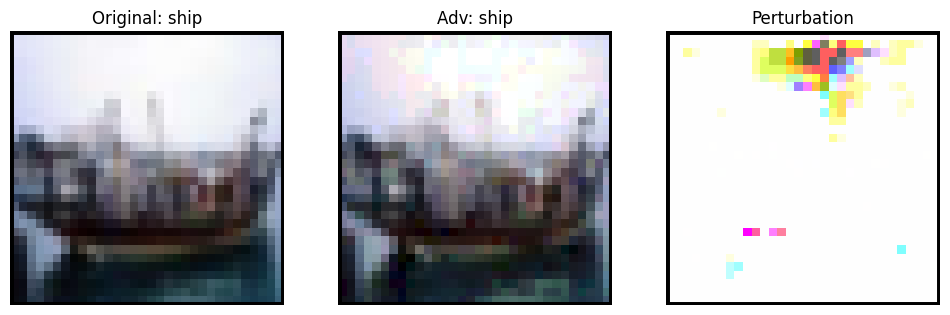

Sample 19/100


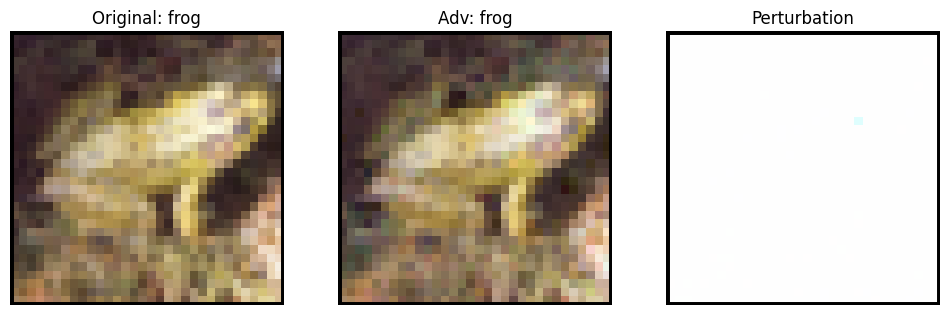

Sample 20/100


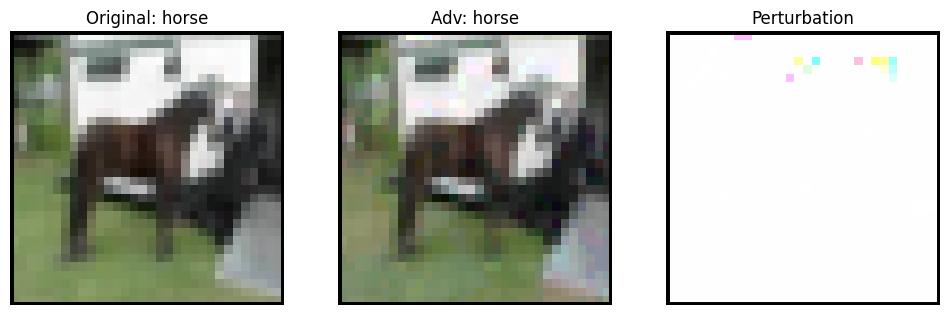

Sample 21/100


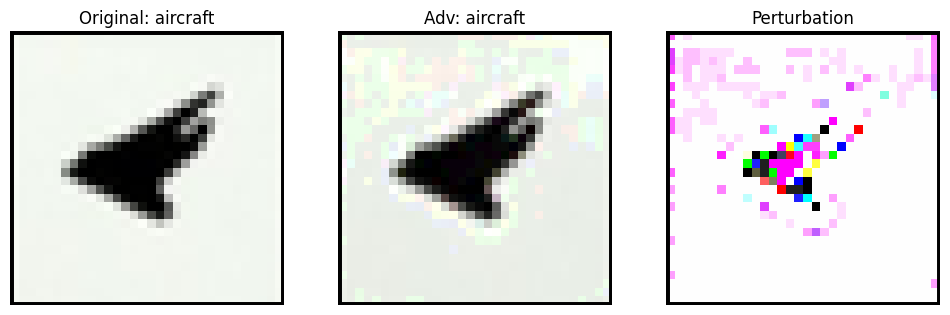

Sample 22/100
skipped element because y_pred=0 and y_true=tensor([4])
Sample 23/100


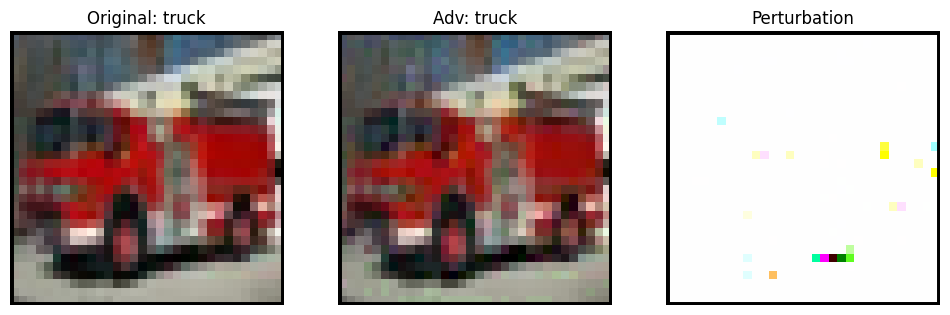

Sample 24/100
skipped element because y_pred=4 and y_true=tensor([5])
Sample 25/100


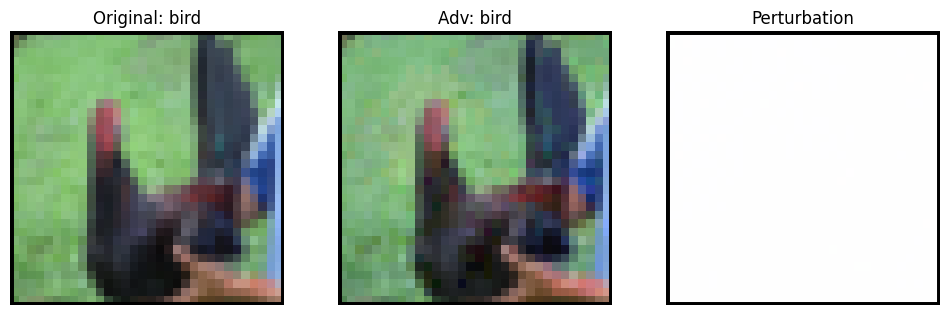

Sample 26/100


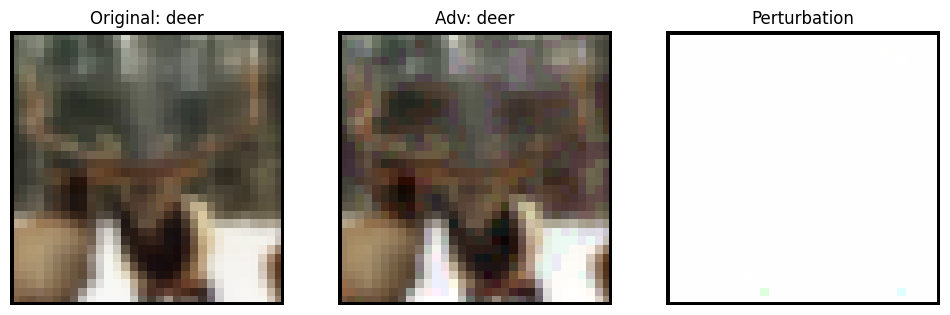

Sample 27/100


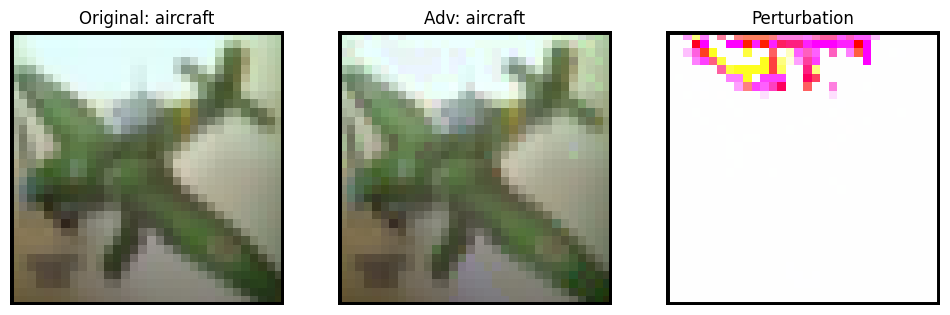

Sample 28/100


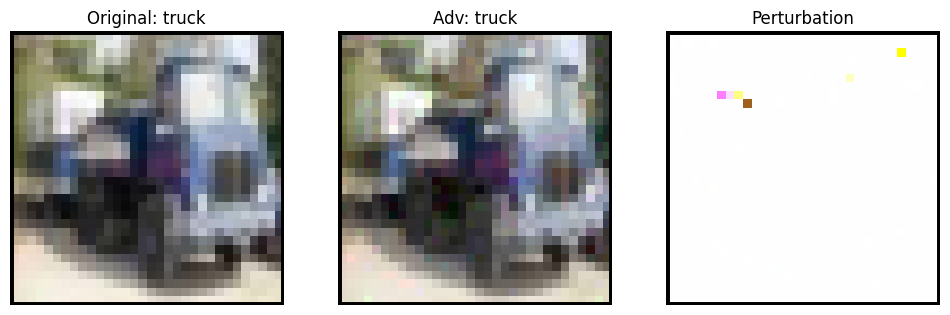

Sample 29/100


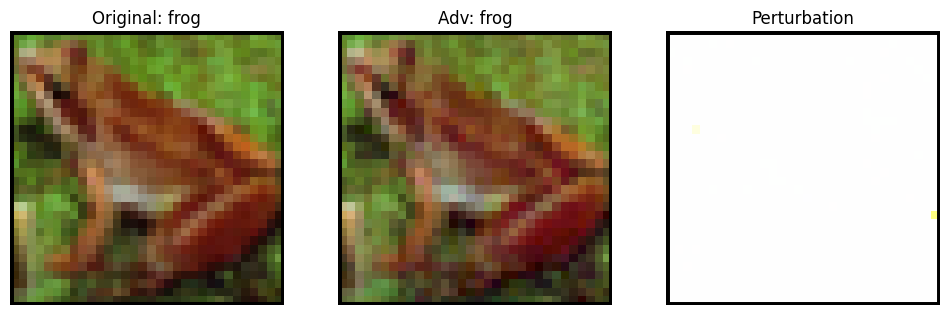

Sample 30/100


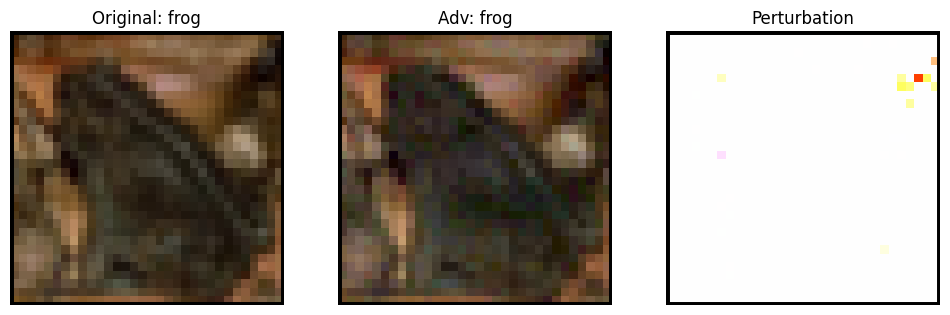

Sample 31/100


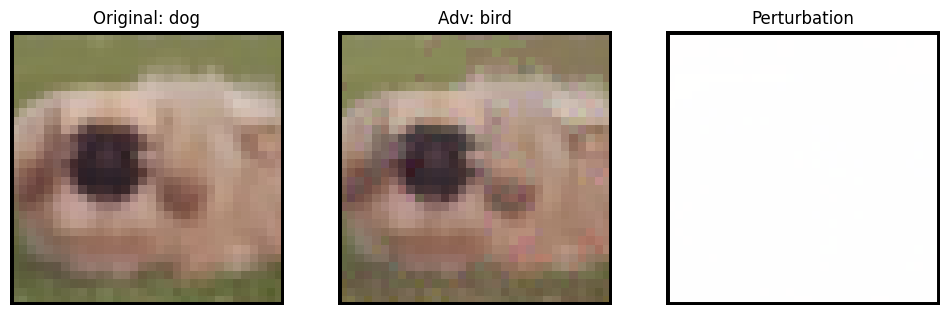

Sample 32/100


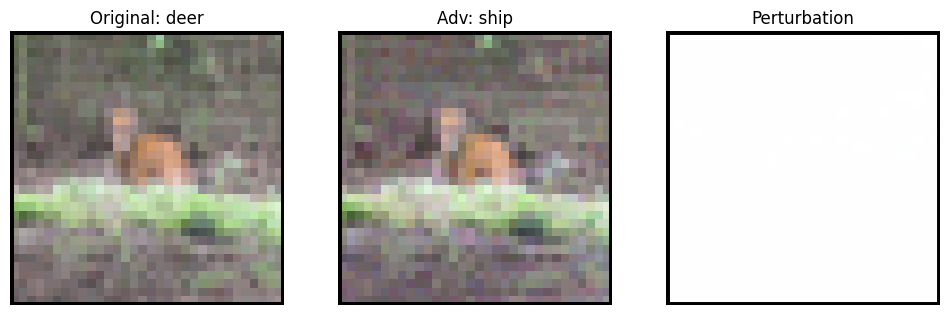

Sample 33/100


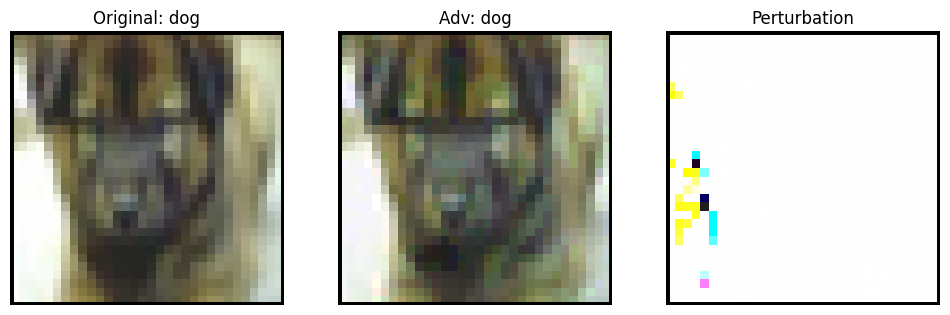

Sample 34/100


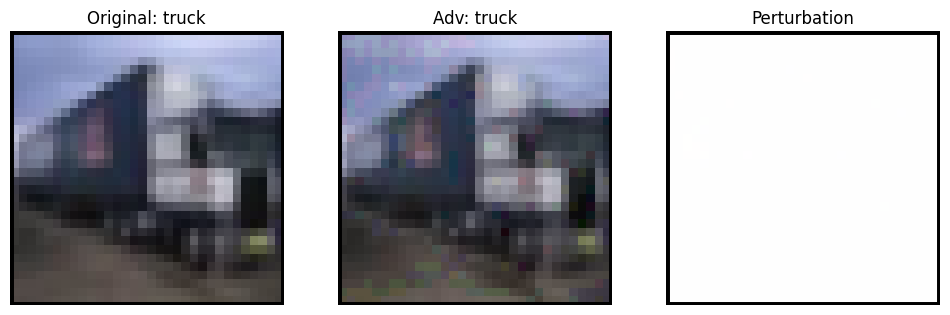

Sample 35/100
skipped element because y_pred=3 and y_true=tensor([2])
Sample 36/100


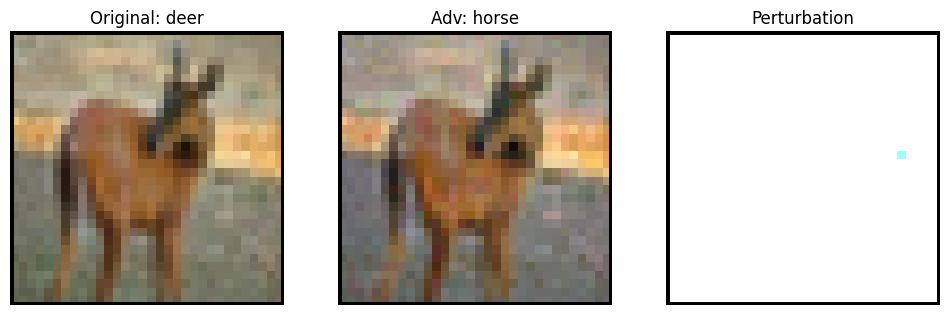

Sample 37/100
skipped element because y_pred=9 and y_true=tensor([1])
Sample 38/100


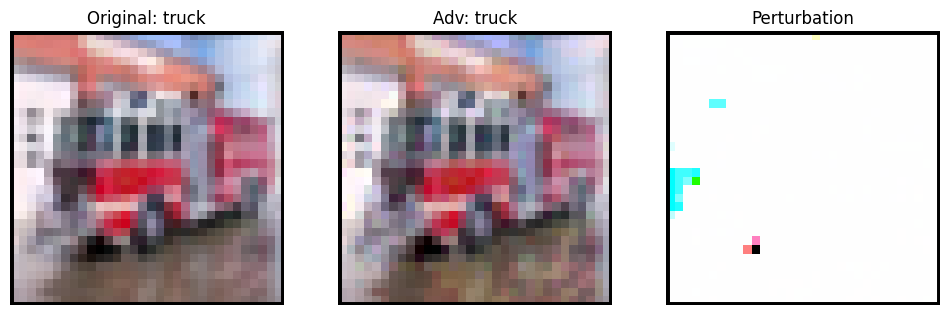

Sample 39/100


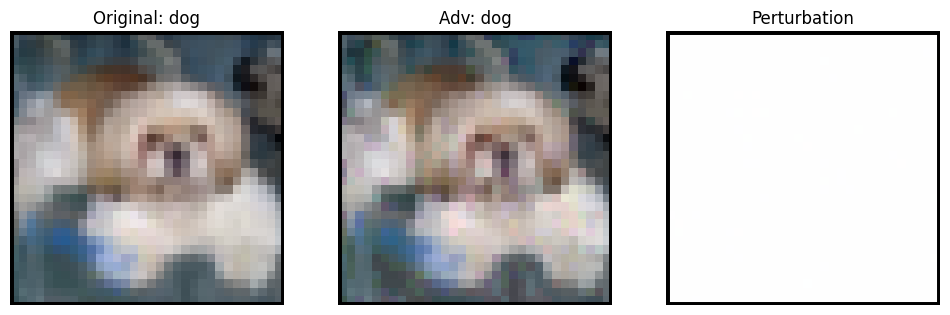

Sample 40/100


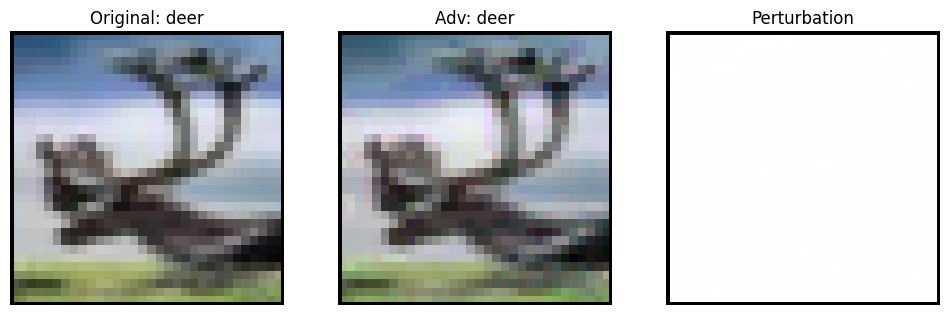

Sample 41/100


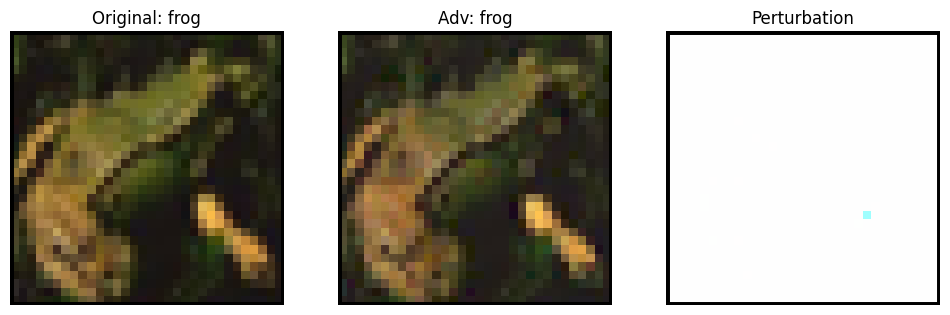

Sample 42/100


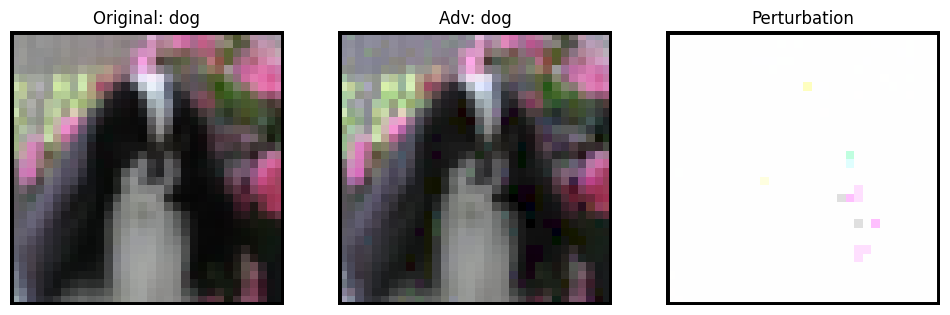

Sample 43/100


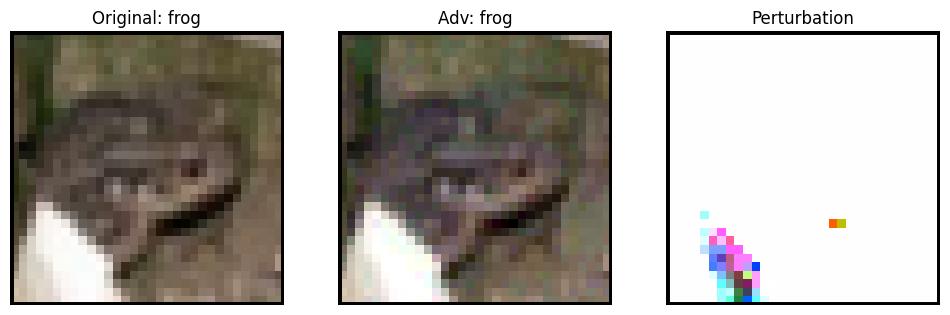

Sample 44/100


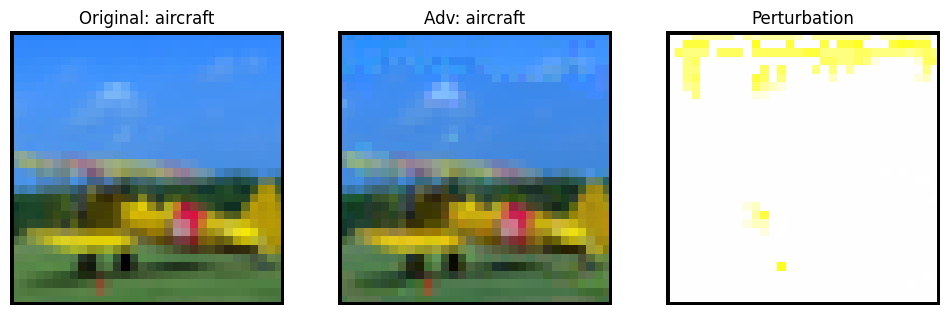

Sample 45/100


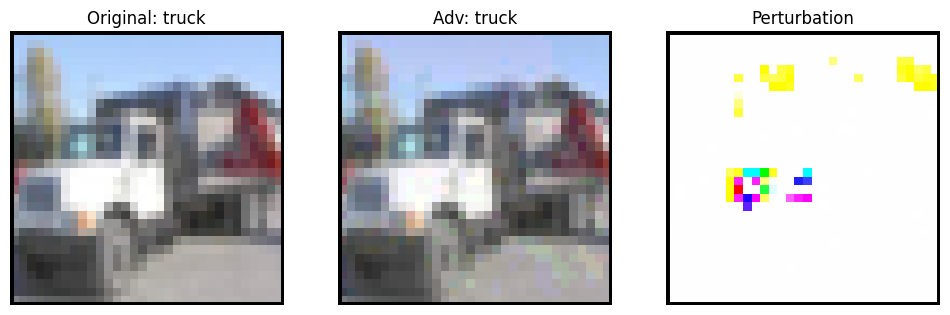

Sample 46/100


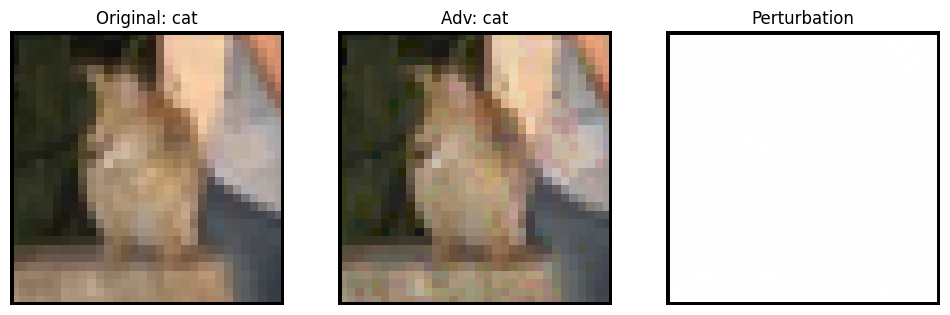

Sample 47/100


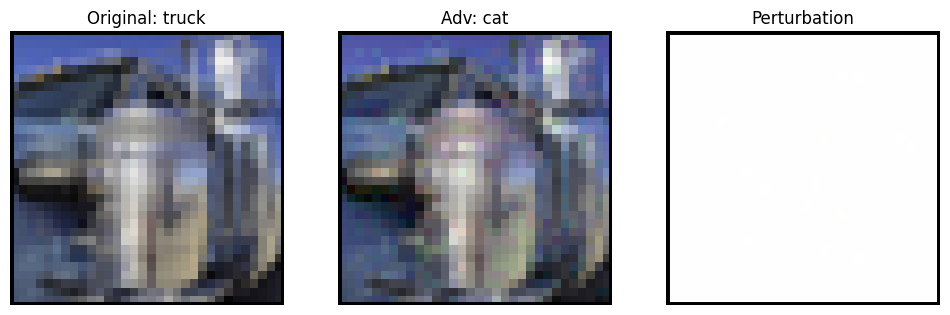

Sample 48/100


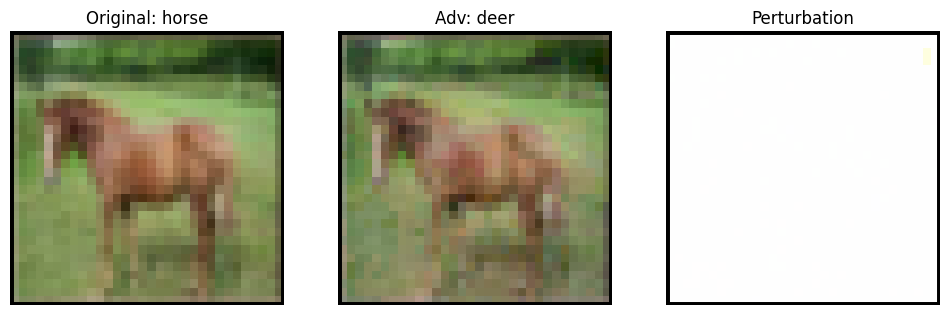

Sample 49/100


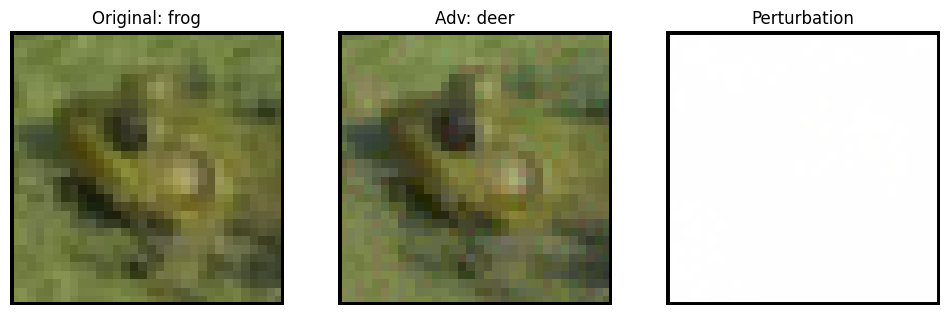

Sample 50/100


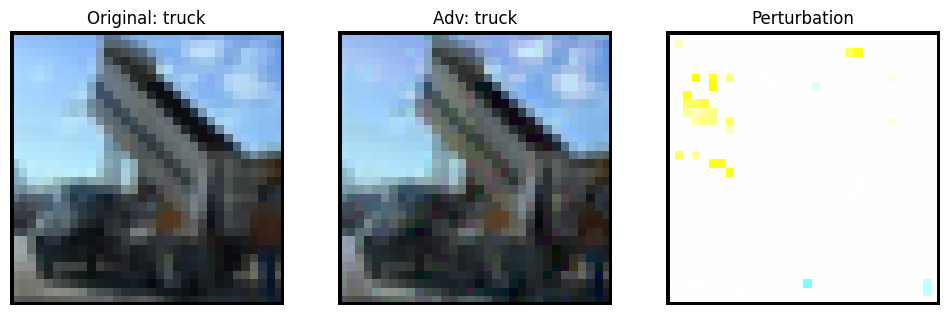

Sample 51/100


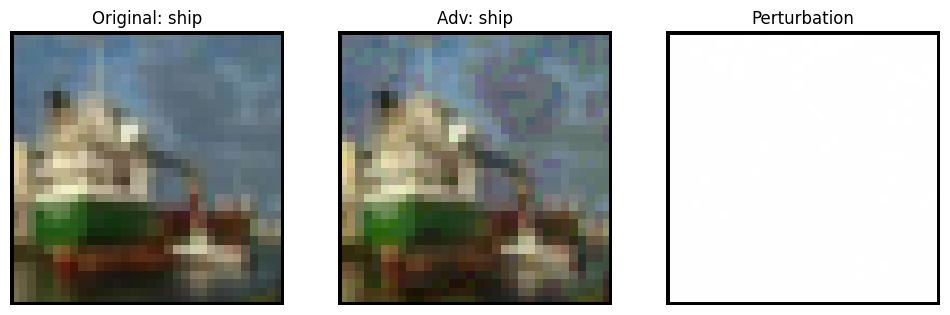

Sample 52/100
skipped element because y_pred=6 and y_true=tensor([0])
Sample 53/100


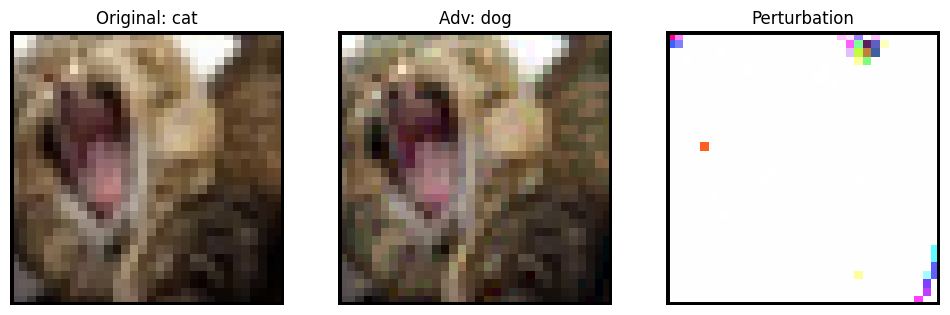

Sample 54/100


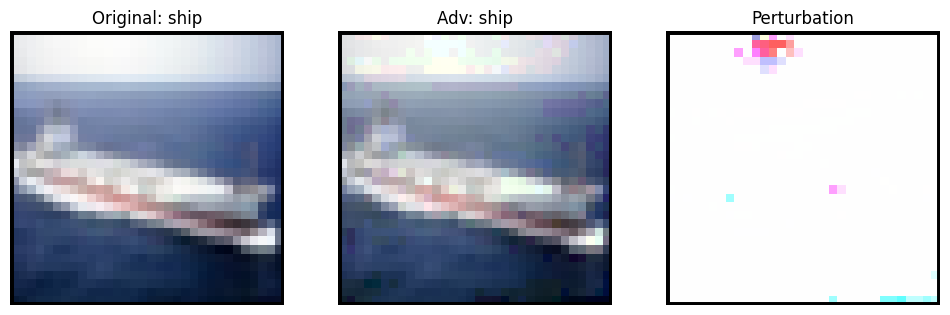

Sample 55/100


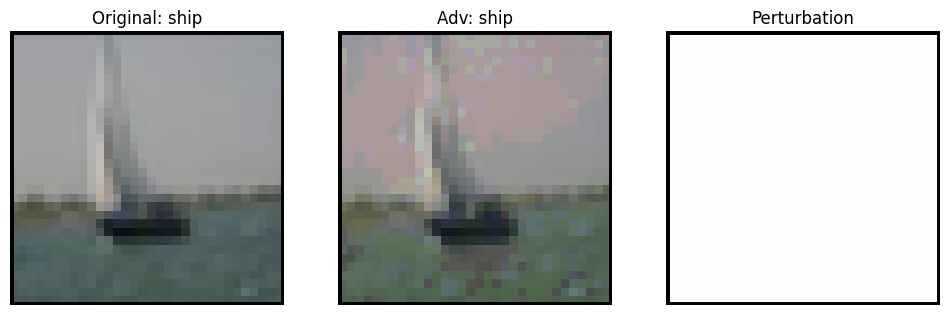

Sample 56/100


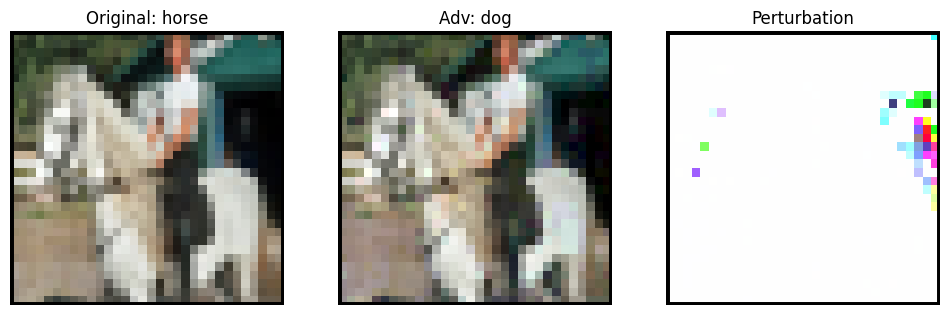

Sample 57/100


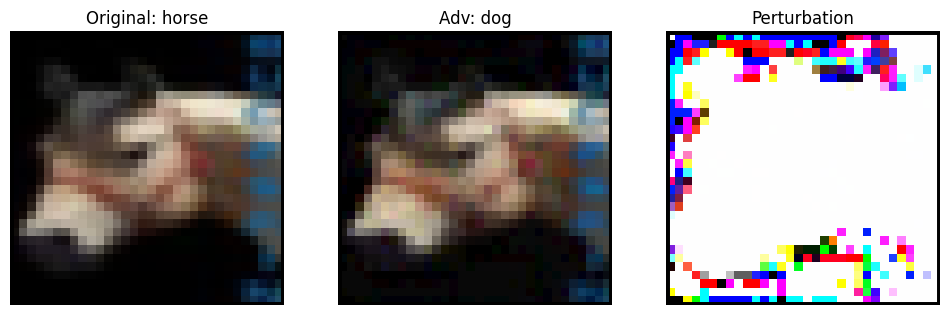

Sample 58/100
skipped element because y_pred=3 and y_true=tensor([4])
Sample 59/100
skipped element because y_pred=4 and y_true=tensor([6])
Sample 60/100


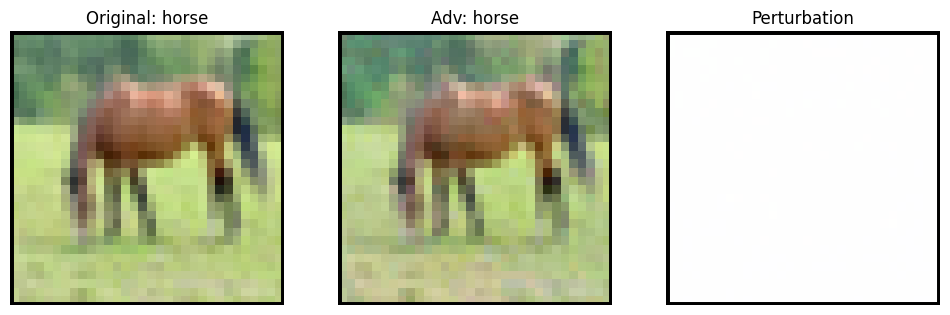

Sample 61/100


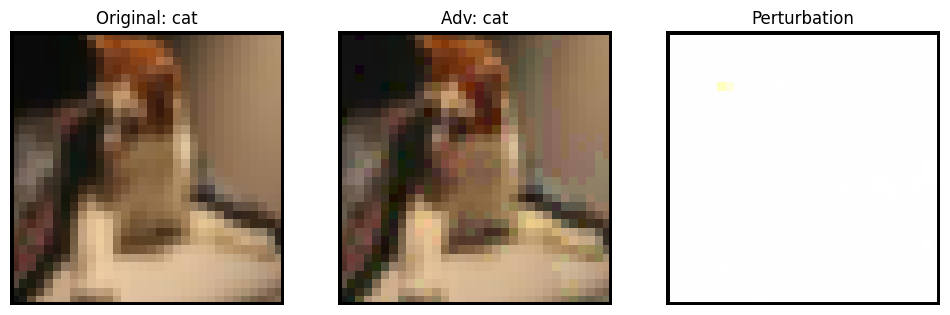

Sample 62/100


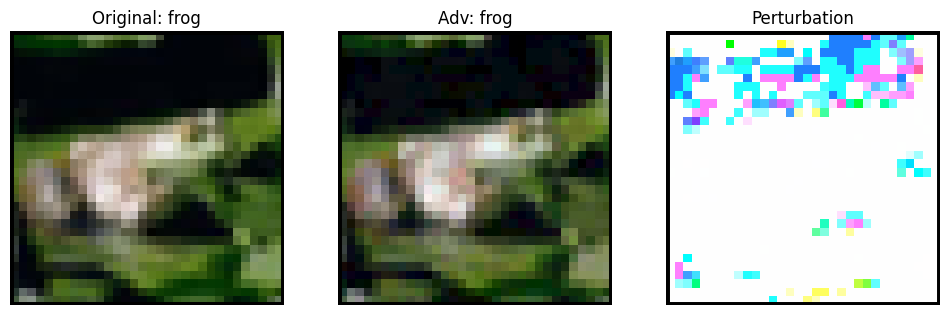

Sample 63/100
skipped element because y_pred=9 and y_true=tensor([3])
Sample 64/100


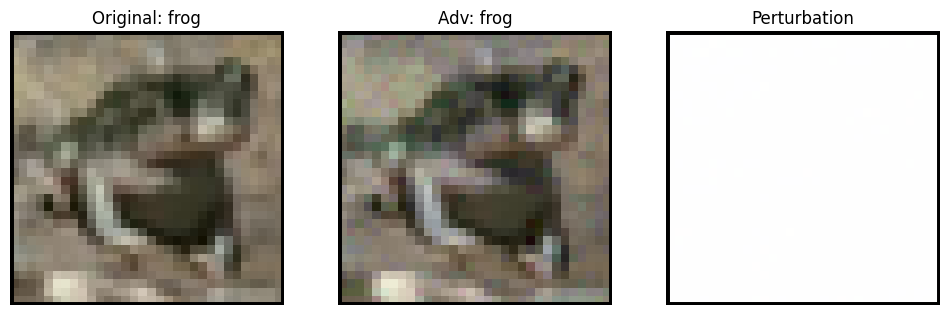

Sample 65/100
skipped element because y_pred=6 and y_true=tensor([2])
Sample 66/100


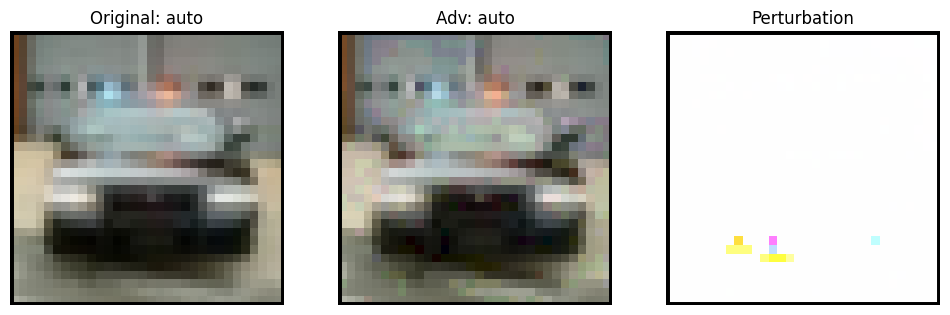

Sample 67/100


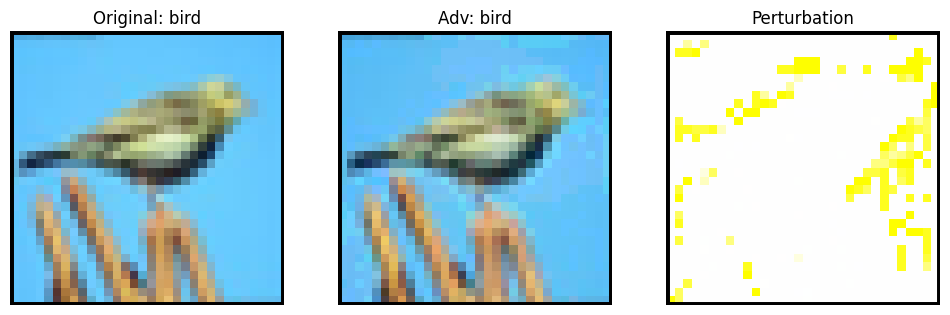

Sample 68/100


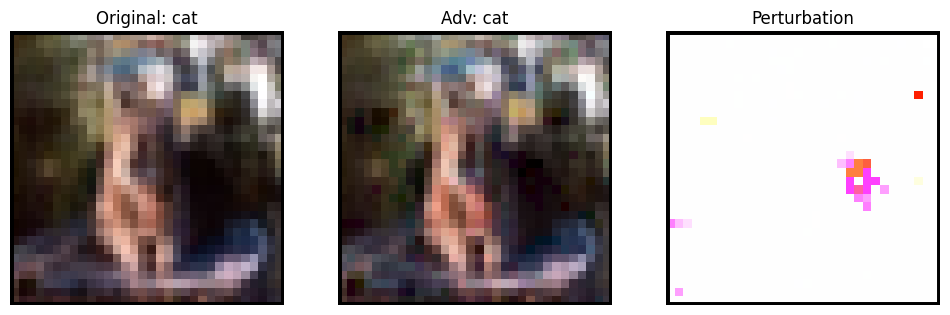

Sample 69/100


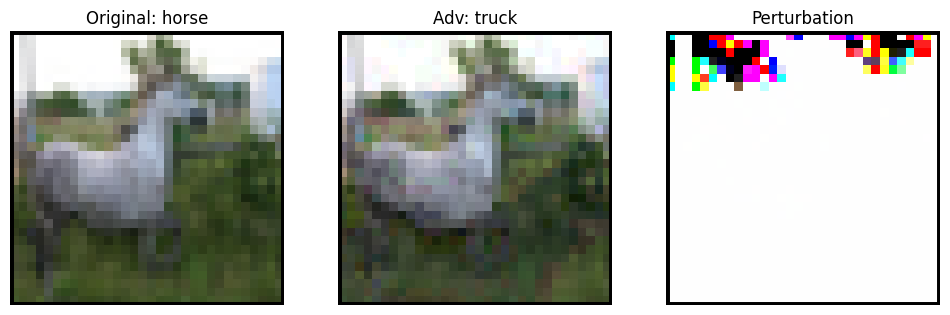

Sample 70/100


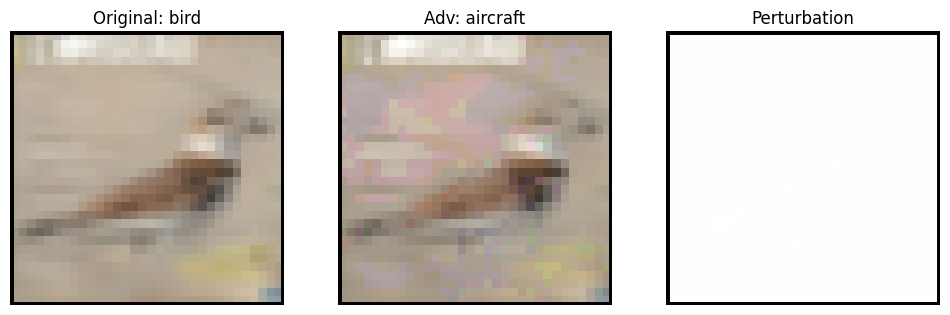

Sample 71/100


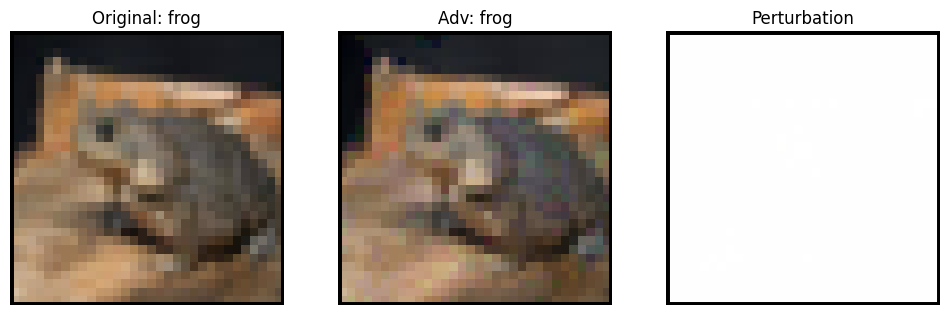

Sample 72/100


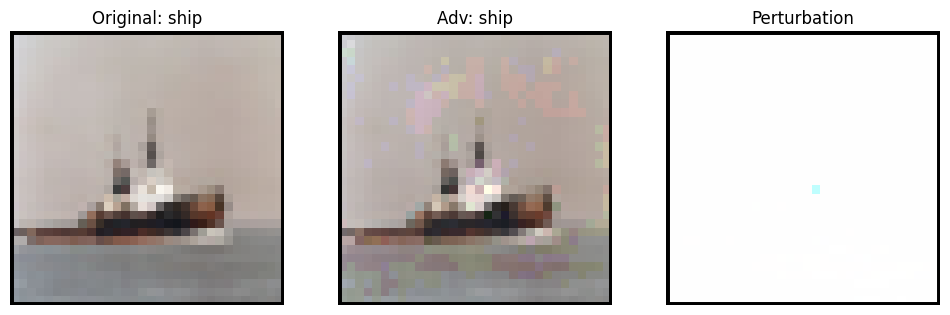

Sample 73/100


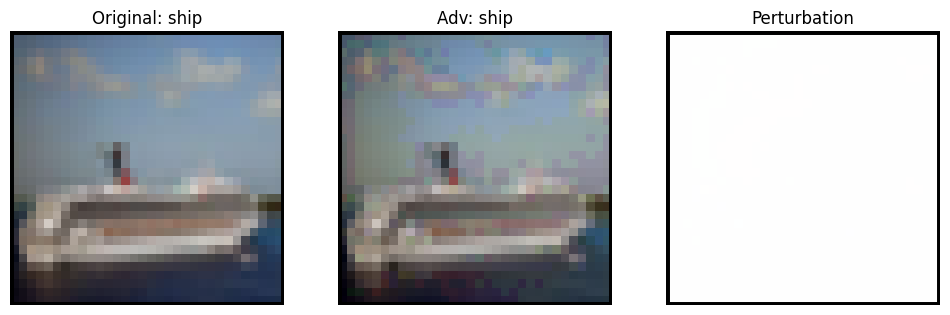

Sample 74/100


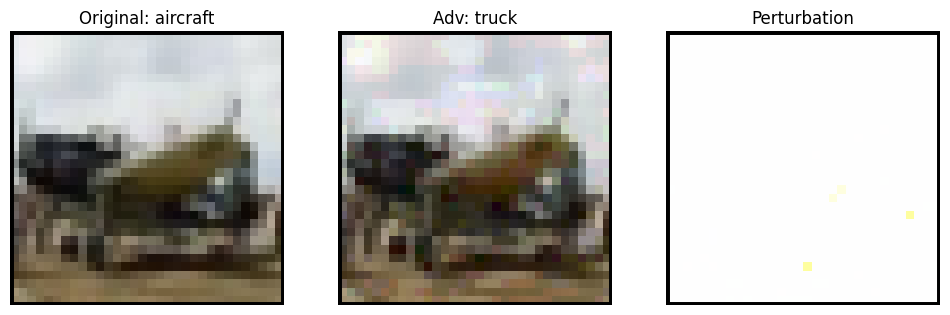

Sample 75/100


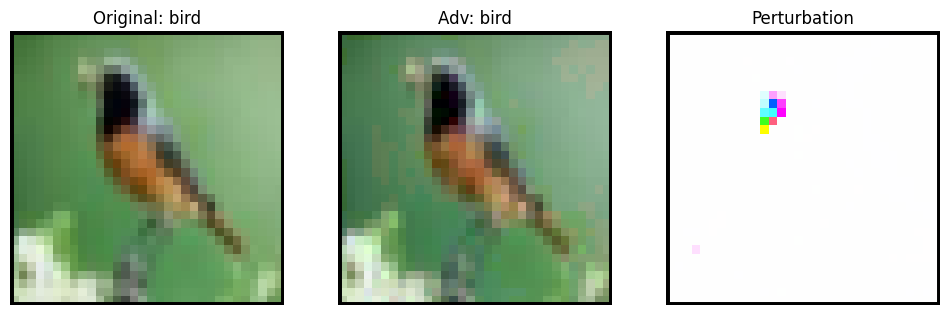

Sample 76/100


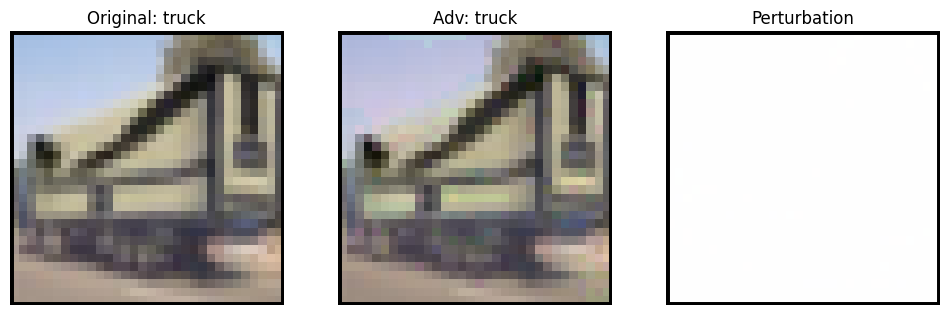

Sample 77/100


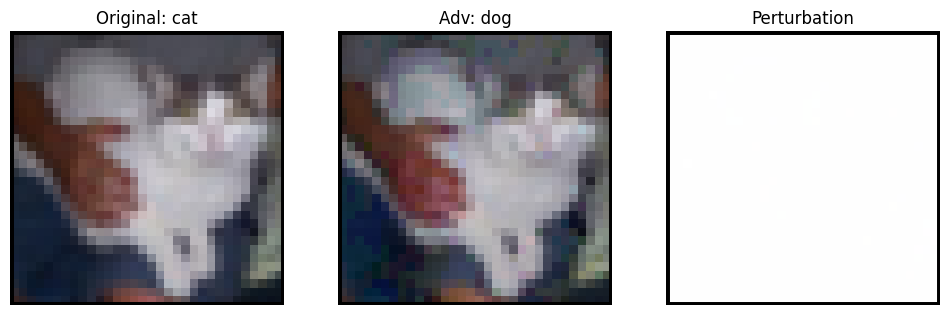

Sample 78/100


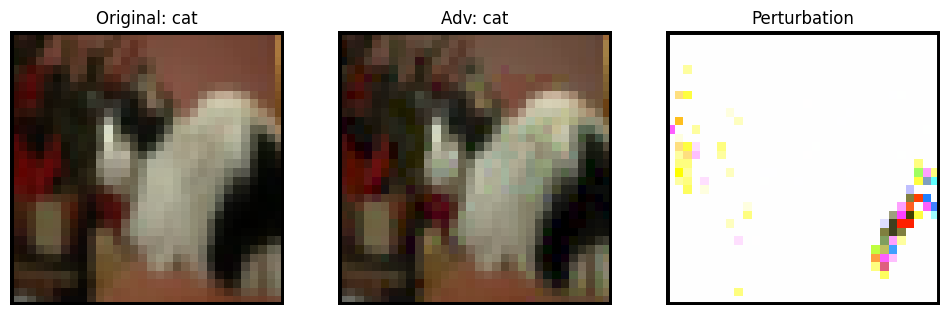

Sample 79/100


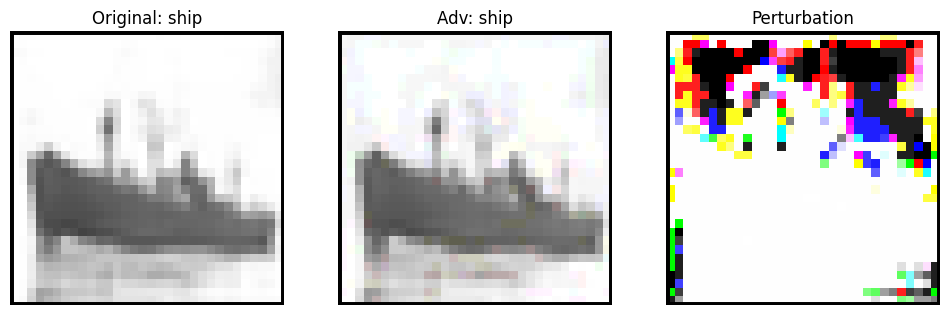

Sample 80/100


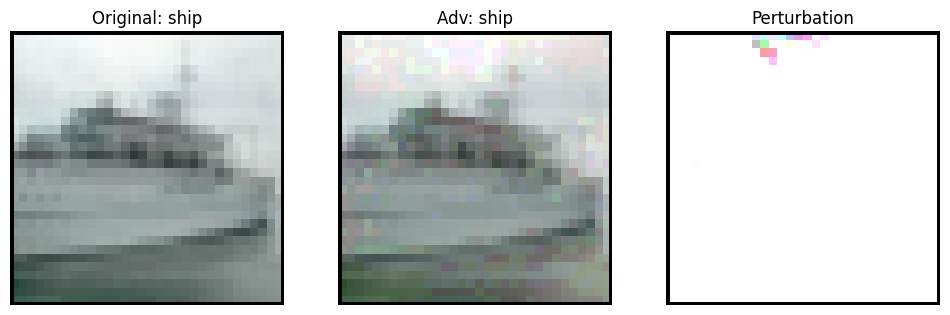

Sample 81/100


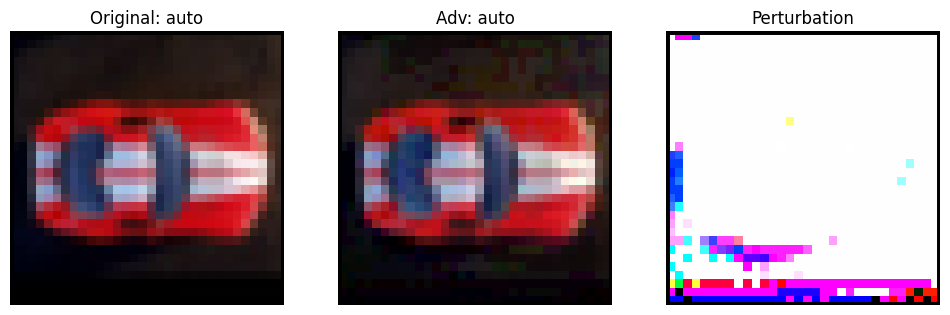

Sample 82/100


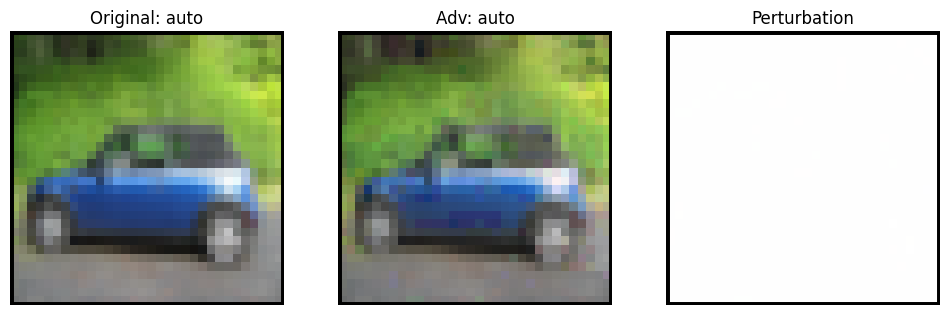

Sample 83/100


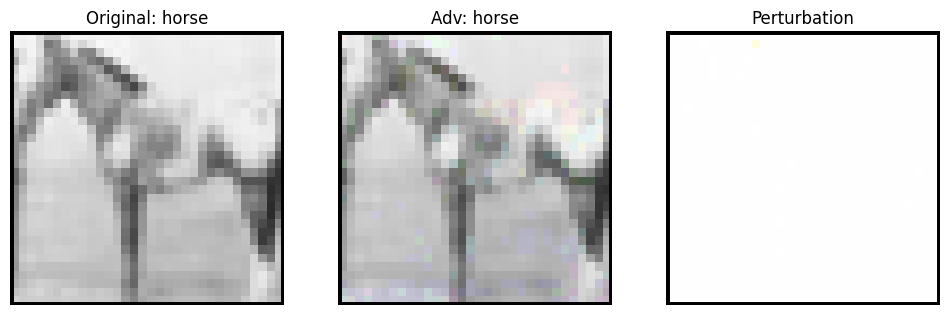

Sample 84/100


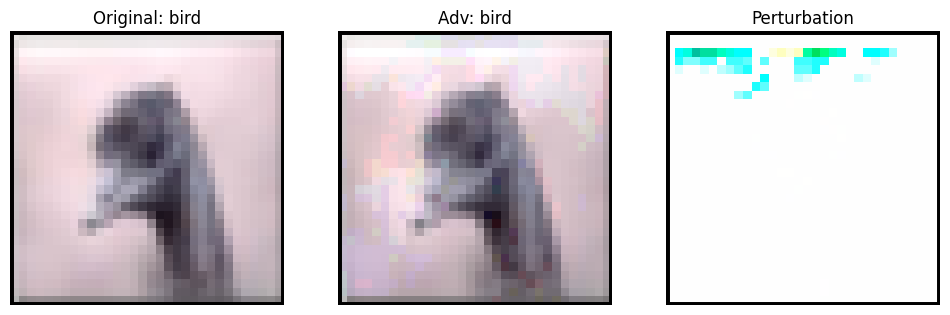

Sample 85/100
skipped element because y_pred=7 and y_true=tensor([5])
Sample 86/100


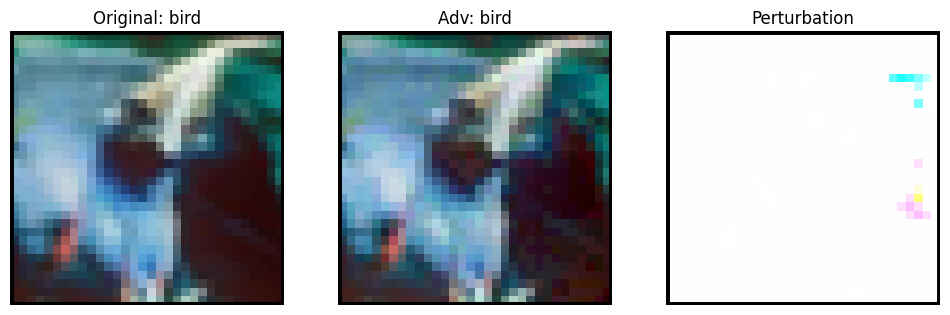

Sample 87/100
skipped element because y_pred=8 and y_true=tensor([7])
Sample 88/100


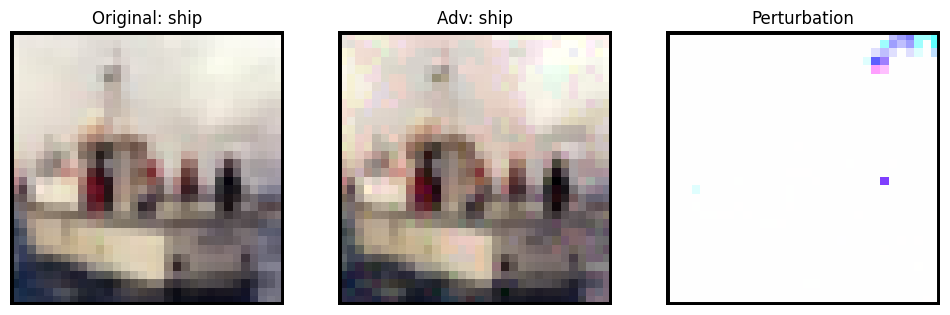

Sample 89/100


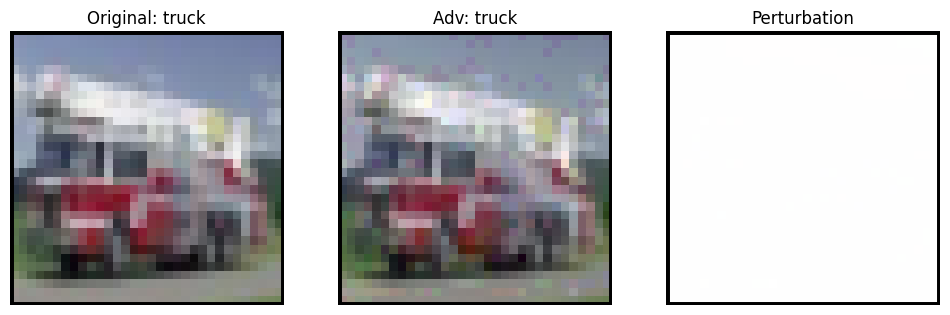

Sample 90/100


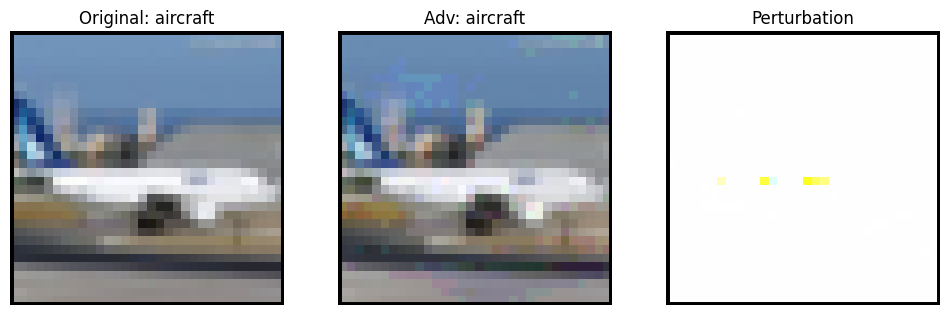

Sample 91/100
skipped element because y_pred=4 and y_true=tensor([3])
Sample 92/100


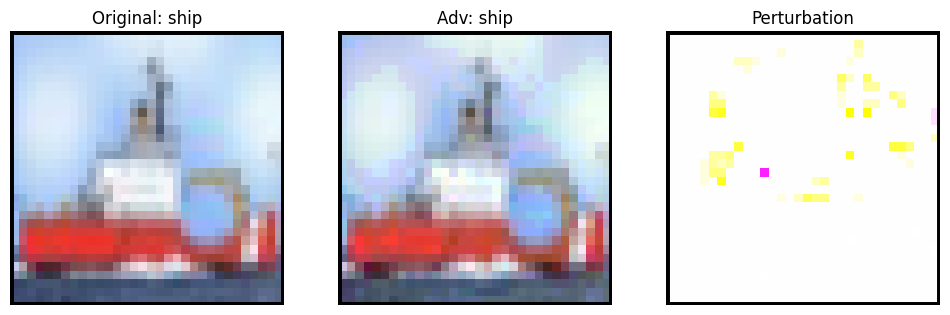

Sample 93/100


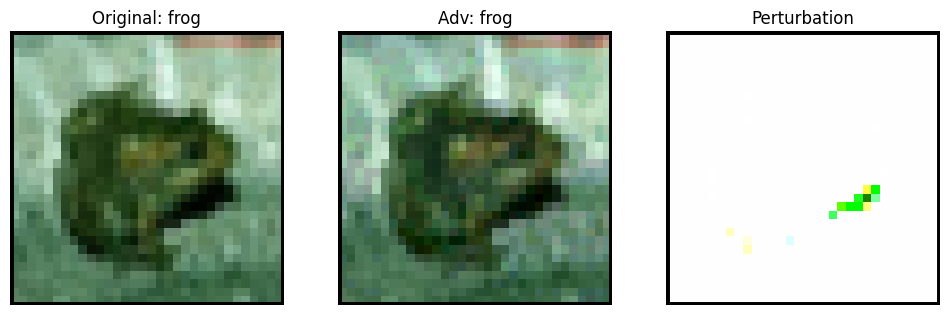

Sample 94/100


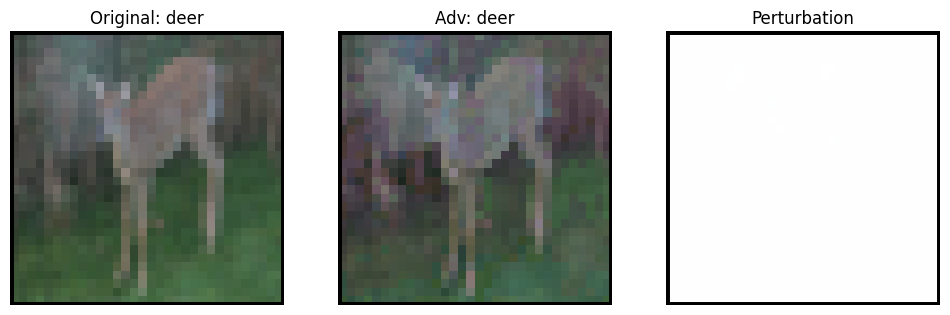

Sample 95/100


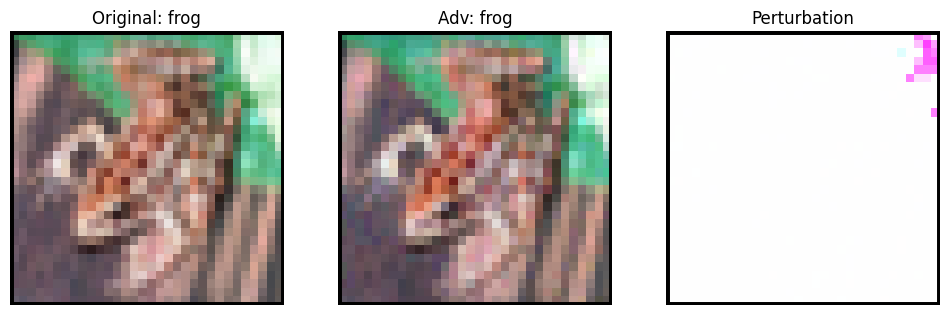

Sample 96/100


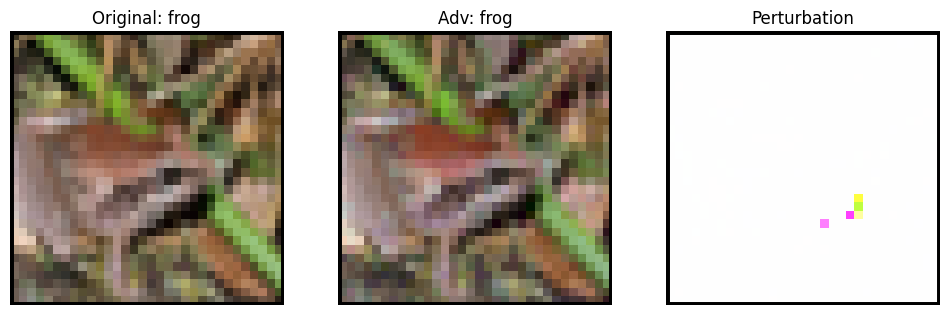

Sample 97/100


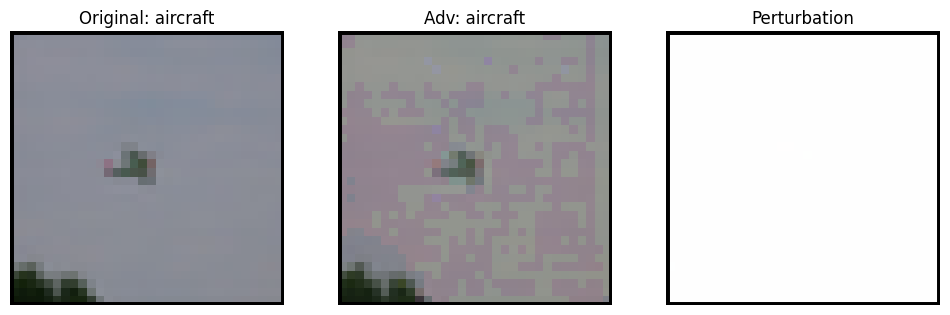

Sample 98/100


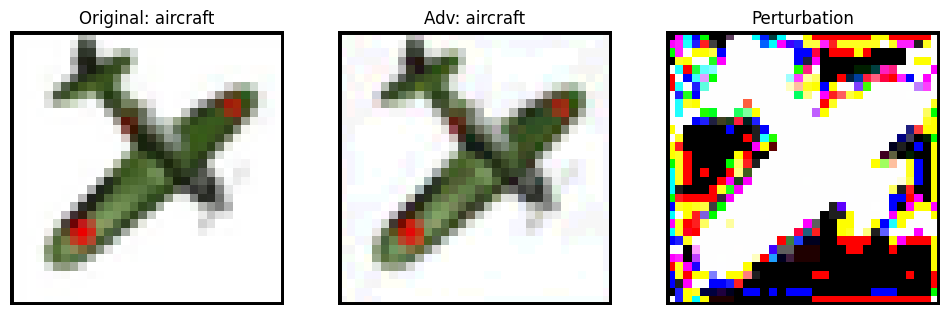

Sample 99/100


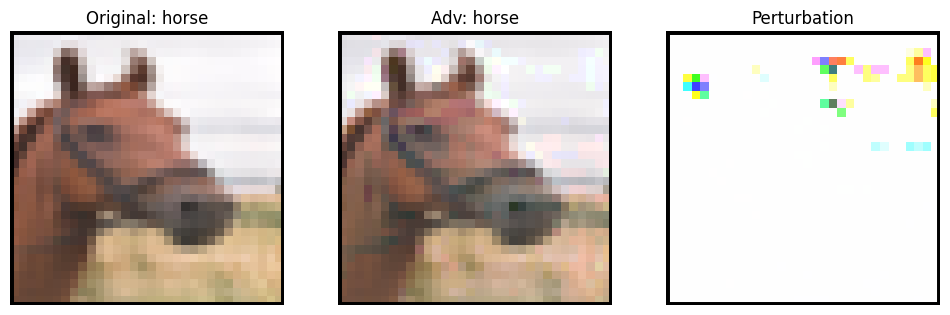

FINISHED. Computed n.16 adversarial examples, skipped n.13 samples
Sample 0/100


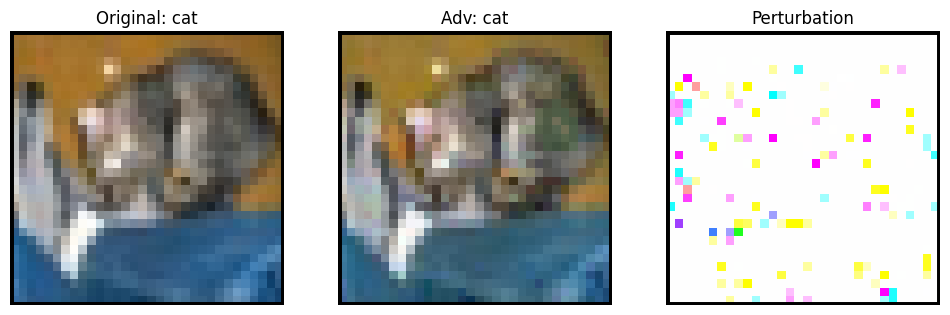

Sample 1/100


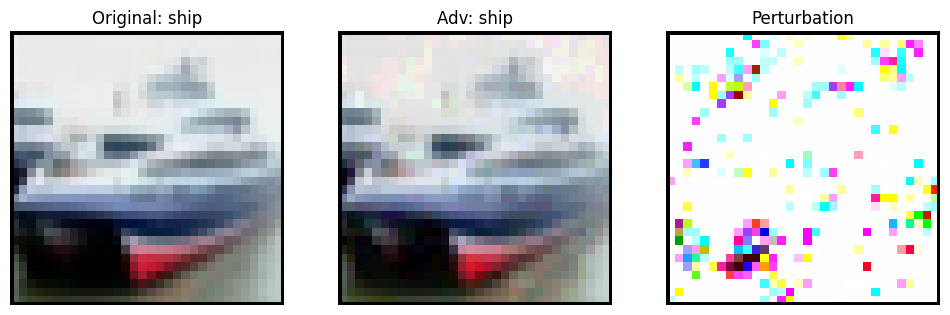

Sample 2/100


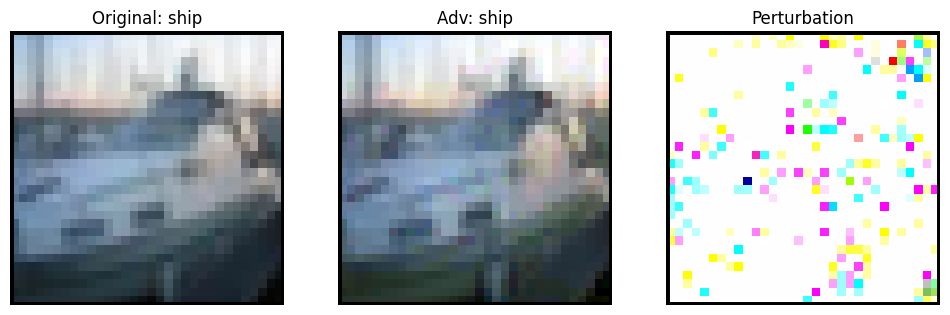

Sample 3/100


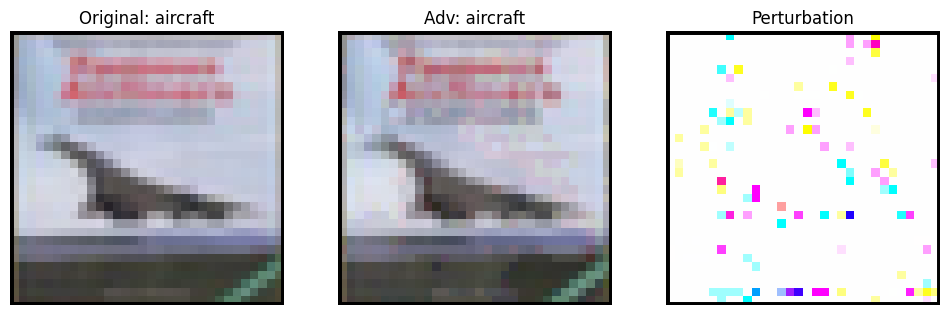

Sample 4/100


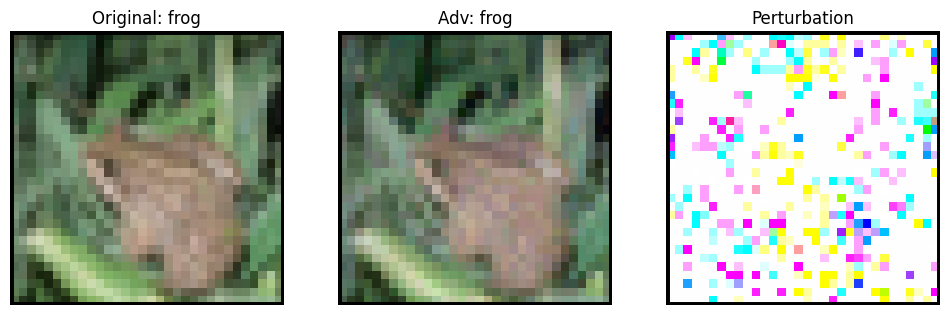

Sample 5/100


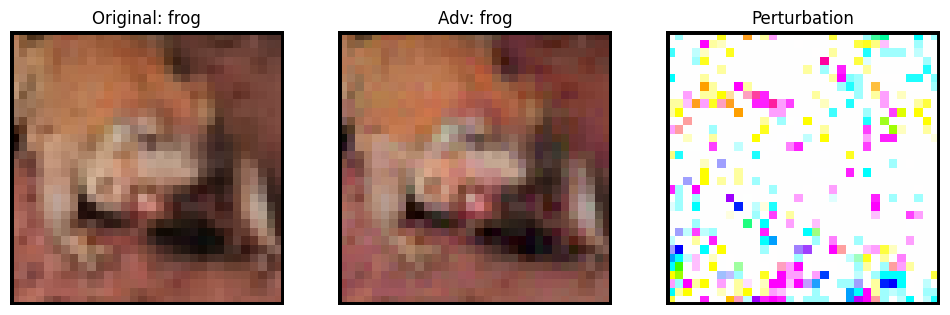

Sample 6/100
Early stopping at iter 2: ensemble misclassification!


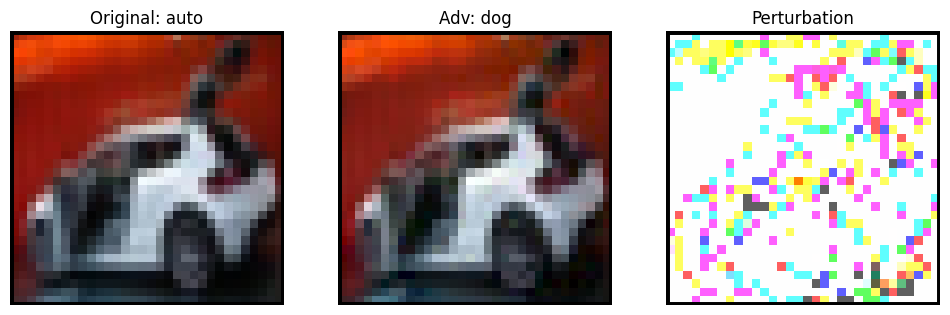

Sample 7/100
Early stopping at iter 0: ensemble misclassification!


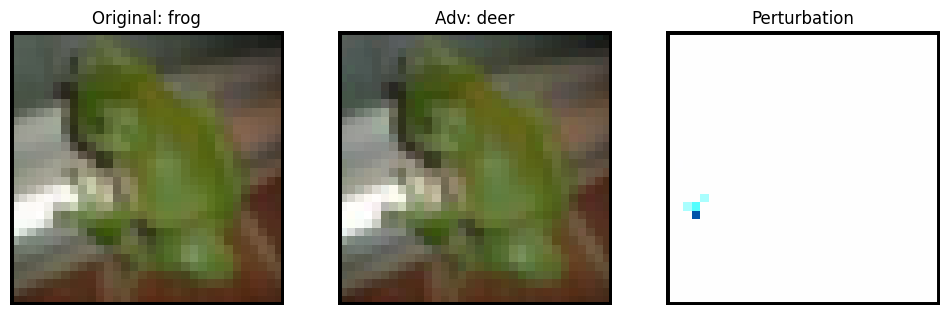

Sample 8/100


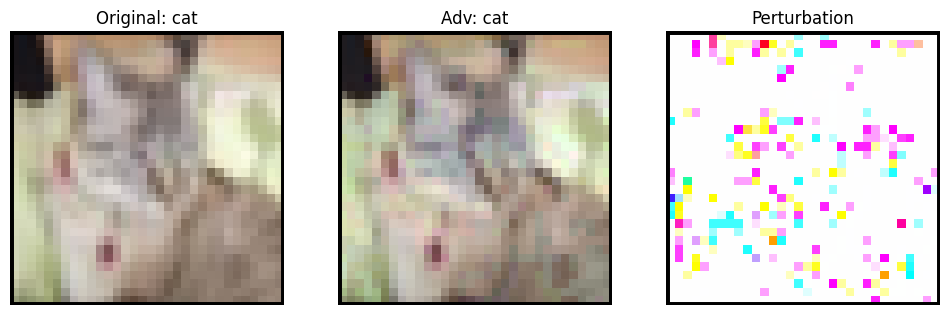

Sample 9/100
Early stopping at iter 0: ensemble misclassification!


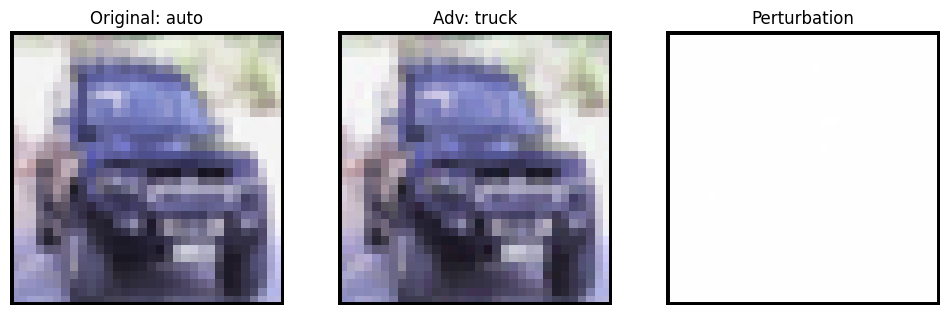

Sample 10/100


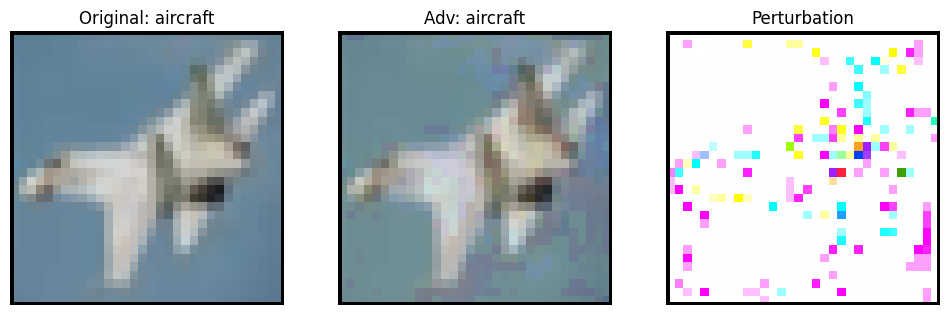

Sample 11/100


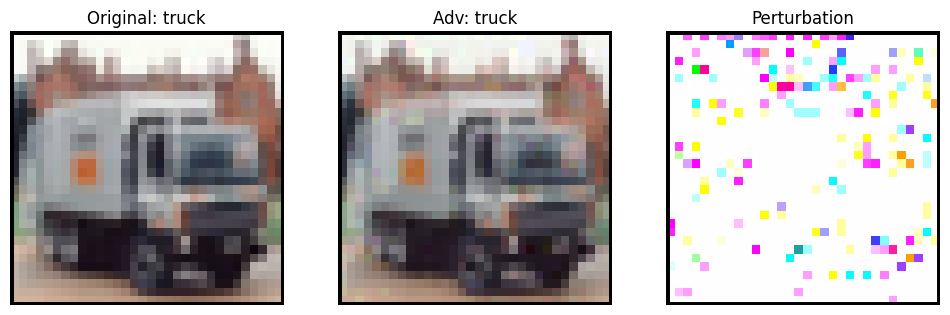

Sample 12/100
skipped element because y_pred=4 and y_true=tensor([5])
Sample 13/100


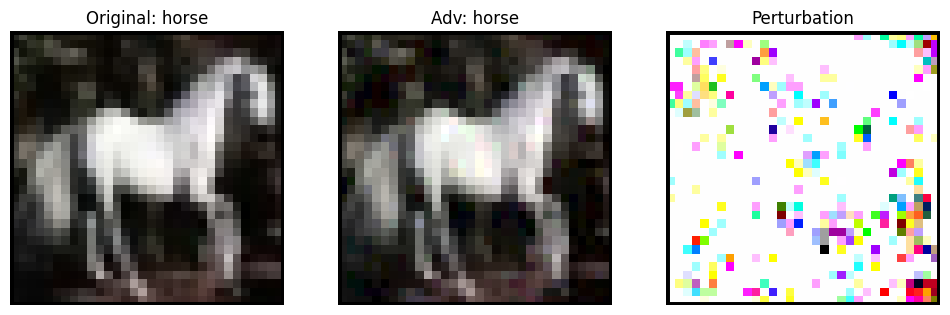

Sample 14/100


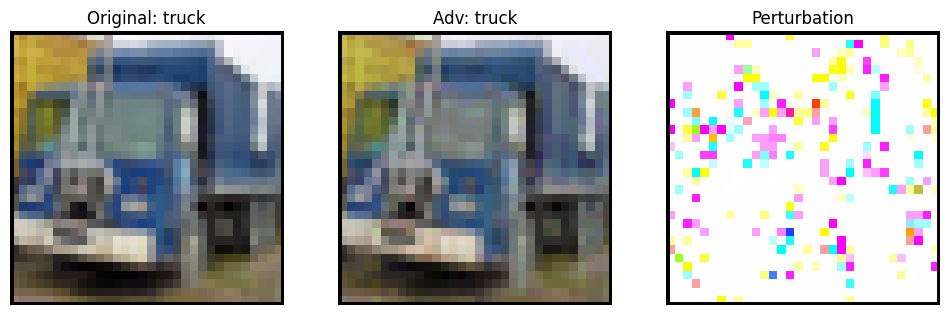

Sample 15/100


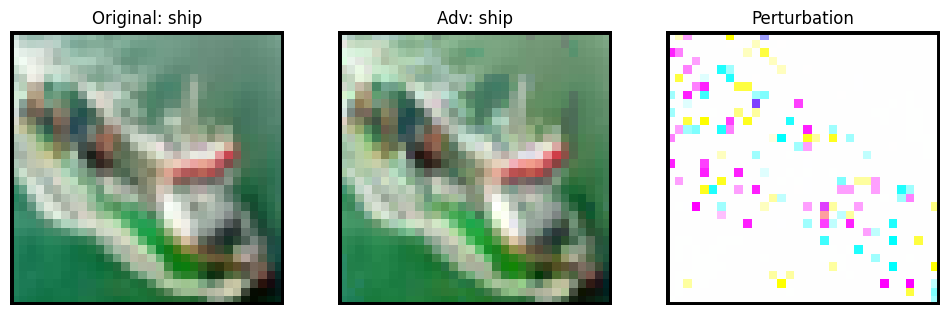

Sample 16/100


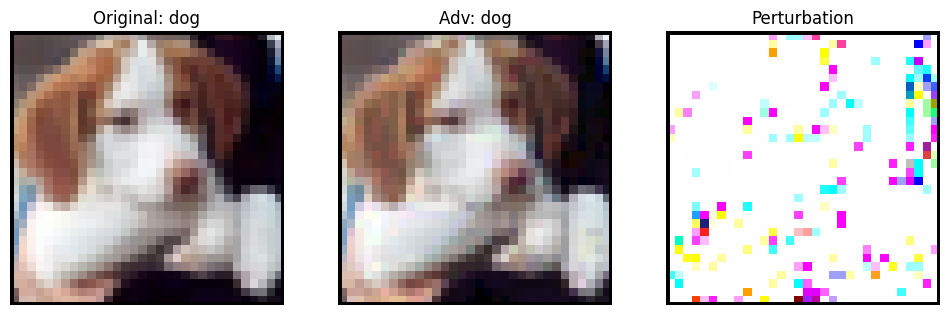

Sample 17/100


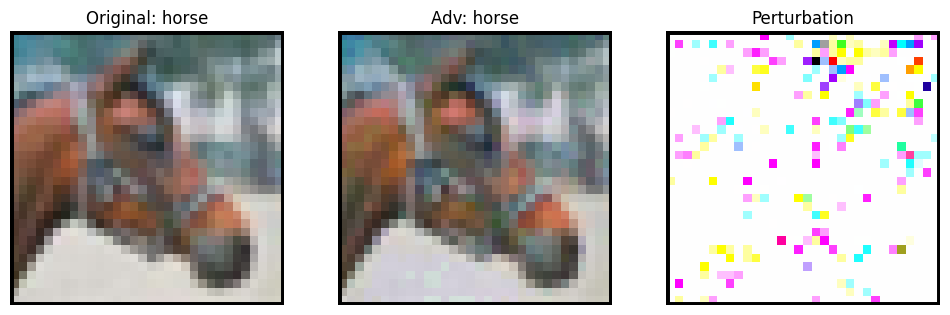

Sample 18/100


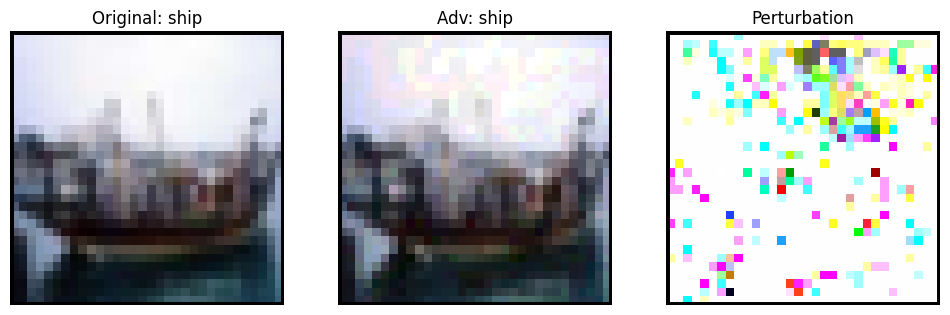

Sample 19/100


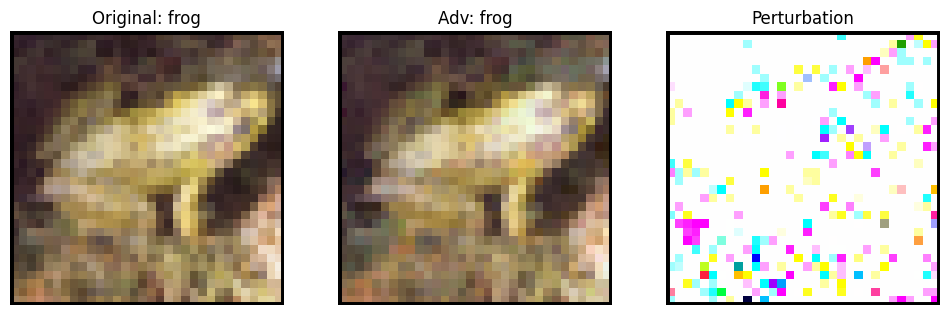

Sample 20/100


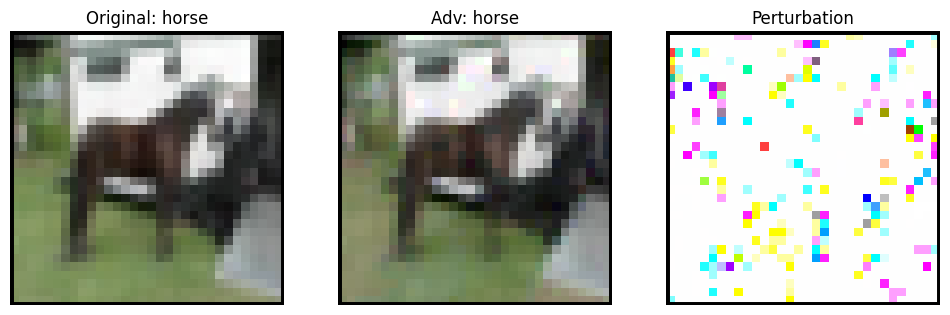

Sample 21/100


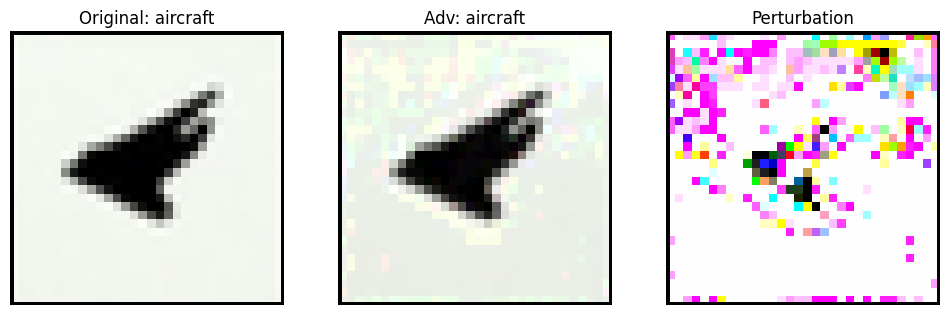

Sample 22/100
skipped element because y_pred=0 and y_true=tensor([4])
Sample 23/100


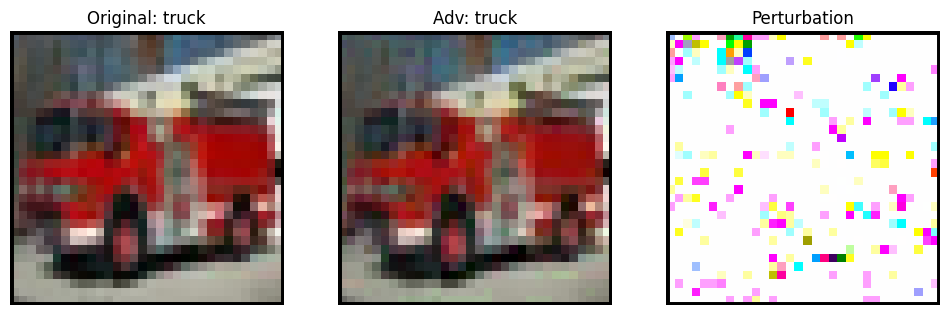

Sample 24/100
skipped element because y_pred=4 and y_true=tensor([5])
Sample 25/100


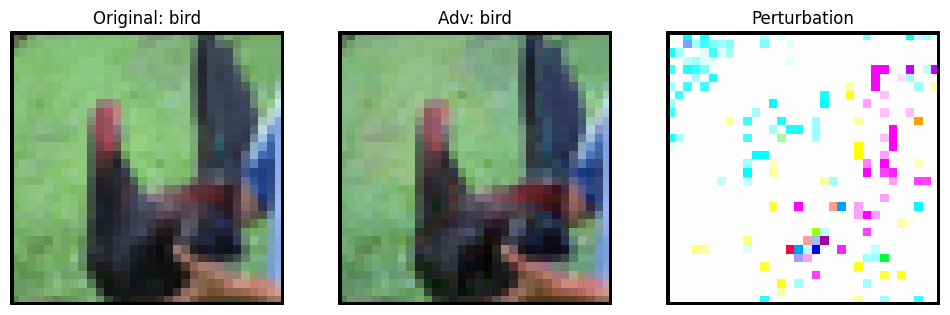

Sample 26/100


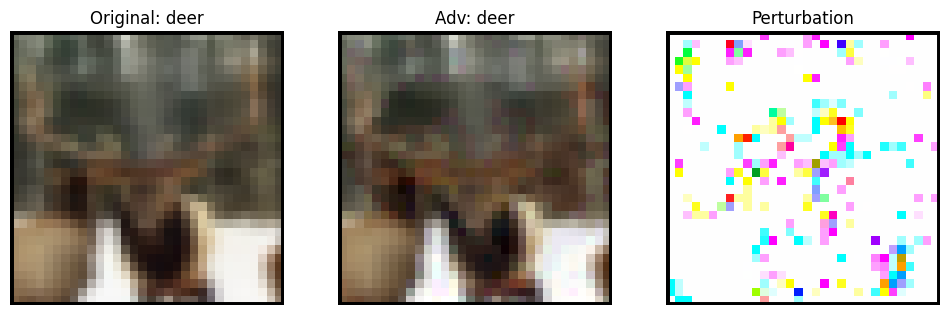

Sample 27/100


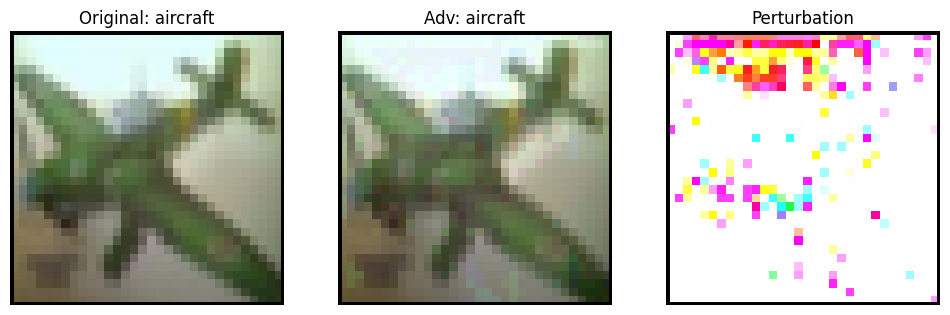

Sample 28/100


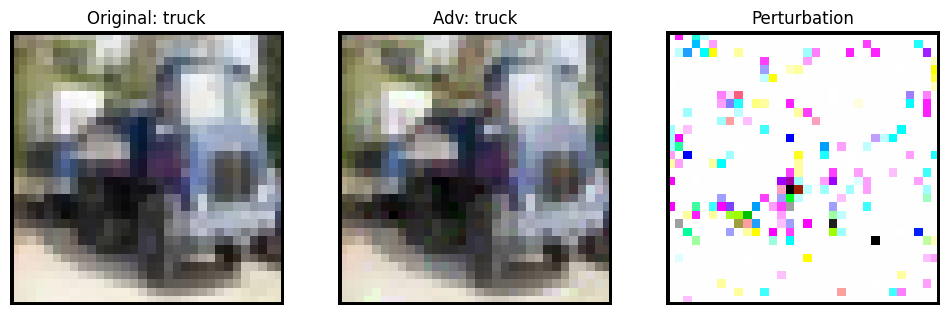

Sample 29/100


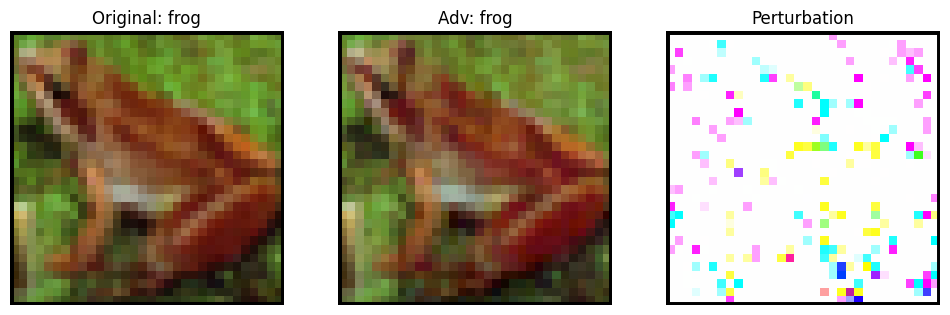

Sample 30/100


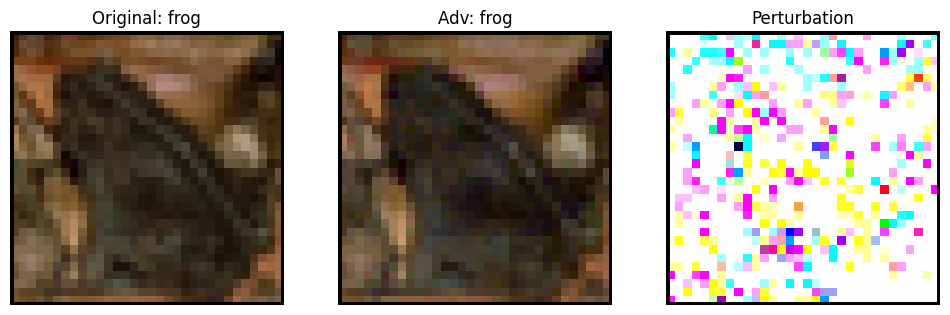

Sample 31/100
Early stopping at iter 2: ensemble misclassification!


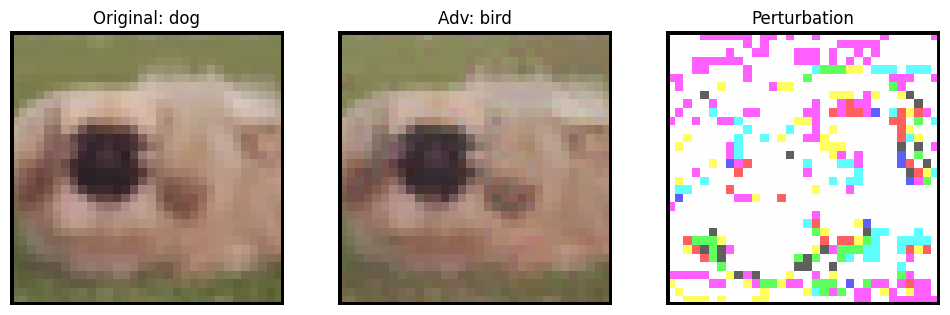

Sample 32/100
Early stopping at iter 0: ensemble misclassification!


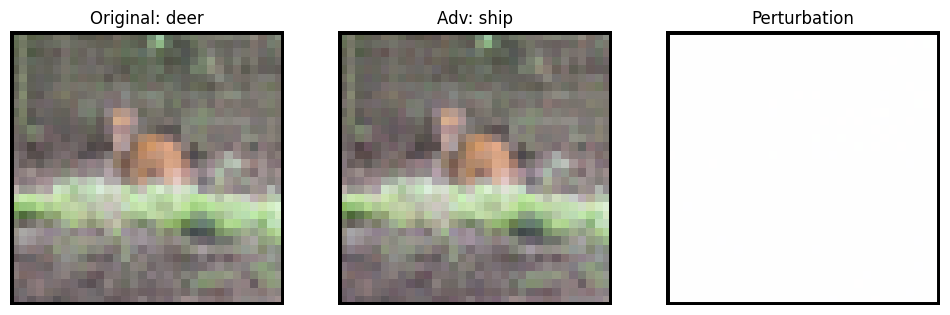

Sample 33/100
Early stopping at iter 14: ensemble misclassification!


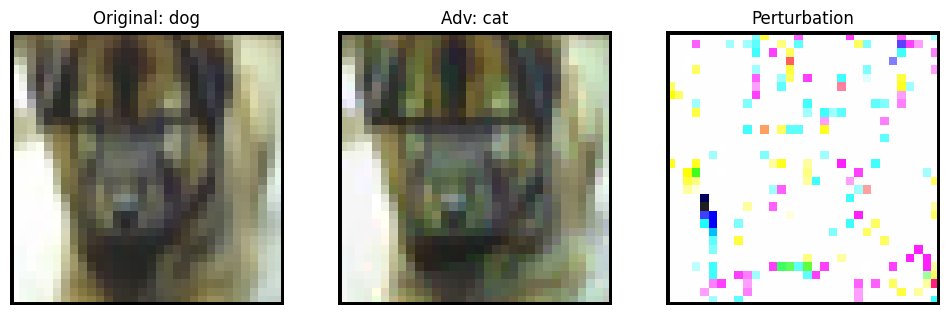

Sample 34/100


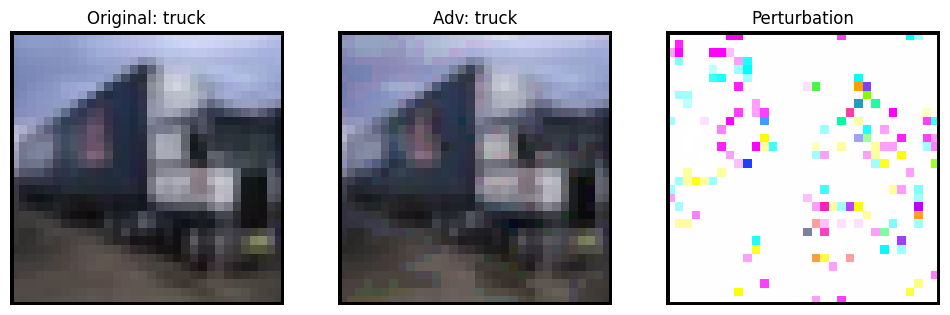

Sample 35/100
skipped element because y_pred=3 and y_true=tensor([2])
Sample 36/100
Early stopping at iter 4: ensemble misclassification!


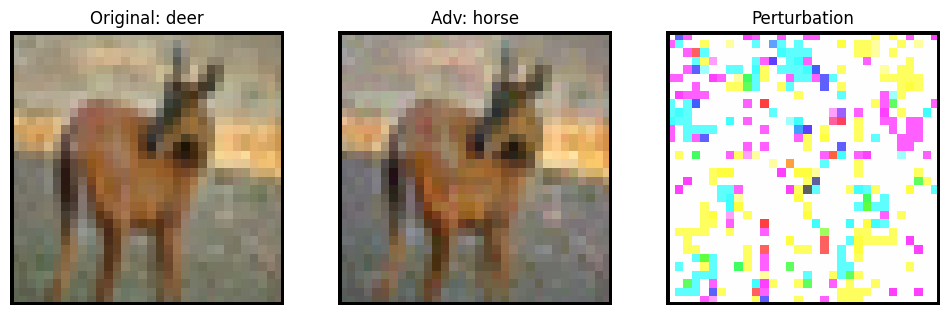

Sample 37/100
skipped element because y_pred=9 and y_true=tensor([1])
Sample 38/100


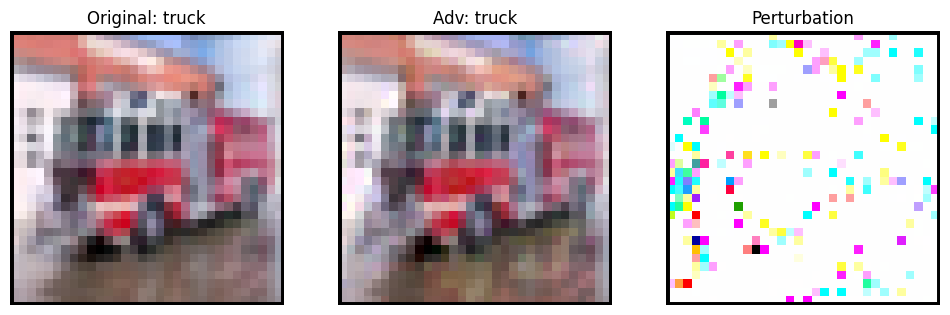

Sample 39/100


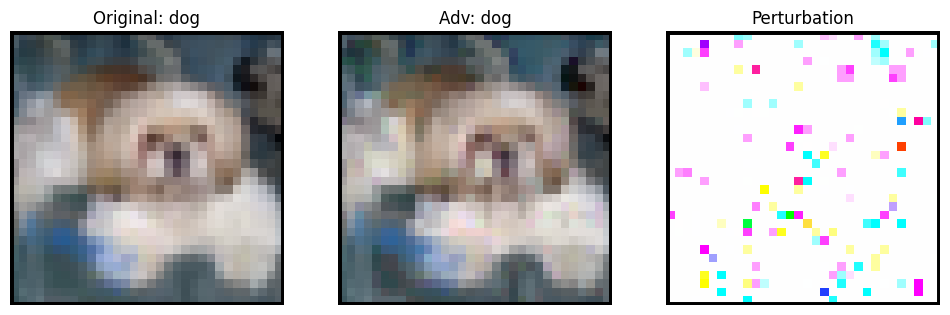

Sample 40/100


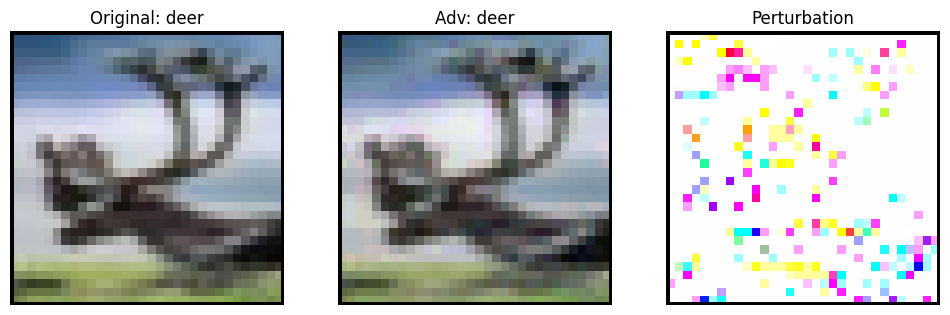

Sample 41/100


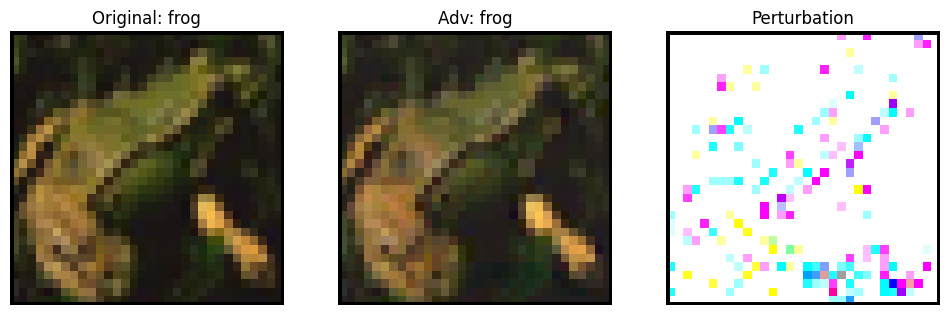

Sample 42/100


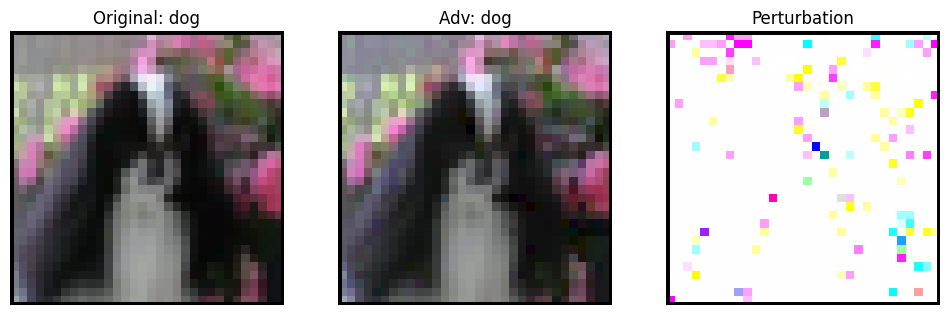

Sample 43/100


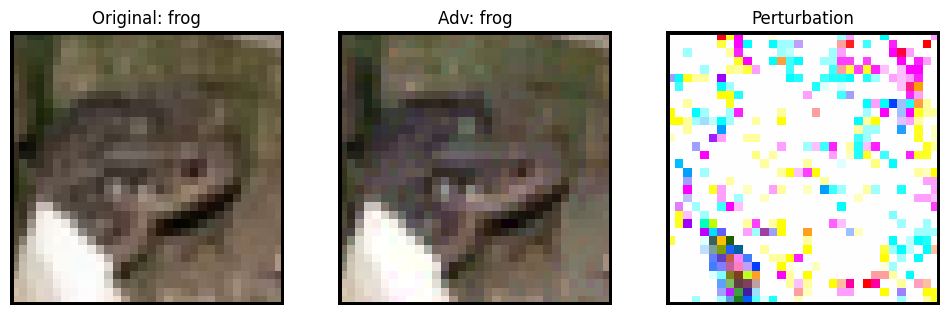

Sample 44/100
Early stopping at iter 4: ensemble misclassification!


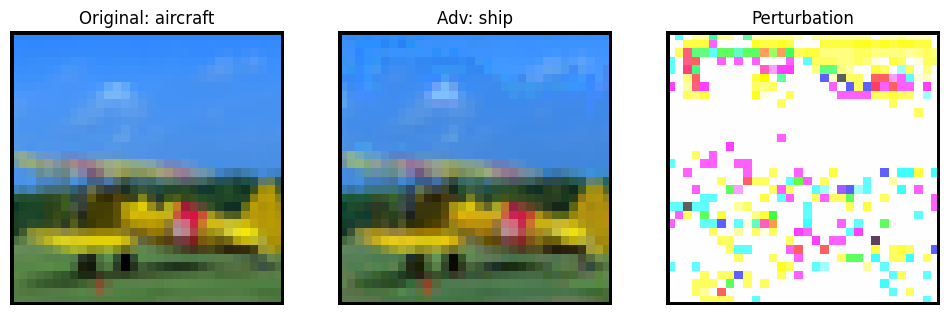

Sample 45/100


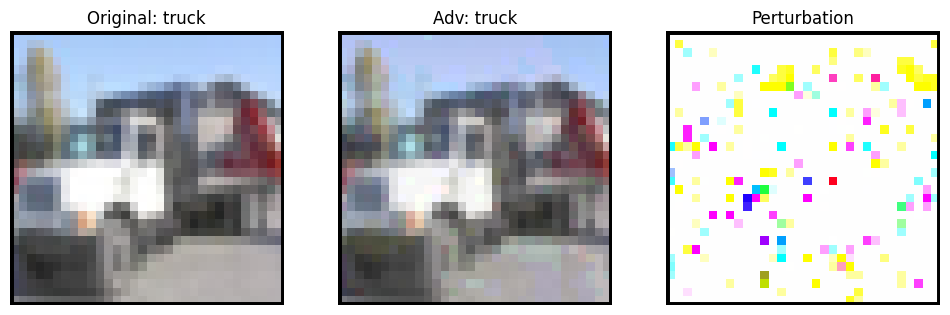

Sample 46/100


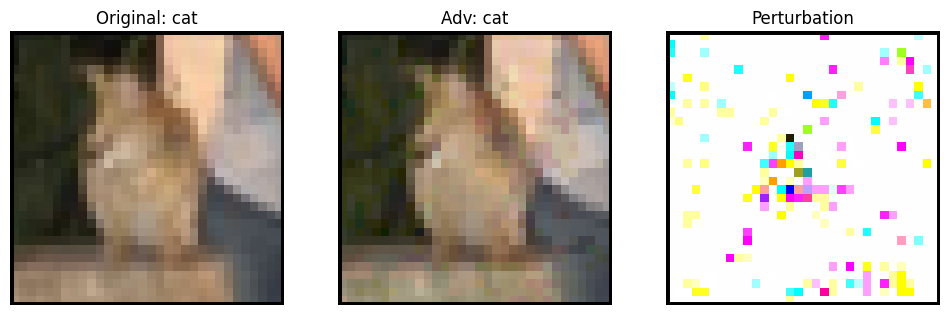

Sample 47/100
Early stopping at iter 0: ensemble misclassification!


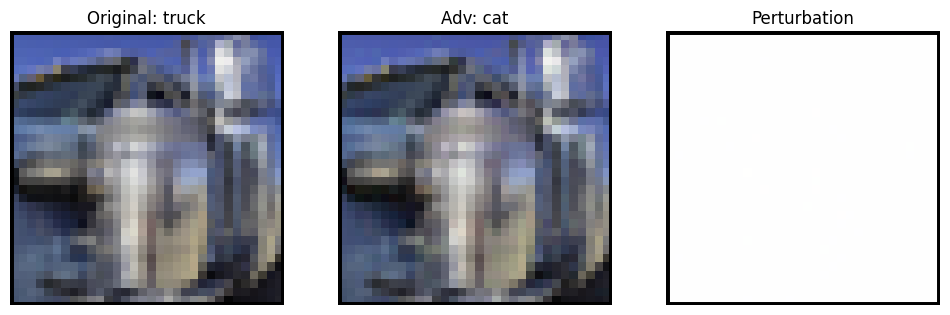

Sample 48/100
Early stopping at iter 0: ensemble misclassification!


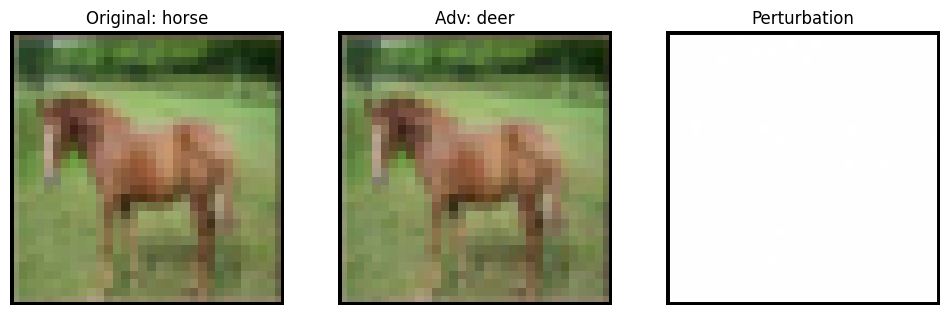

Sample 49/100
Early stopping at iter 1: ensemble misclassification!


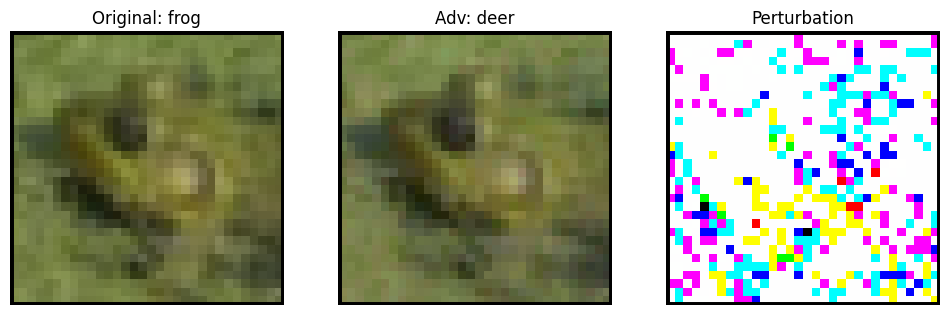

Sample 50/100


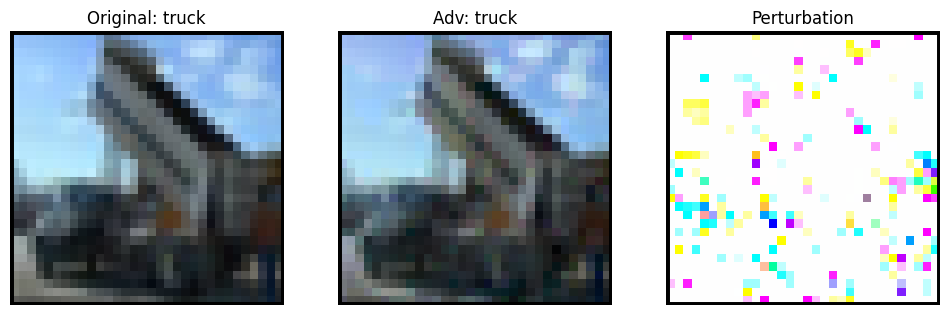

Sample 51/100


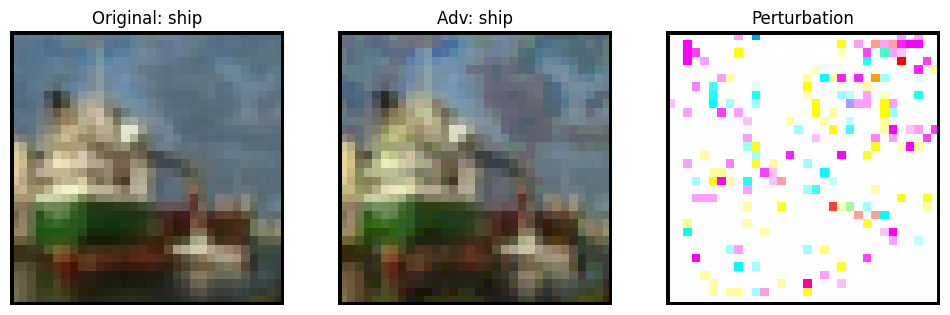

Sample 52/100
skipped element because y_pred=6 and y_true=tensor([0])
Sample 53/100
Early stopping at iter 1: ensemble misclassification!


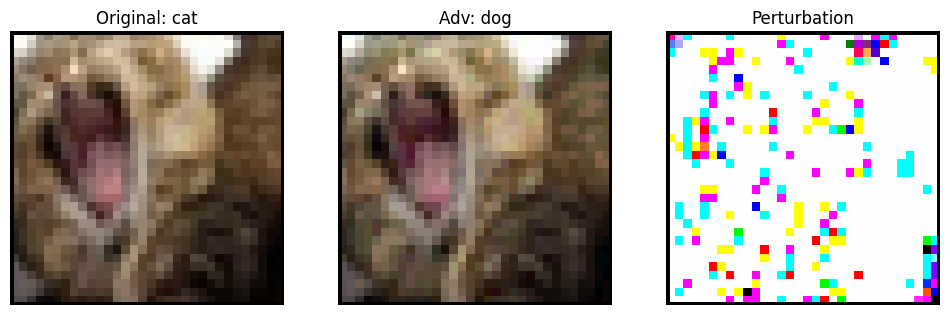

Sample 54/100


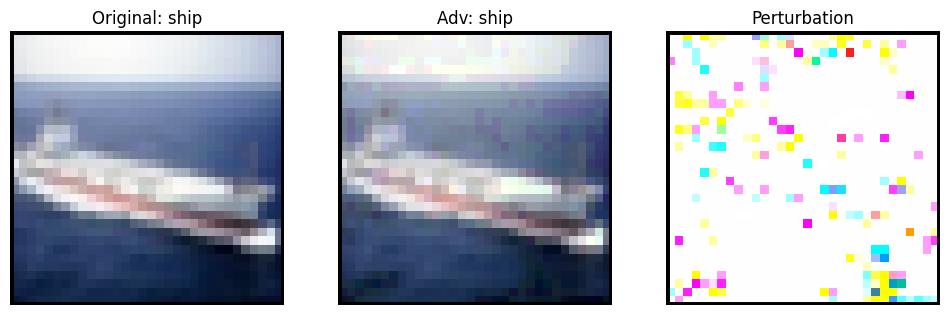

Sample 55/100


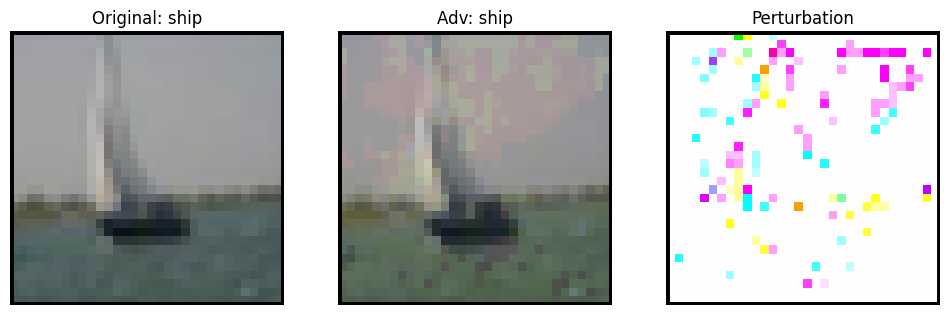

Sample 56/100
Early stopping at iter 0: ensemble misclassification!


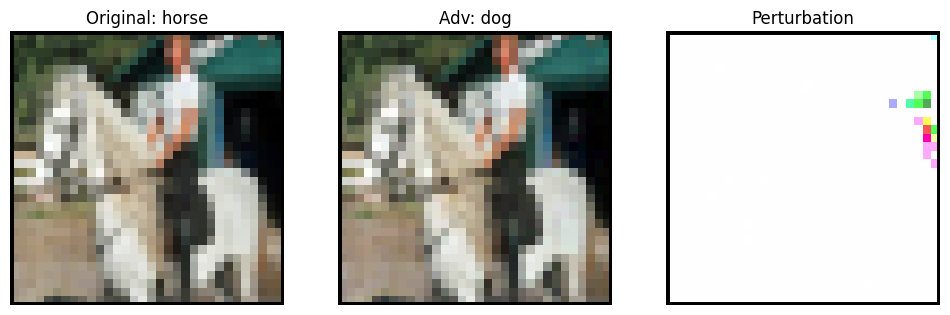

Sample 57/100
Early stopping at iter 0: ensemble misclassification!


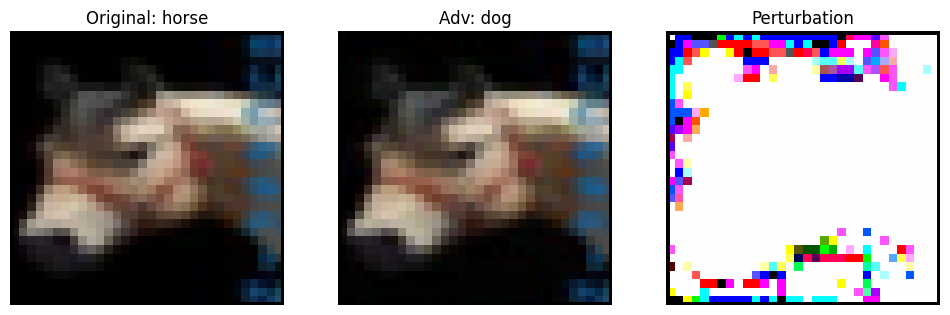

Sample 58/100
skipped element because y_pred=3 and y_true=tensor([4])
Sample 59/100
skipped element because y_pred=4 and y_true=tensor([6])
Sample 60/100


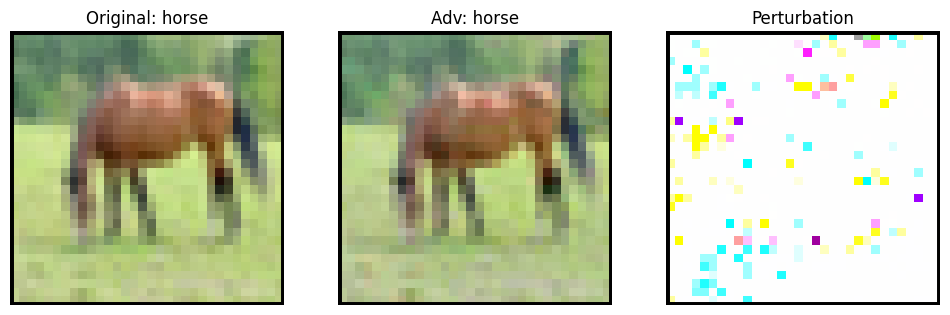

Sample 61/100
Early stopping at iter 2: ensemble misclassification!


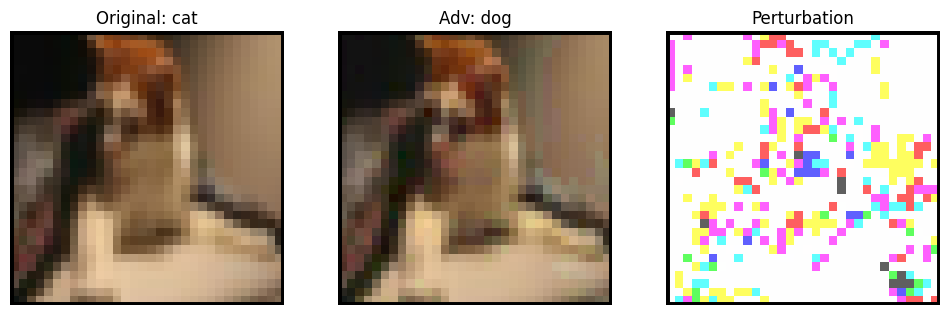

Sample 62/100


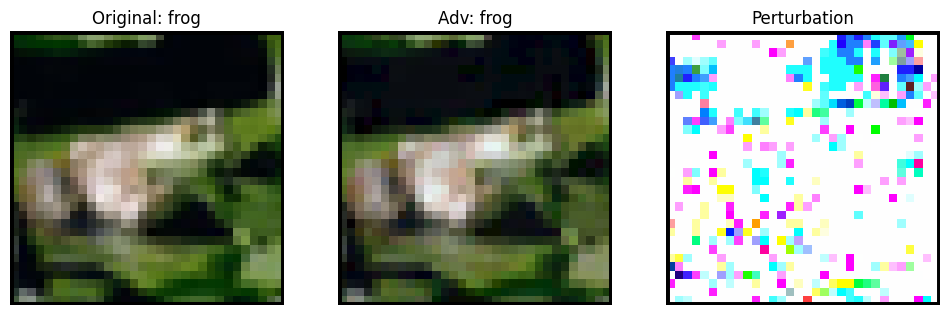

Sample 63/100
skipped element because y_pred=9 and y_true=tensor([3])
Sample 64/100


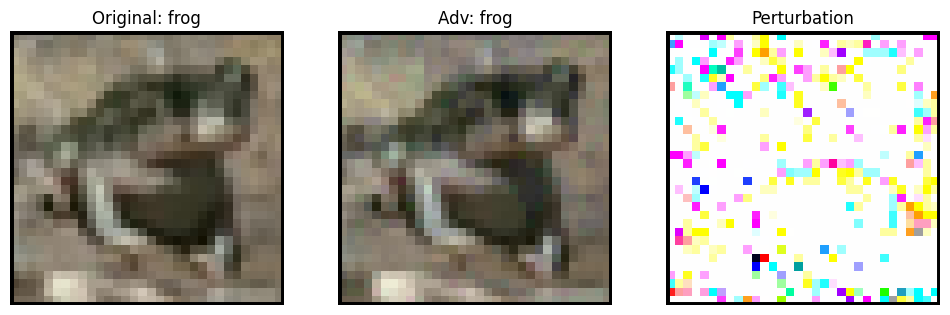

Sample 65/100
skipped element because y_pred=6 and y_true=tensor([2])
Sample 66/100


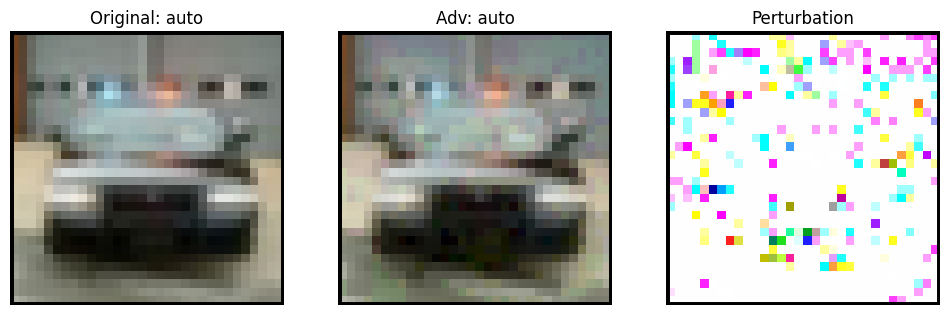

Sample 67/100


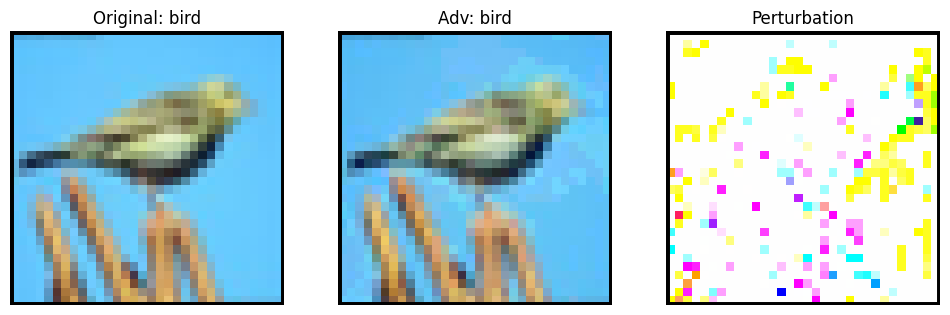

Sample 68/100


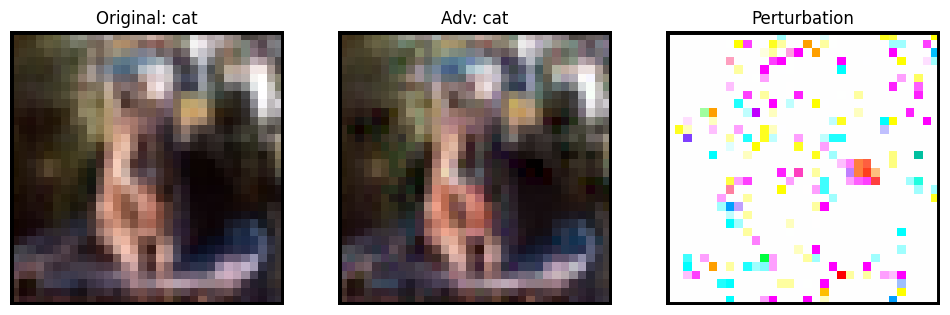

Sample 69/100
Early stopping at iter 0: ensemble misclassification!


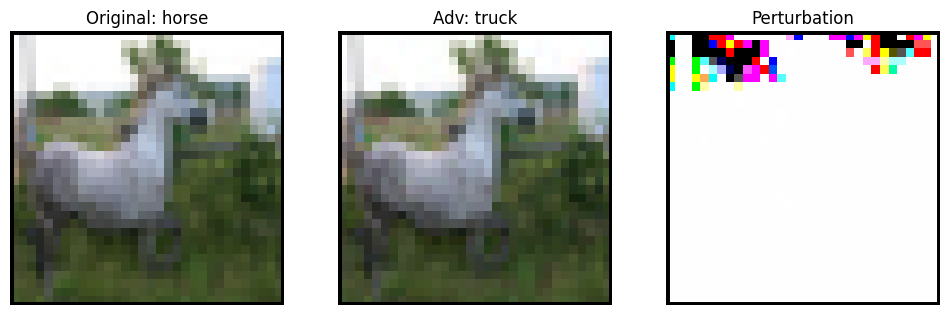

Sample 70/100
Early stopping at iter 0: ensemble misclassification!


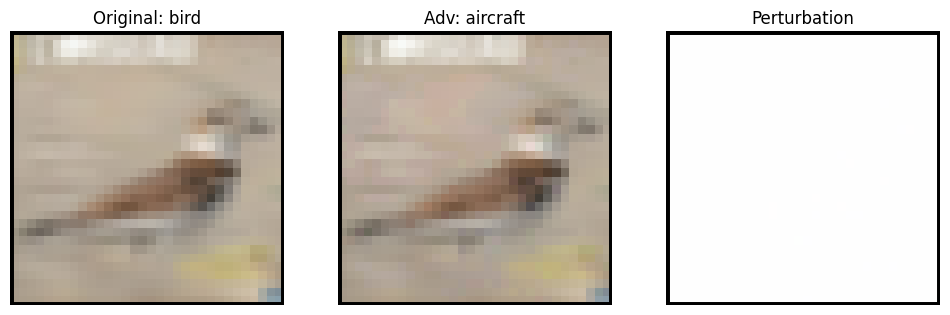

Sample 71/100


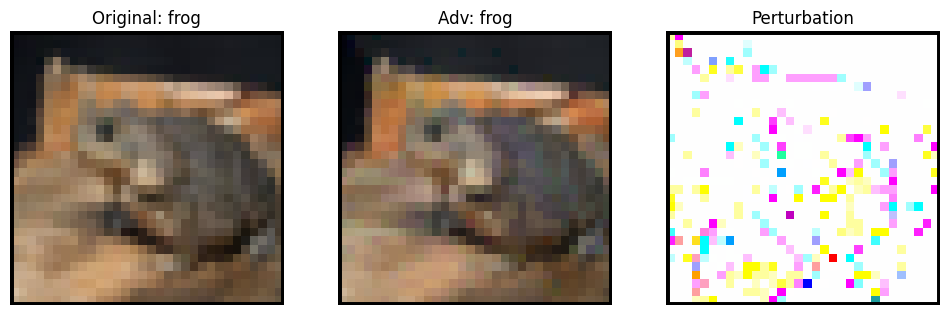

Sample 72/100


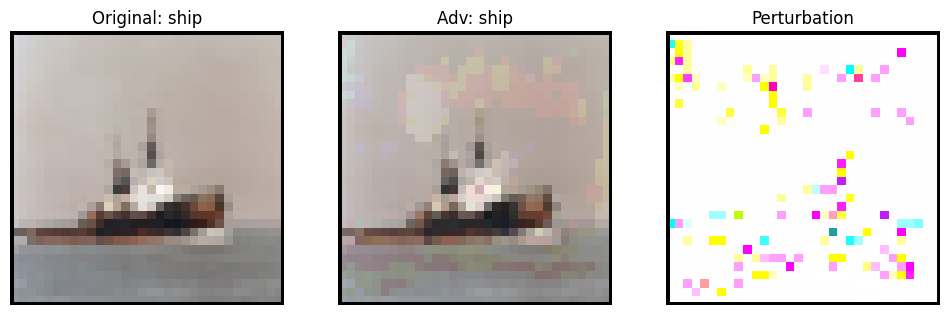

Sample 73/100


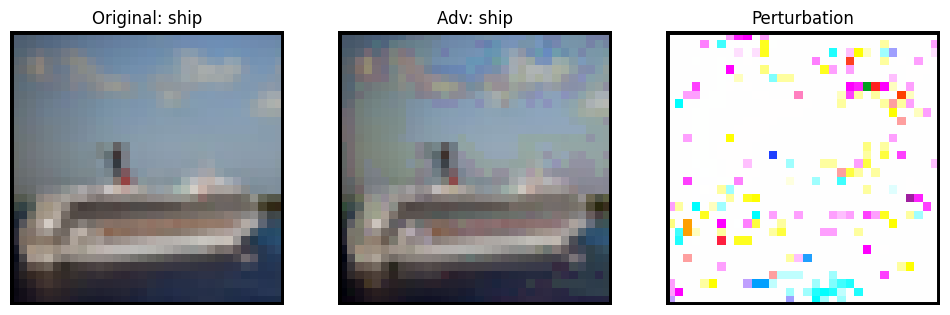

Sample 74/100
Early stopping at iter 2: ensemble misclassification!


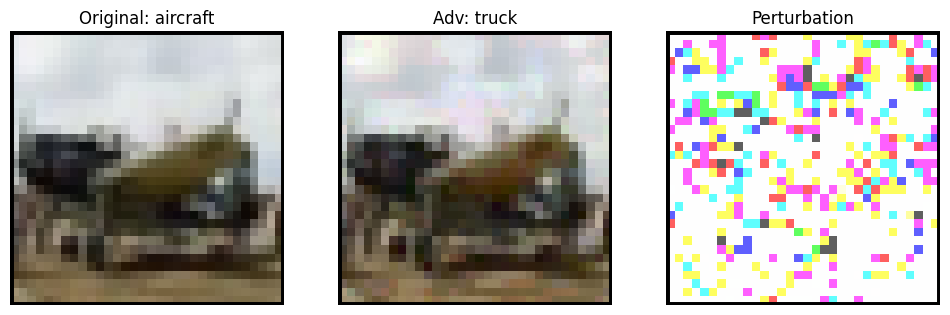

Sample 75/100


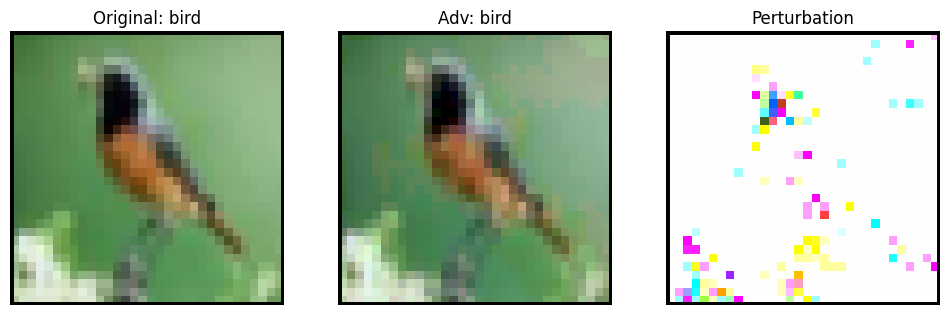

Sample 76/100


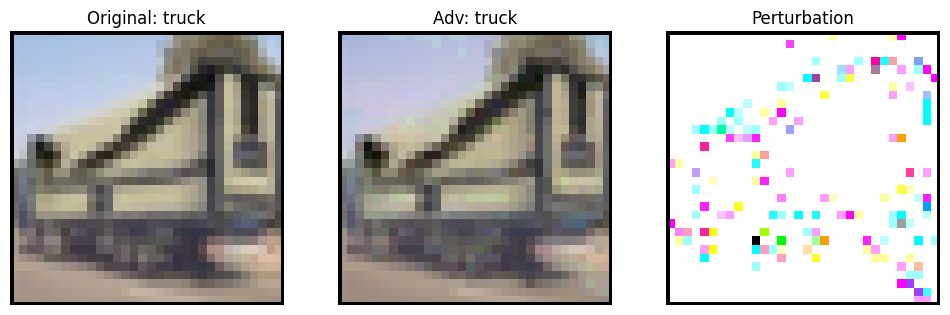

Sample 77/100
Early stopping at iter 1: ensemble misclassification!


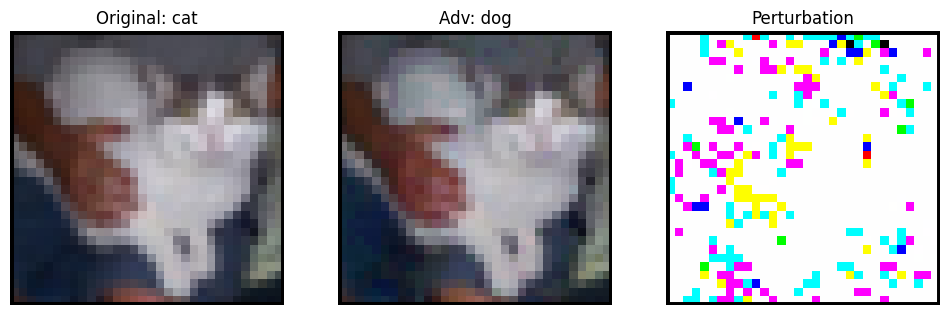

Sample 78/100


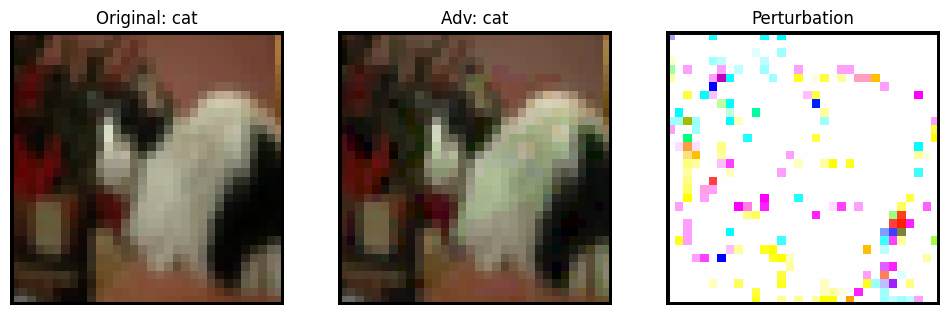

Sample 79/100


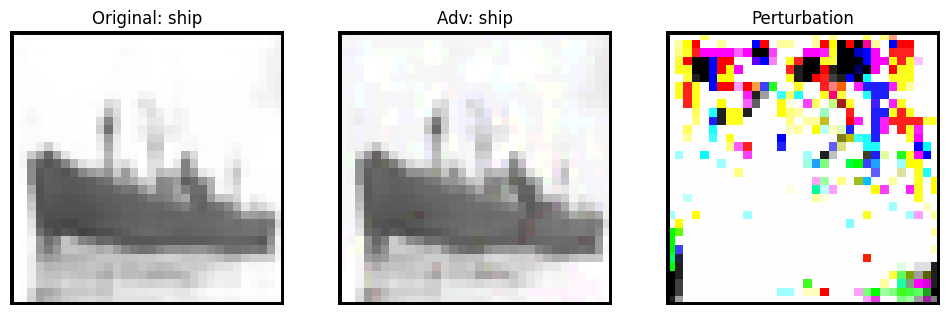

Sample 80/100


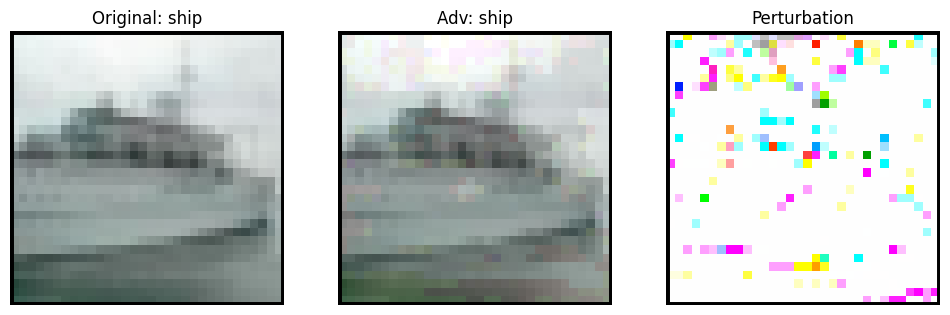

Sample 81/100


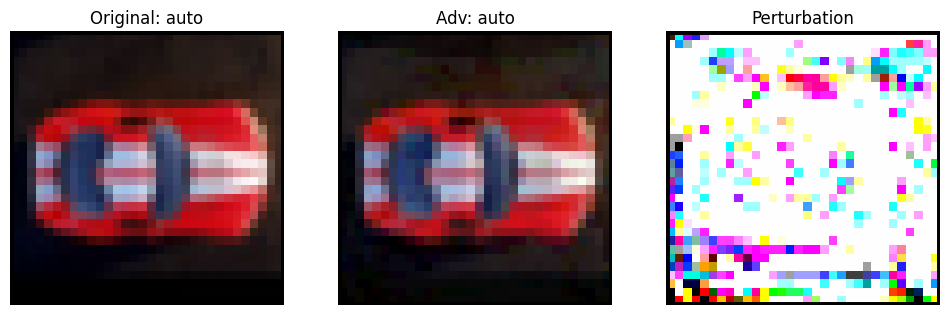

Sample 82/100


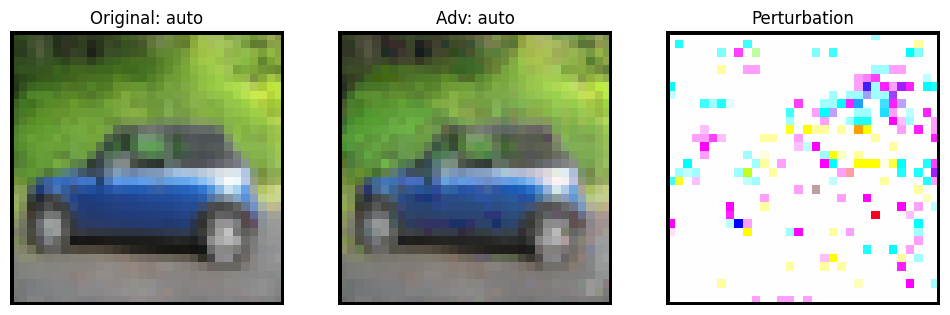

Sample 83/100


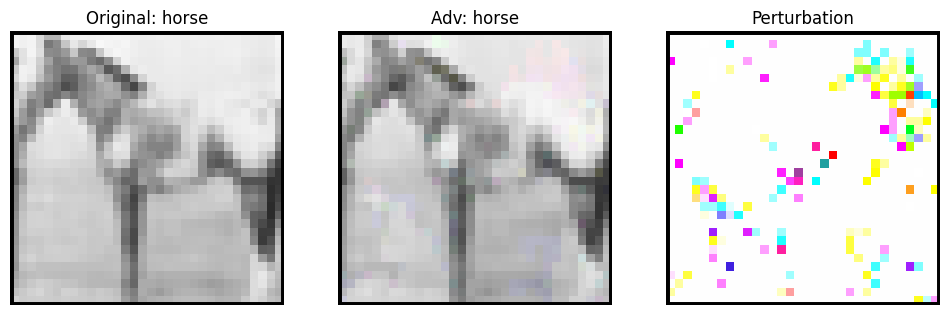

Sample 84/100


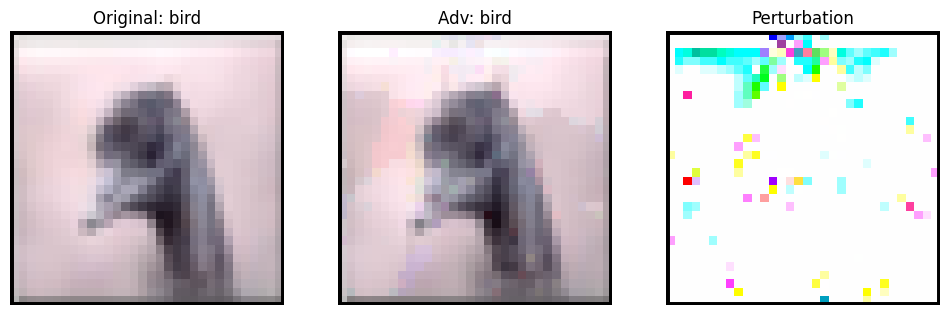

Sample 85/100
skipped element because y_pred=7 and y_true=tensor([5])
Sample 86/100


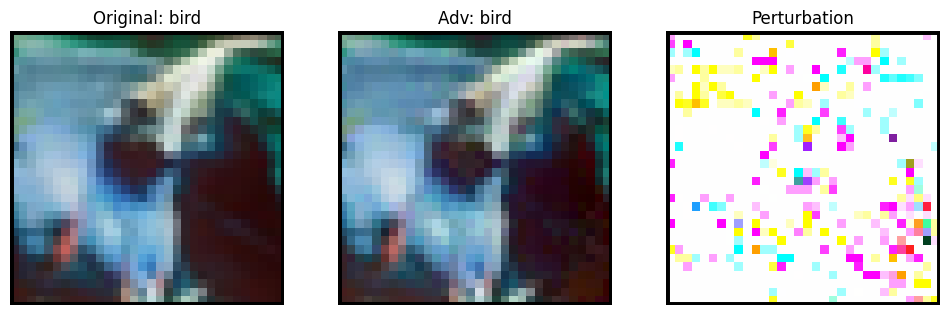

Sample 87/100
skipped element because y_pred=8 and y_true=tensor([7])
Sample 88/100


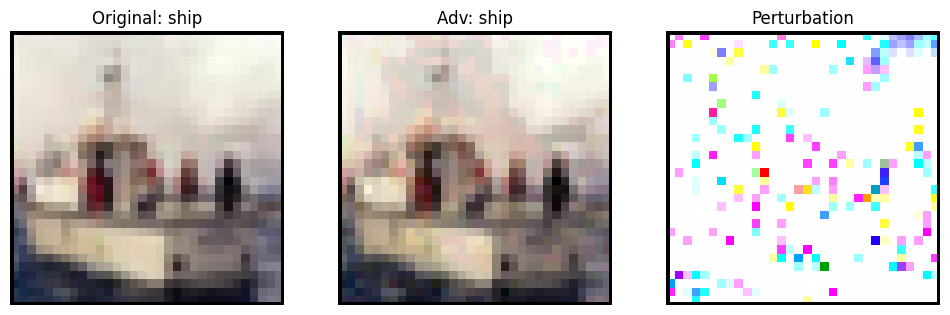

Sample 89/100


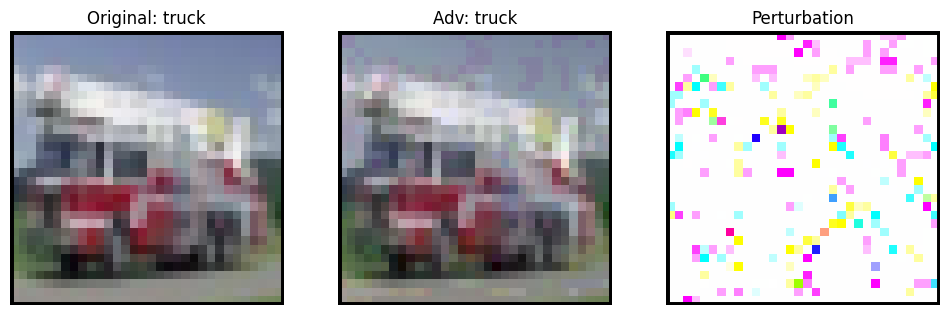

Sample 90/100


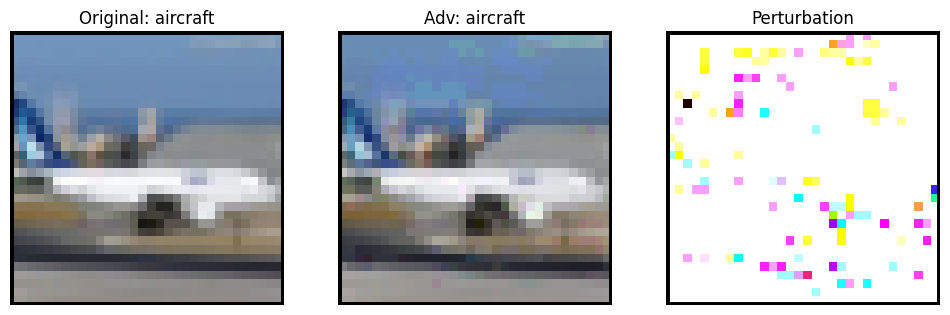

Sample 91/100
skipped element because y_pred=4 and y_true=tensor([3])
Sample 92/100


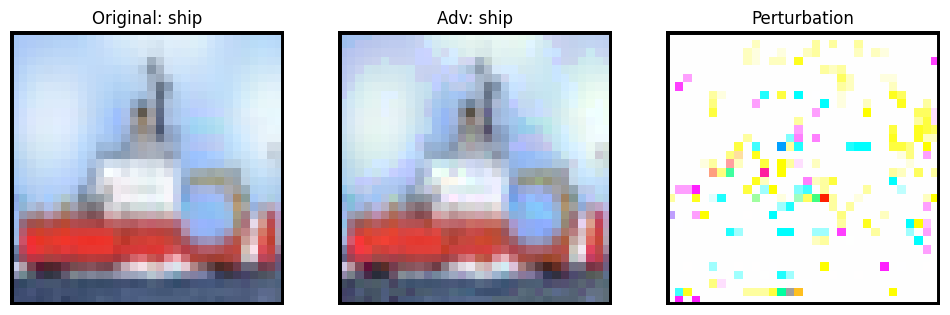

Sample 93/100


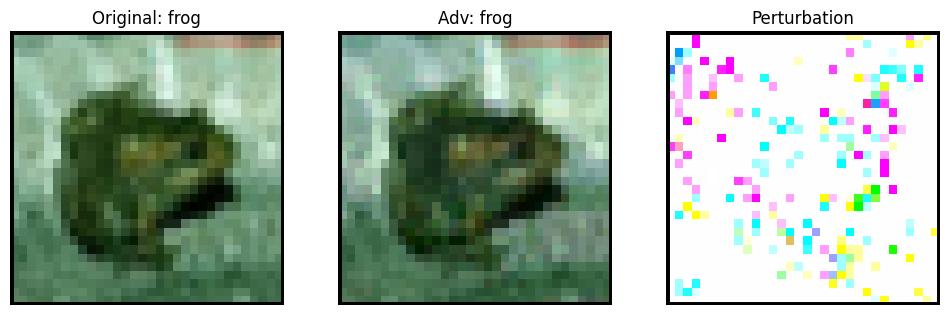

Sample 94/100


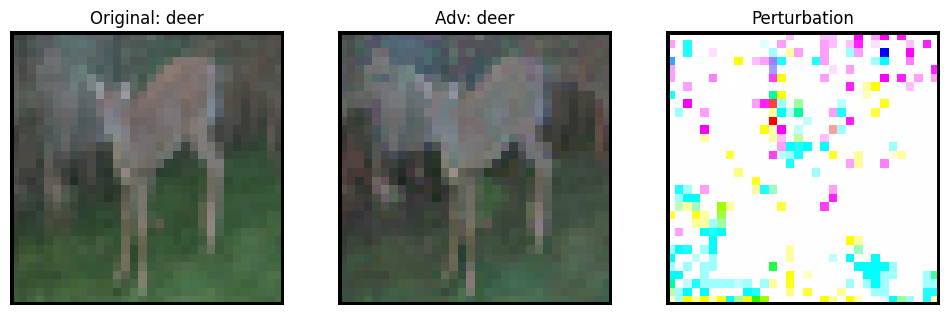

Sample 95/100


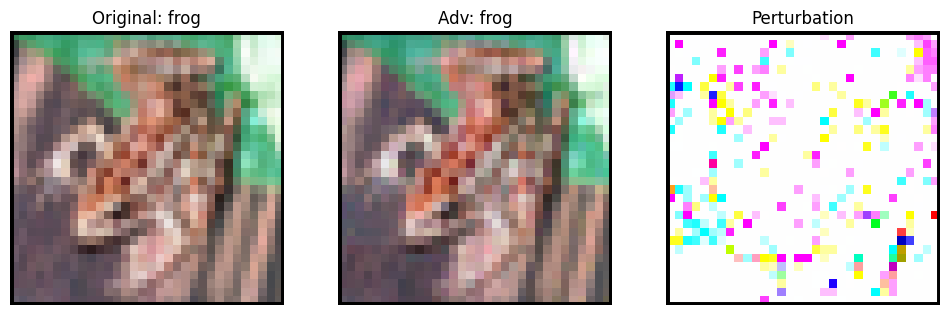

Sample 96/100


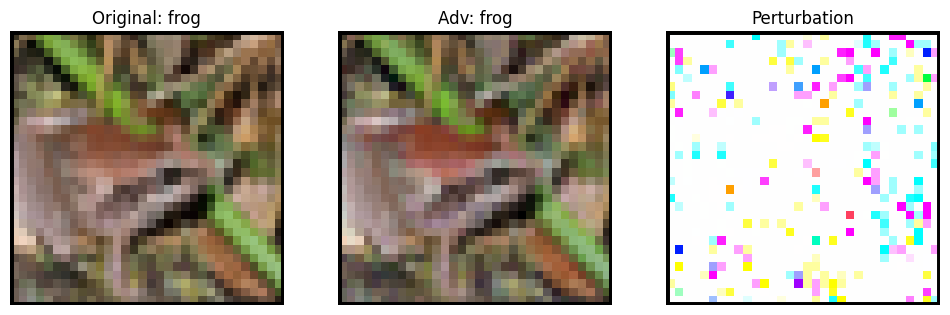

Sample 97/100


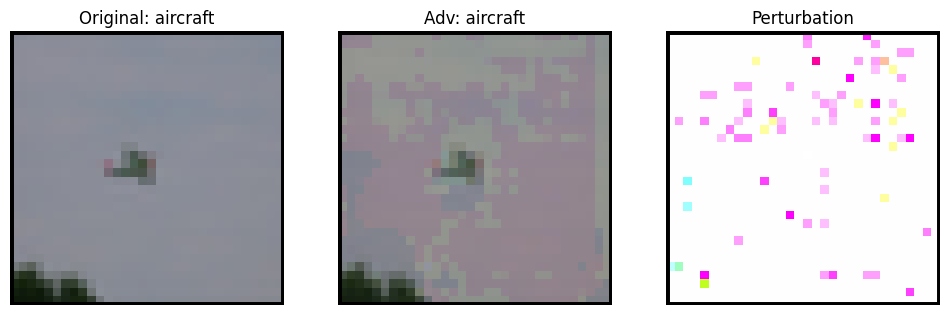

Sample 98/100


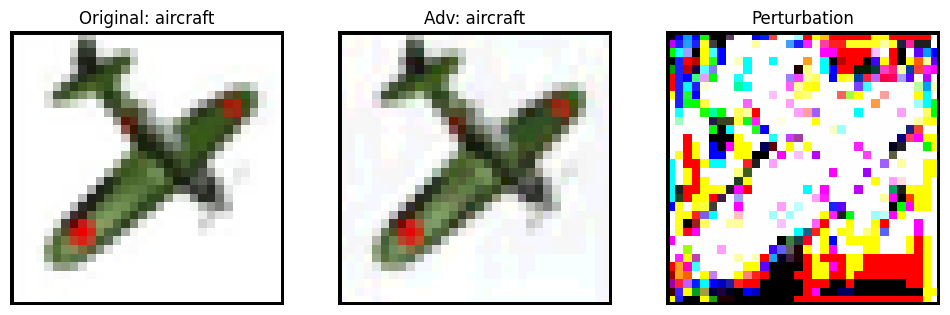

Sample 99/100


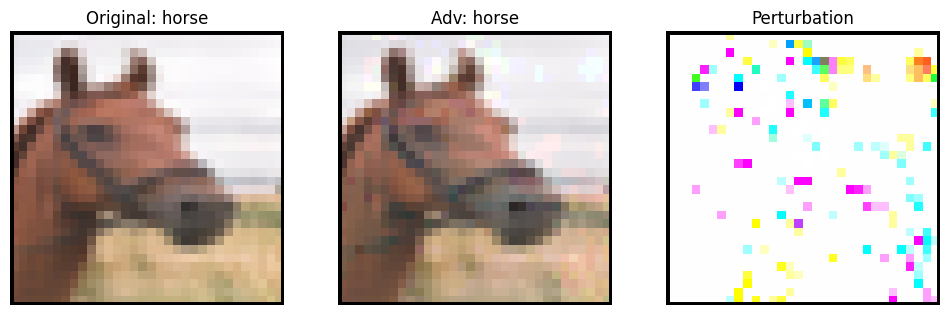

FINISHED. Computed n.19 adversarial examples, skipped n.13 samples
Sample 0/100


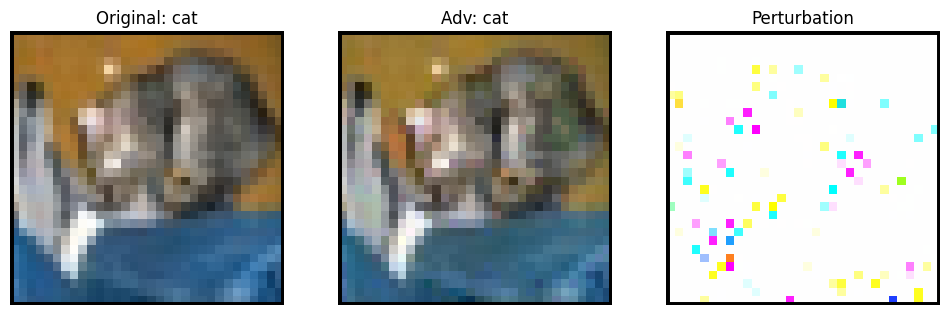

Sample 1/100


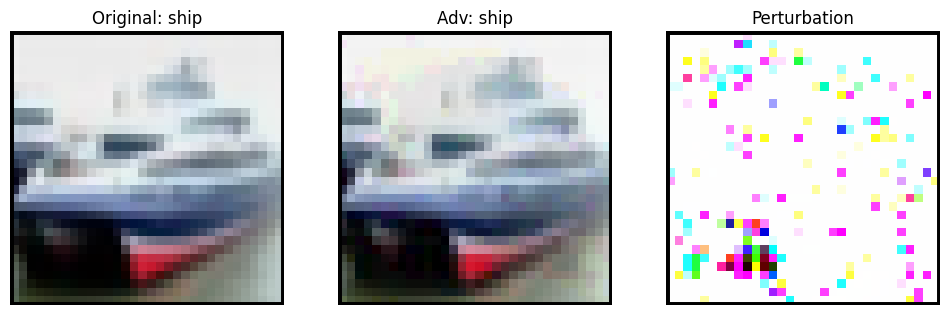

Sample 2/100
Early stopping at iter 2: ensemble misclassification!


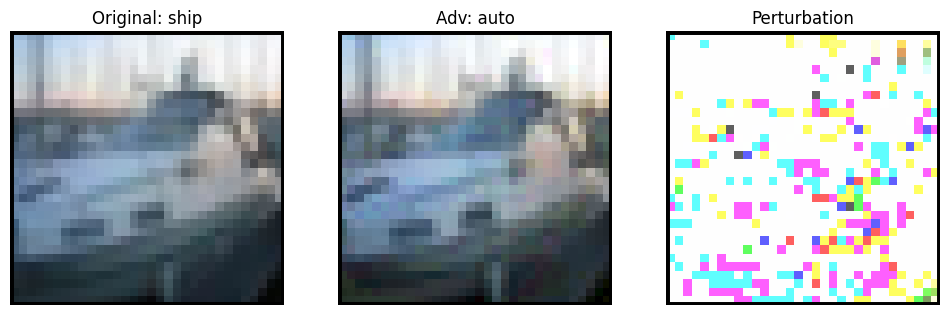

Sample 3/100


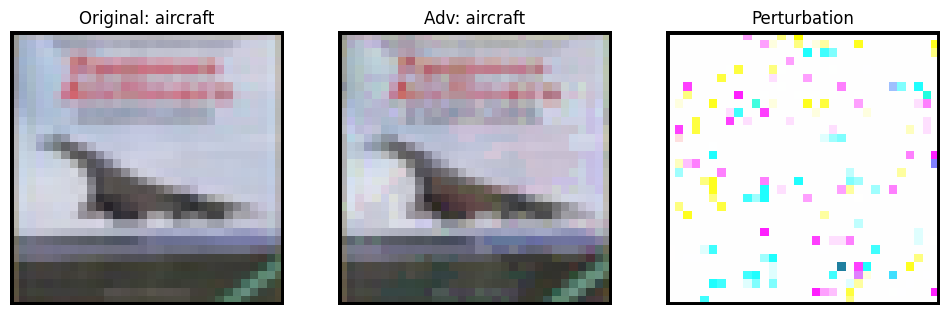

Sample 4/100


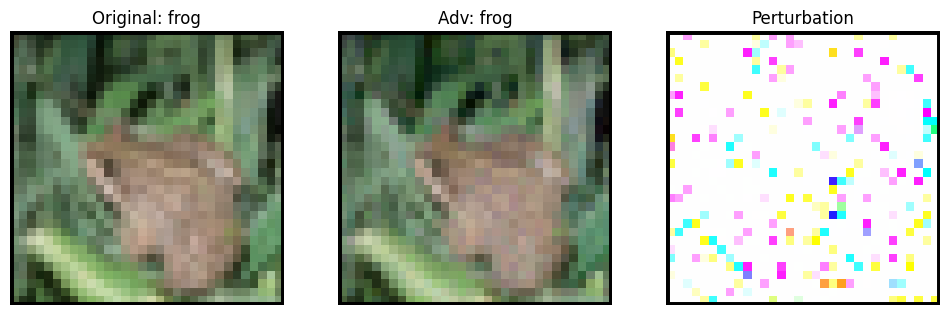

Sample 5/100


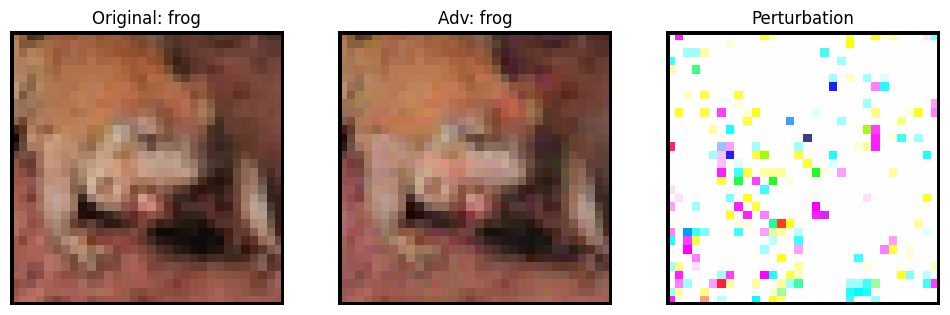

Sample 6/100
Early stopping at iter 2: ensemble misclassification!


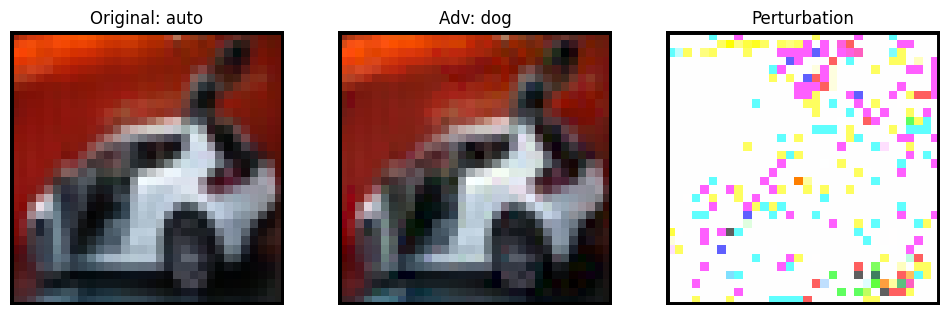

Sample 7/100
Early stopping at iter 0: ensemble misclassification!


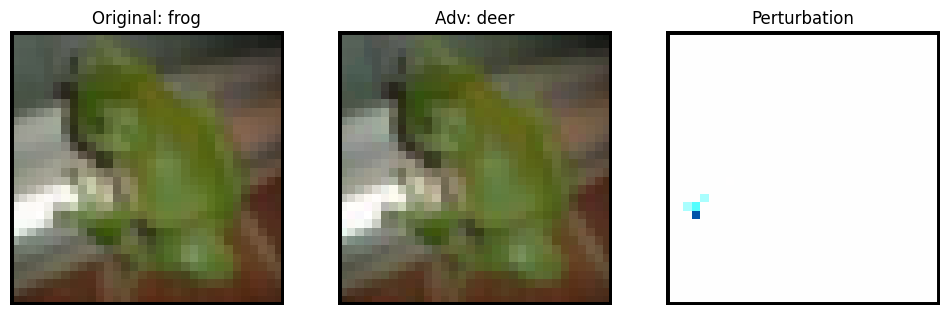

Sample 8/100
Early stopping at iter 1: ensemble misclassification!


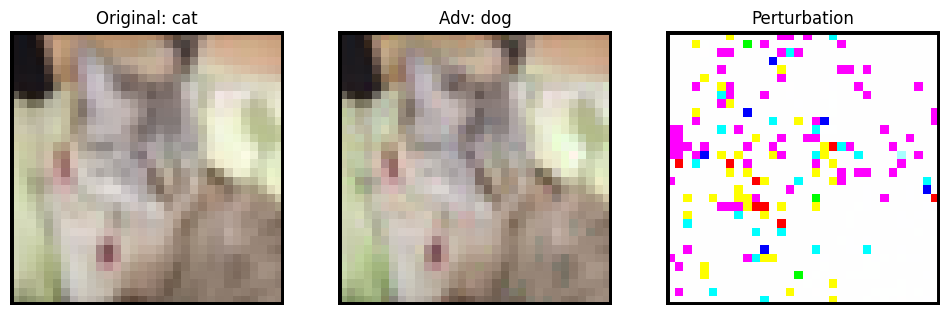

Sample 9/100
Early stopping at iter 0: ensemble misclassification!


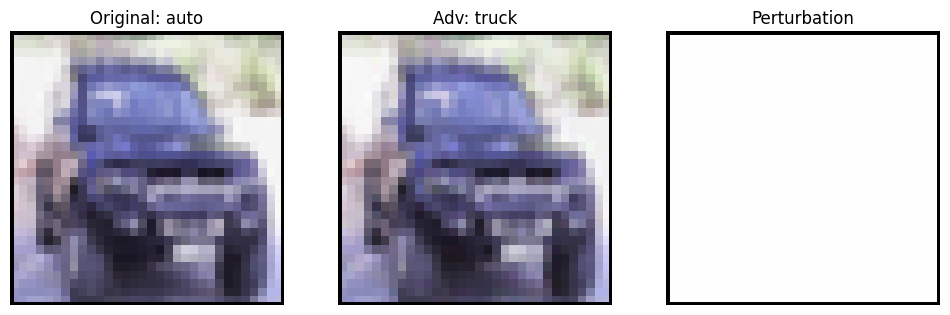

Sample 10/100


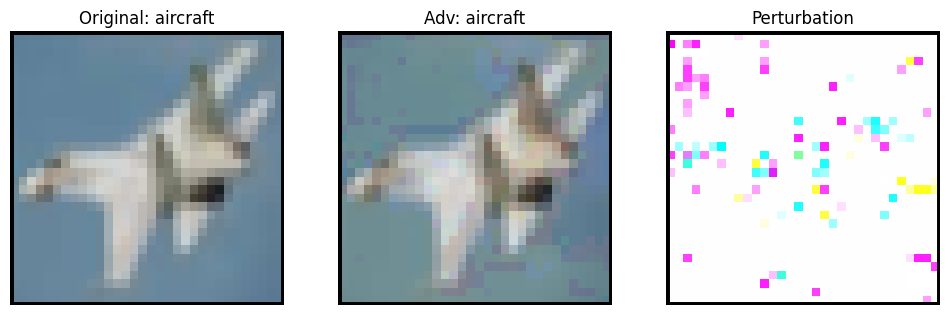

Sample 11/100


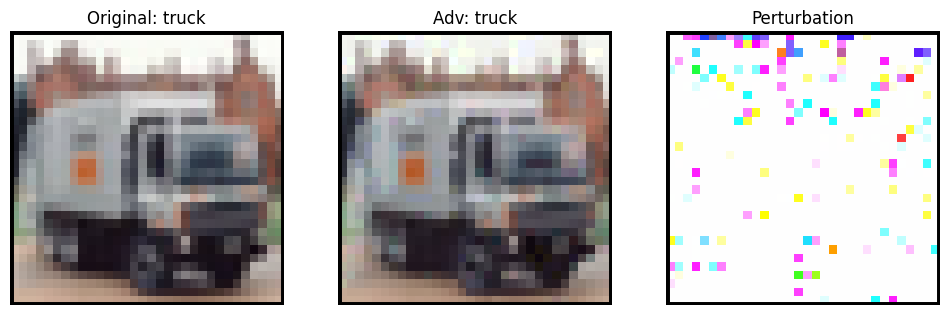

Sample 12/100
skipped element because y_pred=4 and y_true=tensor([5])
Sample 13/100


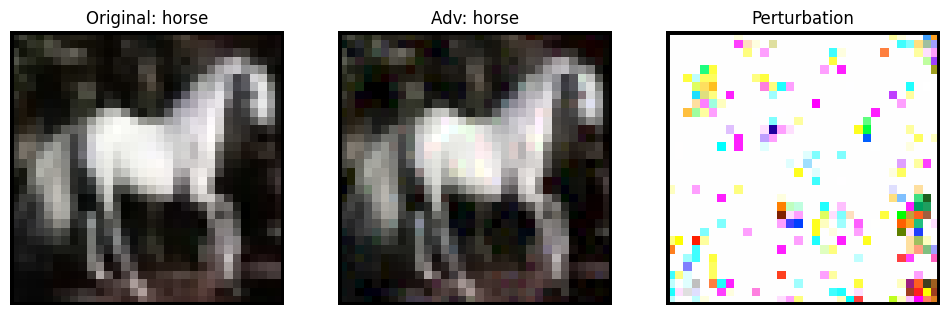

Sample 14/100


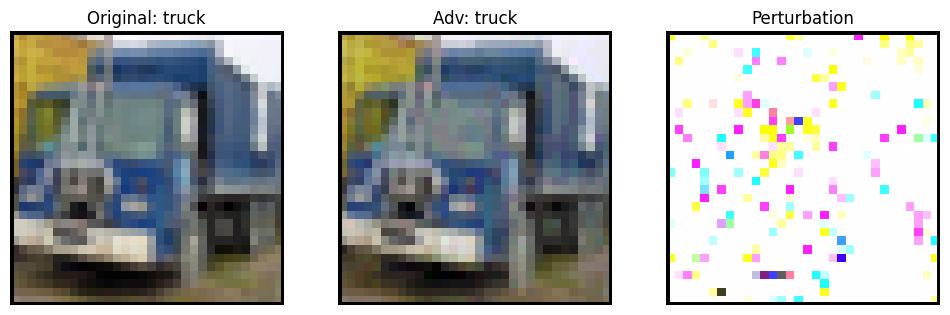

Sample 15/100


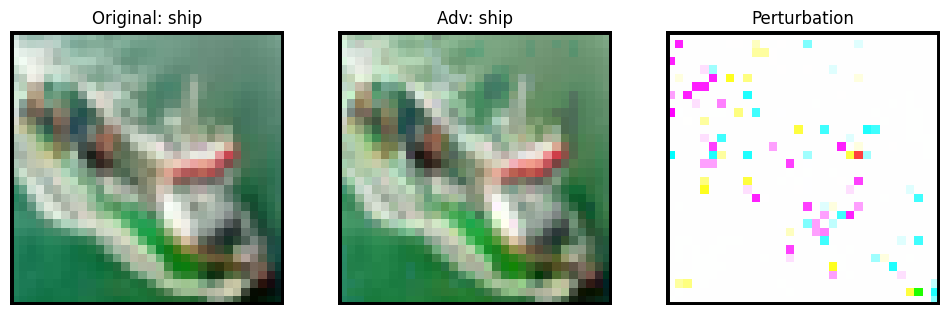

Sample 16/100


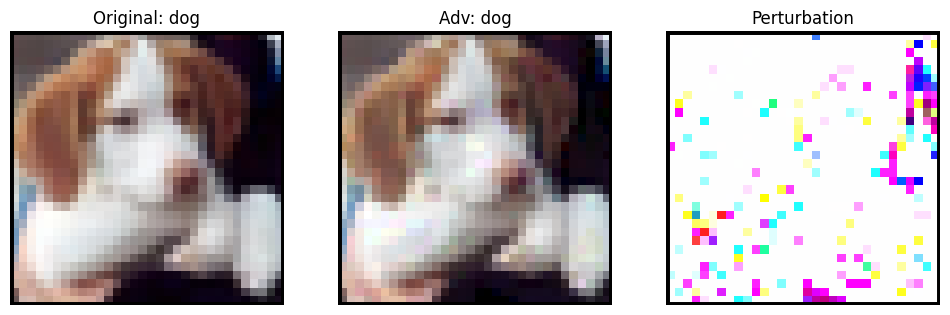

Sample 17/100


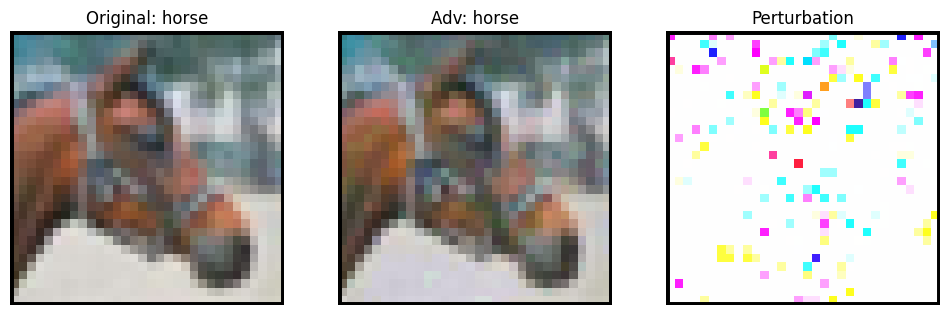

Sample 18/100


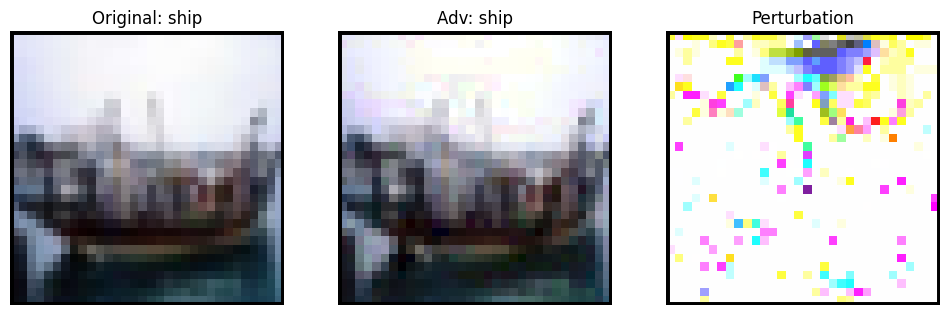

Sample 19/100


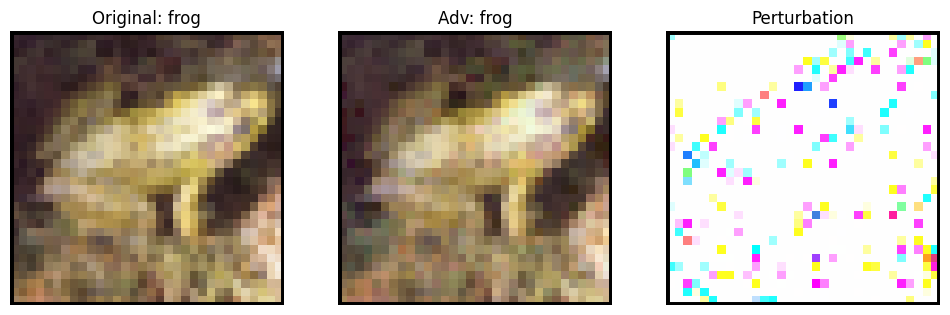

Sample 20/100


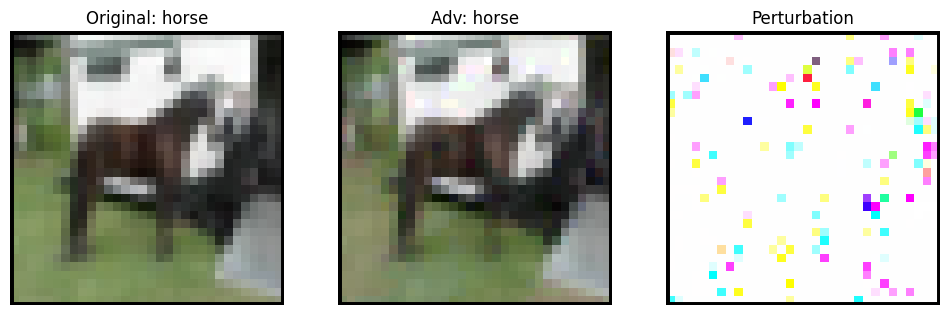

Sample 21/100


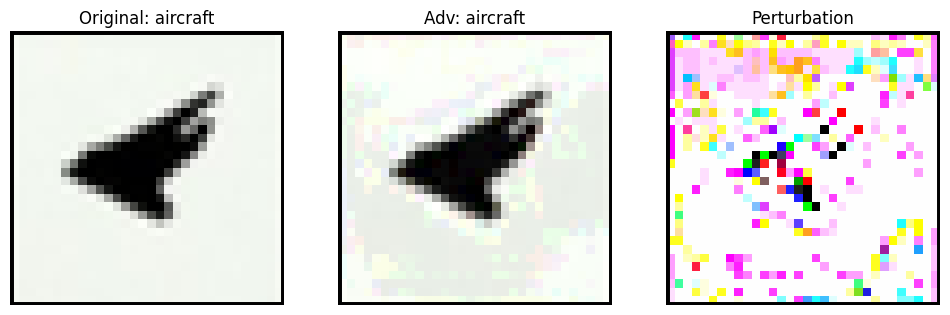

Sample 22/100
skipped element because y_pred=0 and y_true=tensor([4])
Sample 23/100


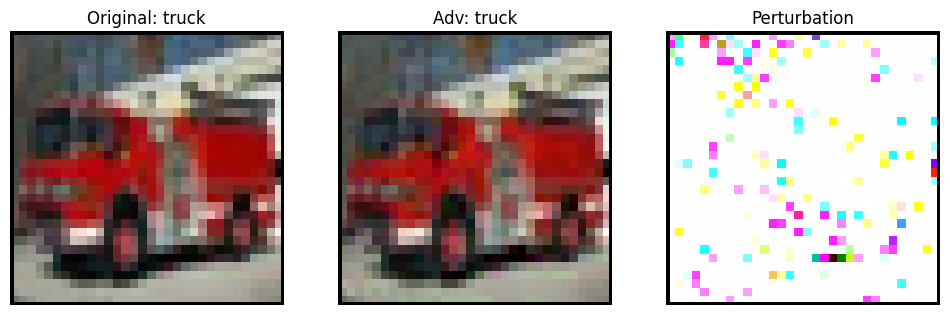

Sample 24/100
skipped element because y_pred=4 and y_true=tensor([5])
Sample 25/100


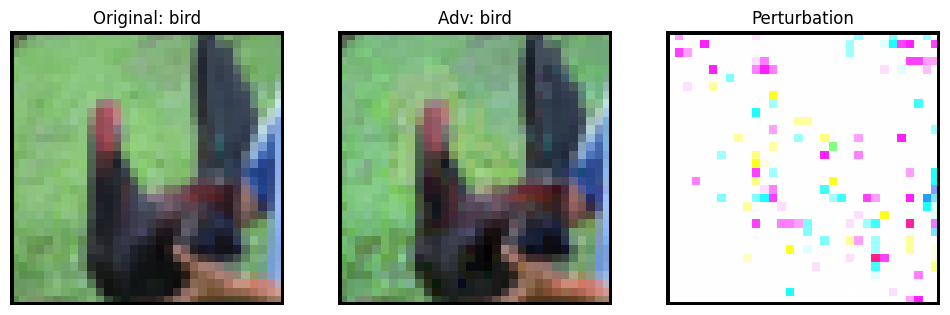

Sample 26/100
Early stopping at iter 2: ensemble misclassification!


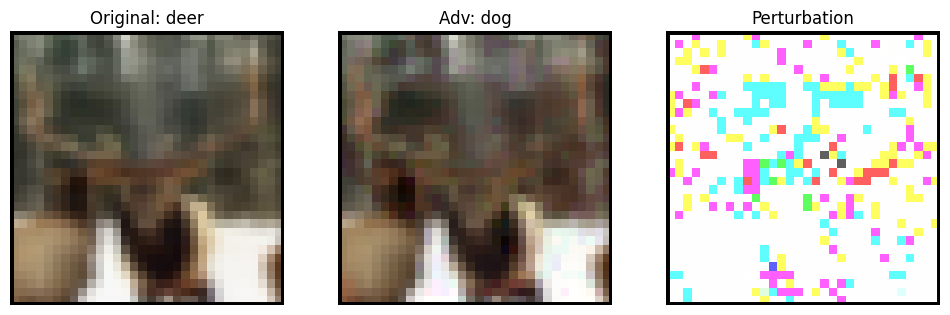

Sample 27/100


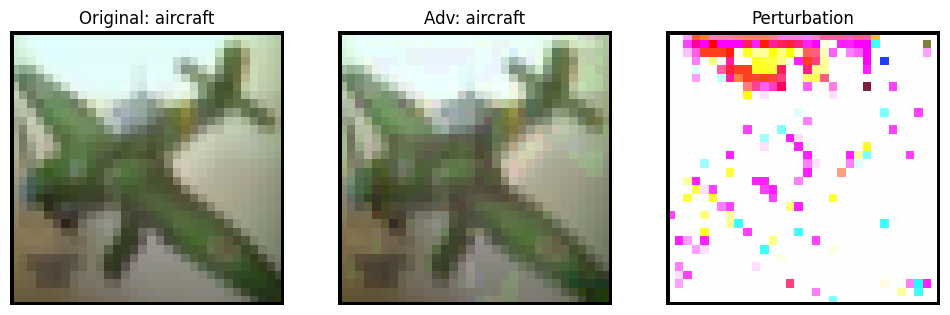

Sample 28/100


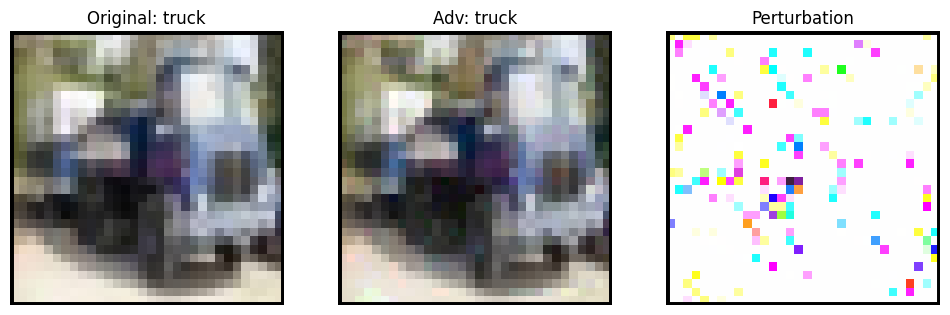

Sample 29/100


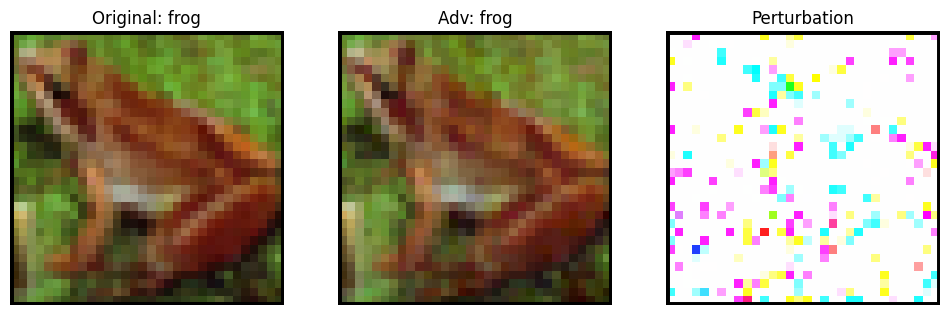

Sample 30/100


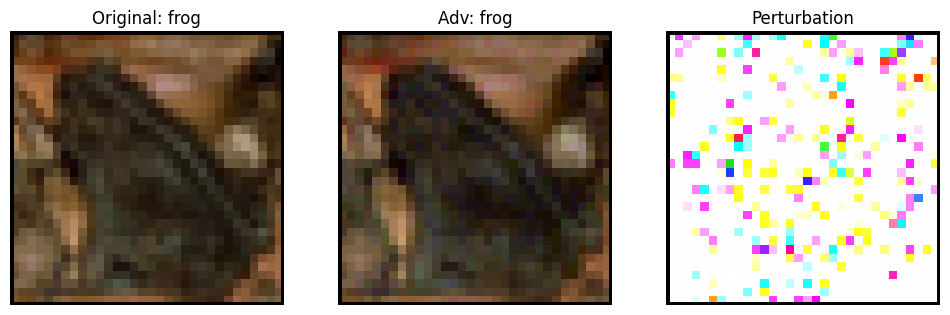

Sample 31/100
Early stopping at iter 1: ensemble misclassification!


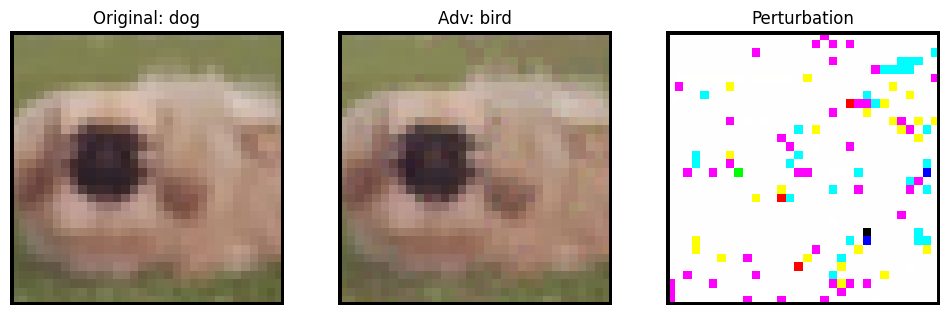

Sample 32/100
Early stopping at iter 0: ensemble misclassification!


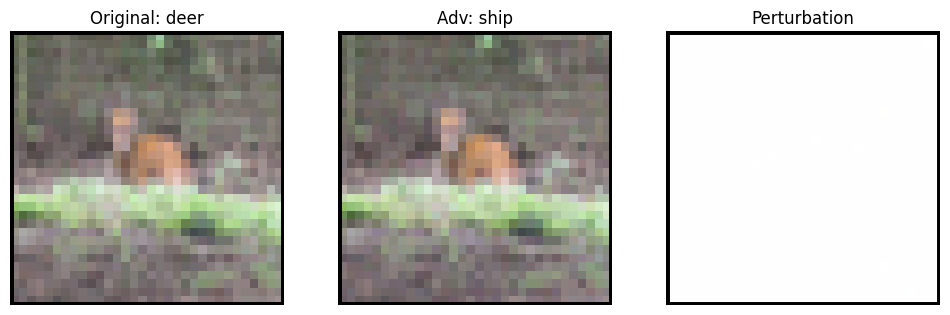

Sample 33/100
Early stopping at iter 1: ensemble misclassification!


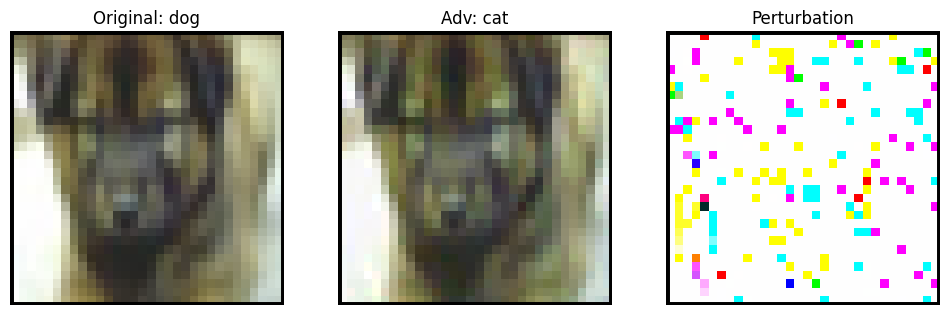

Sample 34/100


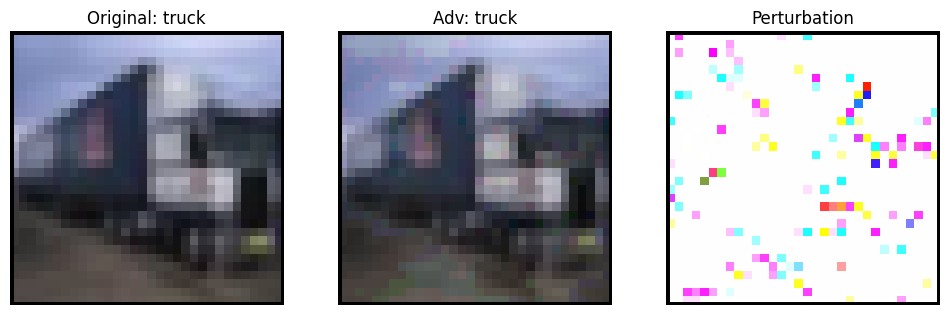

Sample 35/100
skipped element because y_pred=3 and y_true=tensor([2])
Sample 36/100
Early stopping at iter 1: ensemble misclassification!


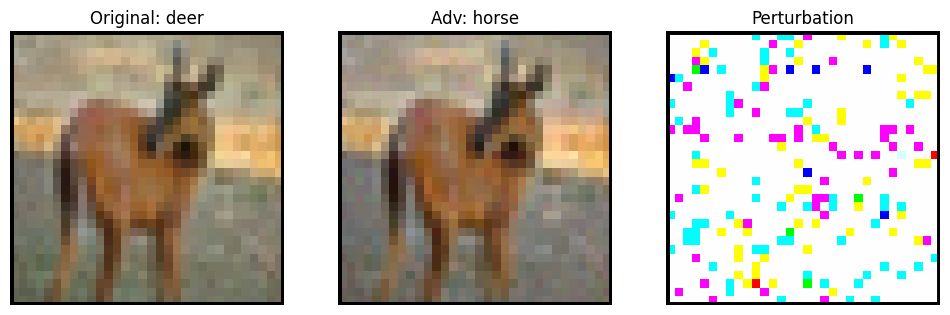

Sample 37/100
skipped element because y_pred=9 and y_true=tensor([1])
Sample 38/100


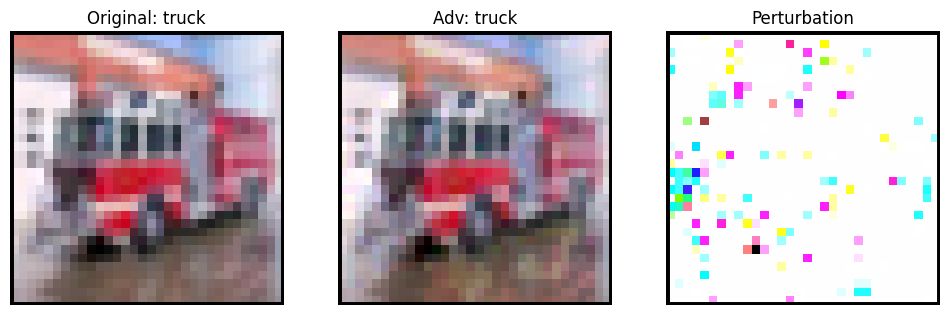

Sample 39/100


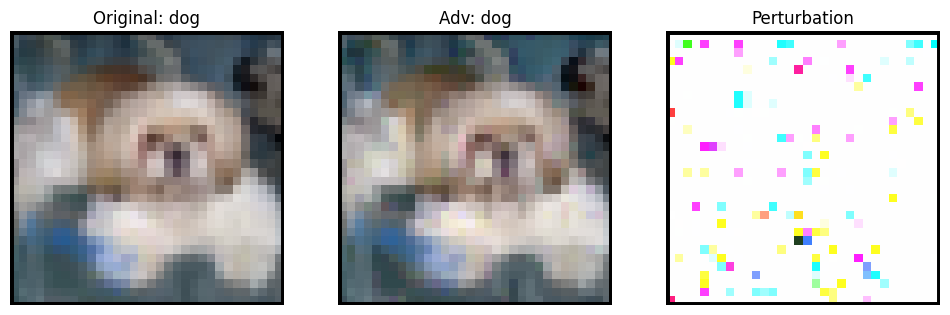

Sample 40/100


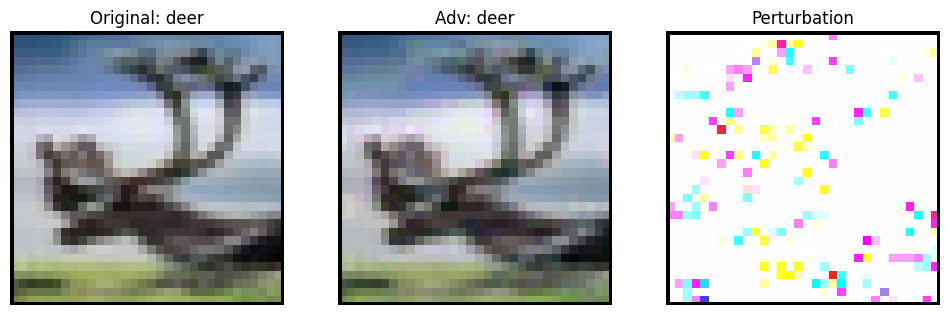

Sample 41/100


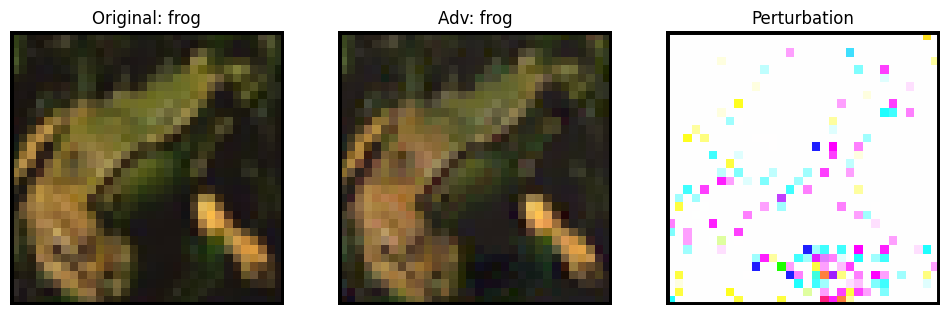

Sample 42/100


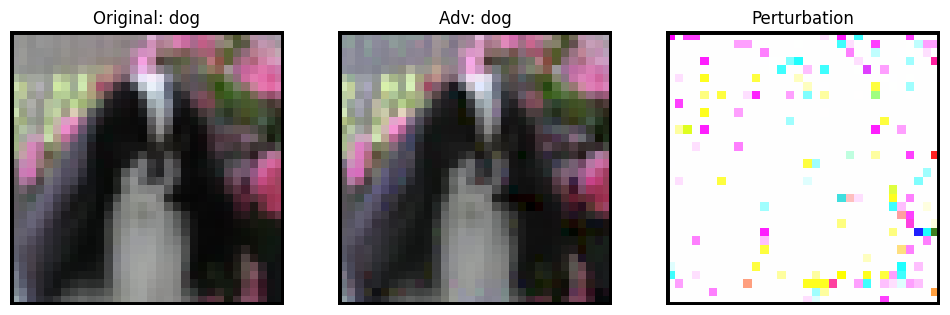

Sample 43/100


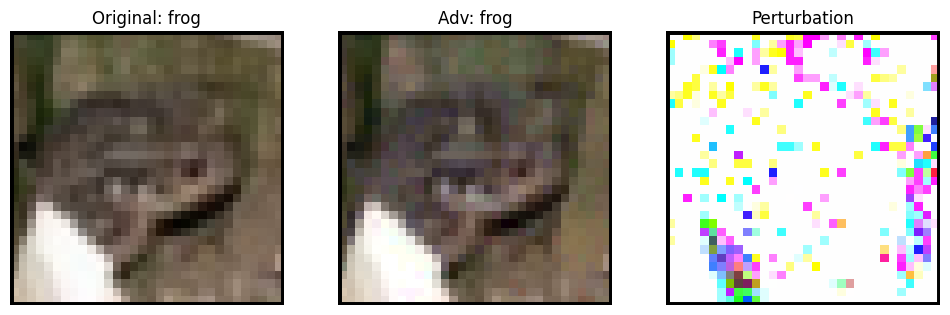

Sample 44/100
Early stopping at iter 1: ensemble misclassification!


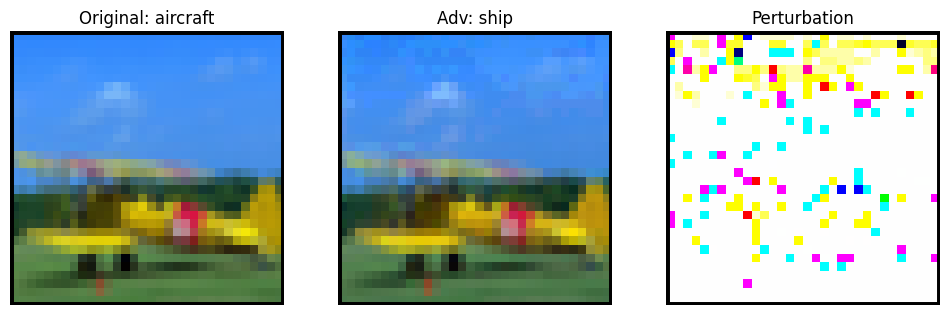

Sample 45/100


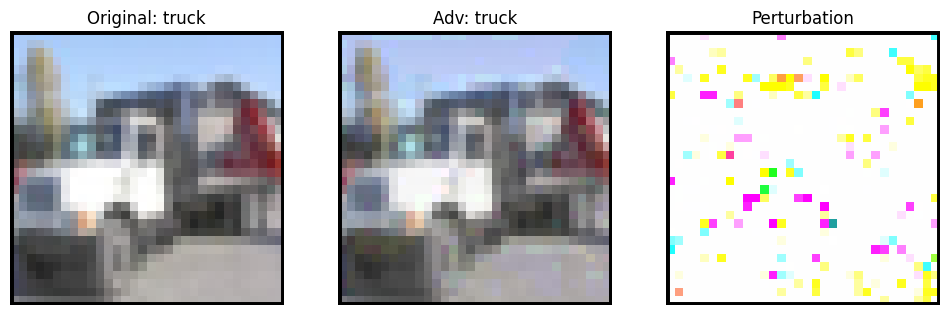

Sample 46/100


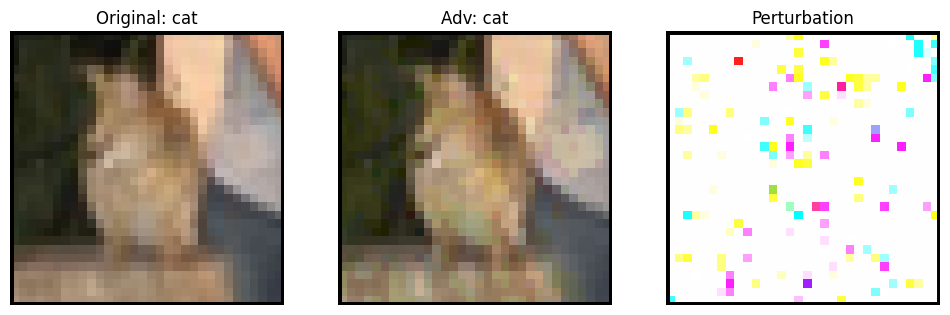

Sample 47/100
Early stopping at iter 0: ensemble misclassification!


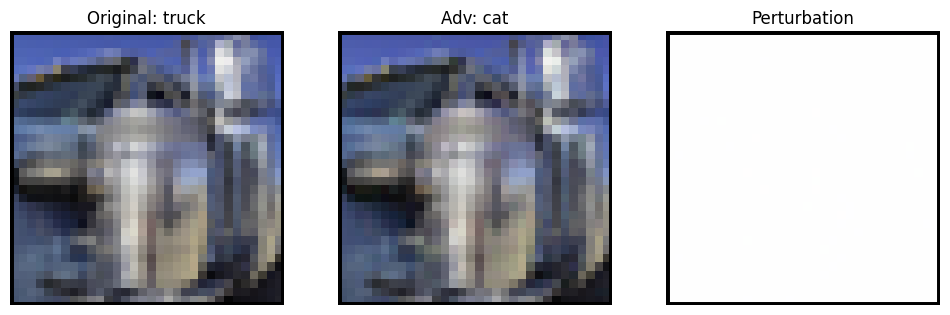

Sample 48/100
Early stopping at iter 0: ensemble misclassification!


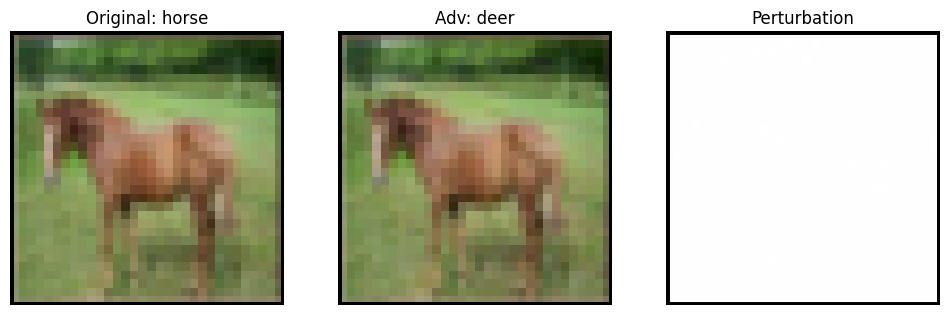

Sample 49/100
Early stopping at iter 0: ensemble misclassification!


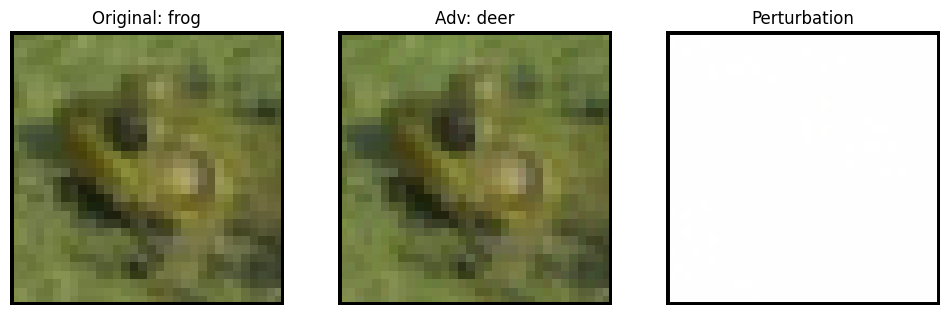

Sample 50/100


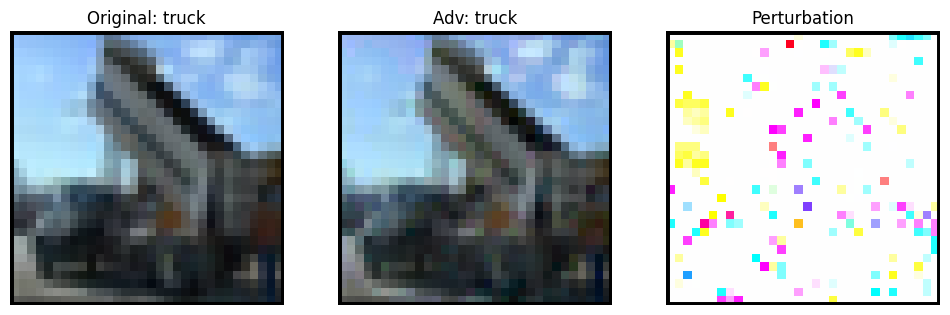

Sample 51/100


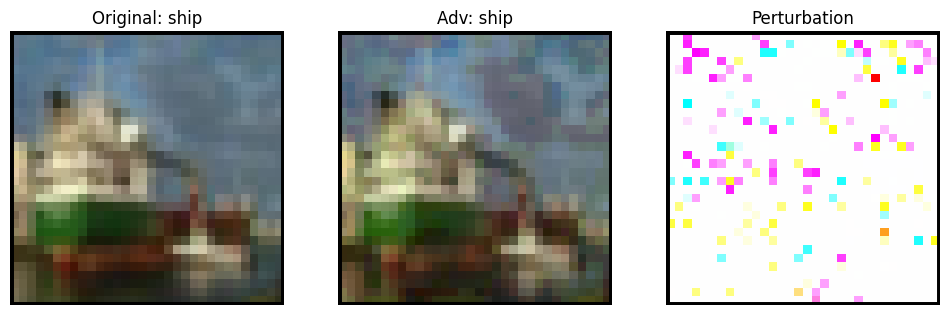

Sample 52/100
skipped element because y_pred=6 and y_true=tensor([0])
Sample 53/100
Early stopping at iter 1: ensemble misclassification!


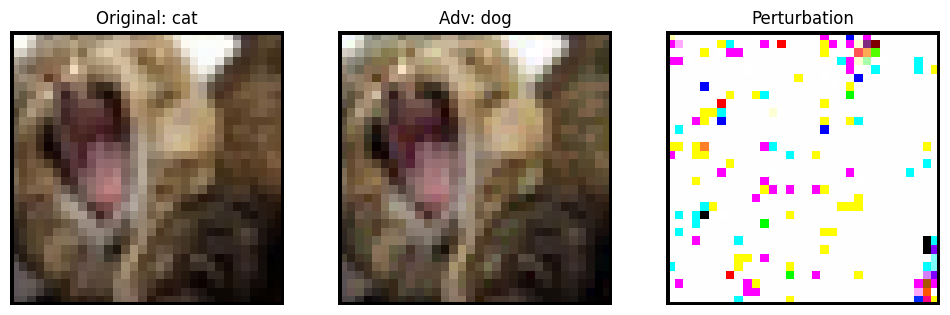

Sample 54/100


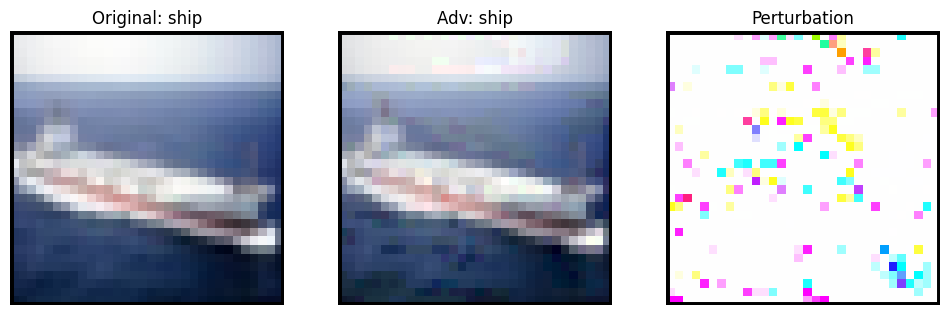

Sample 55/100


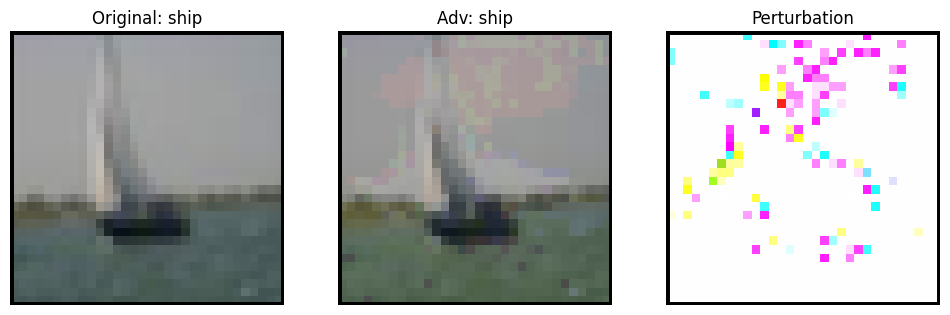

Sample 56/100
Early stopping at iter 0: ensemble misclassification!


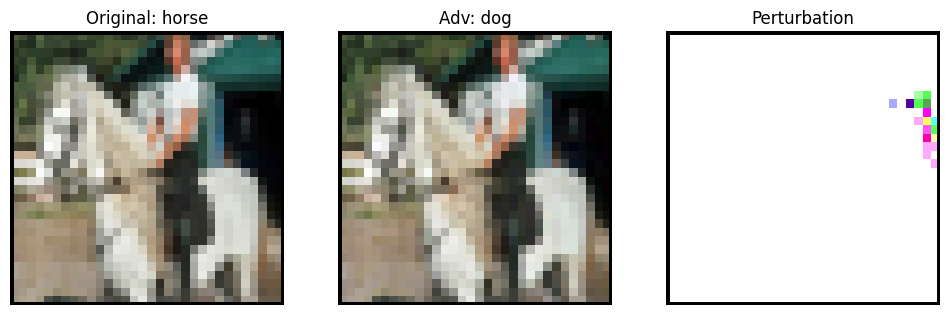

Sample 57/100
Early stopping at iter 0: ensemble misclassification!


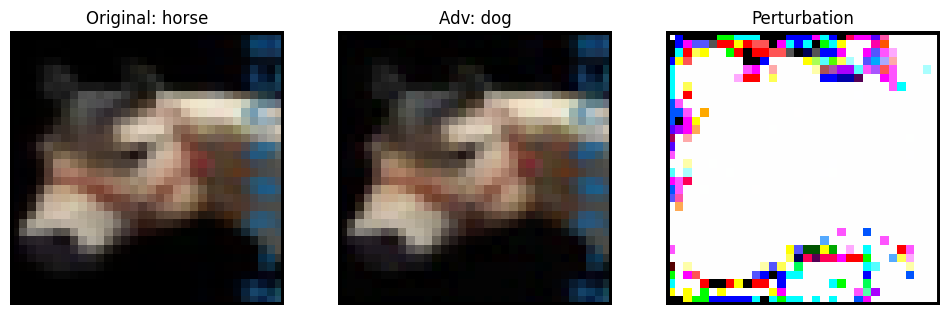

Sample 58/100
skipped element because y_pred=3 and y_true=tensor([4])
Sample 59/100
skipped element because y_pred=4 and y_true=tensor([6])
Sample 60/100


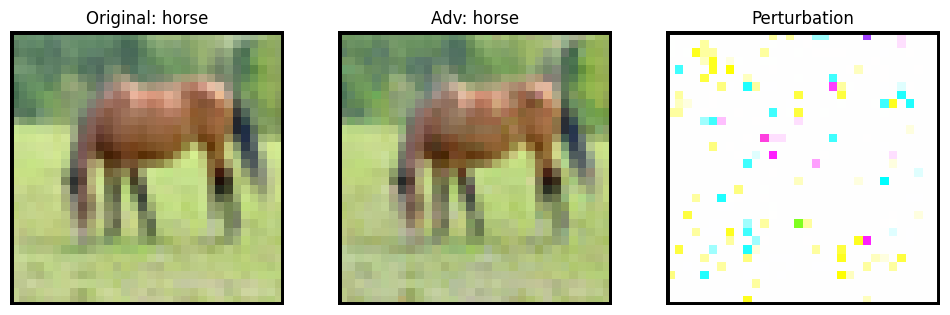

Sample 61/100
Early stopping at iter 1: ensemble misclassification!


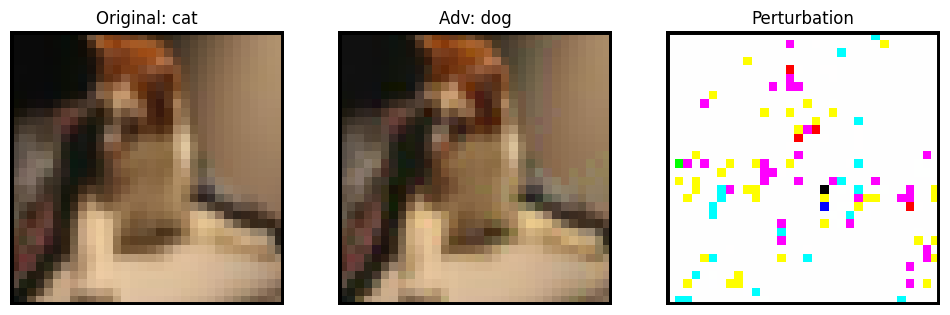

Sample 62/100


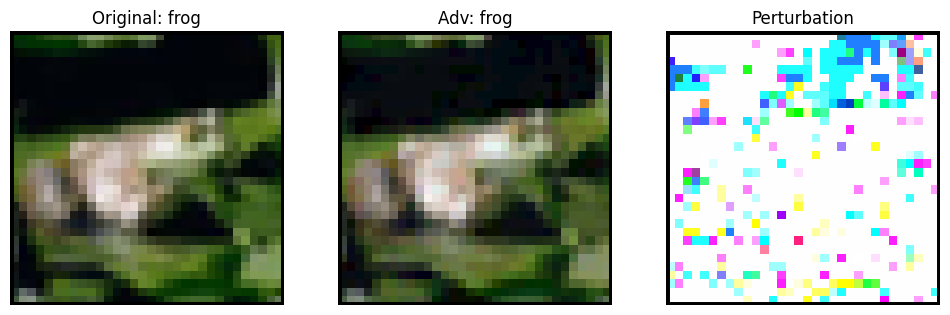

Sample 63/100
skipped element because y_pred=9 and y_true=tensor([3])
Sample 64/100


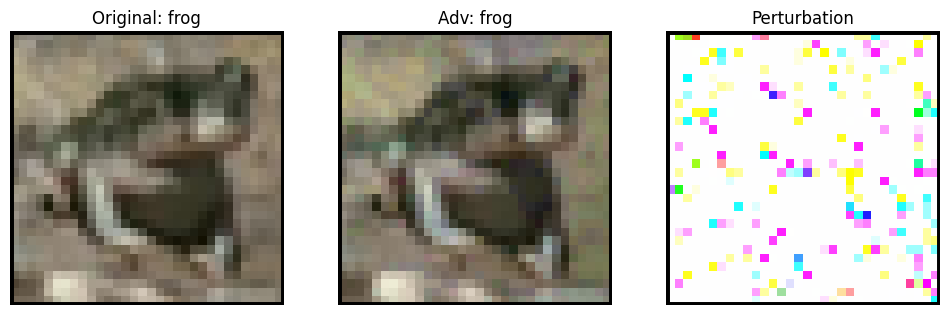

Sample 65/100
skipped element because y_pred=6 and y_true=tensor([2])
Sample 66/100


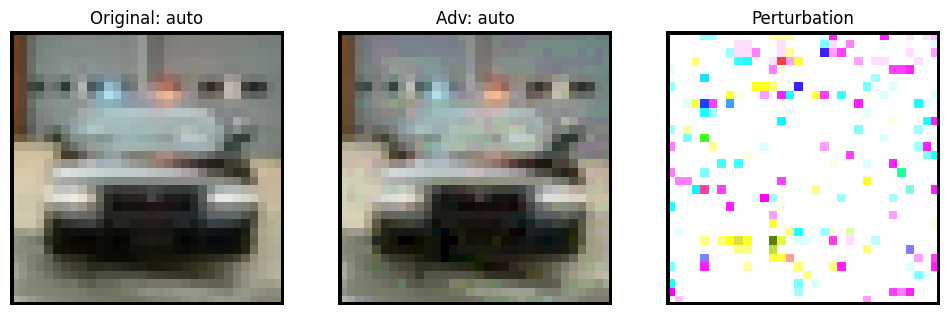

Sample 67/100


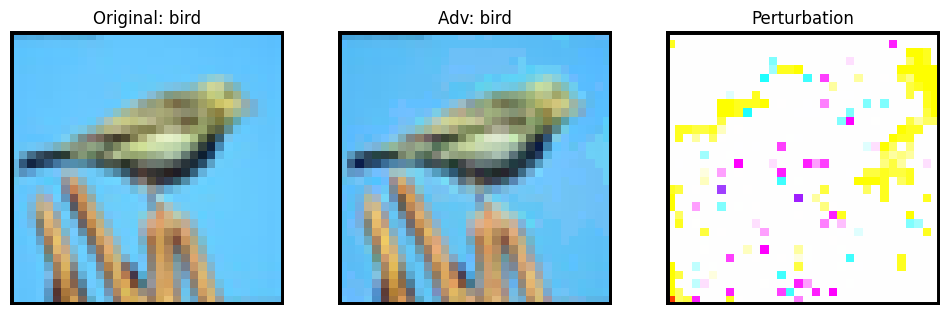

Sample 68/100


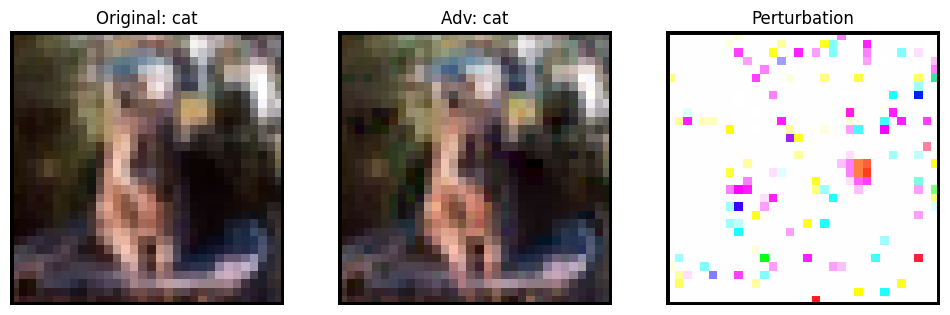

Sample 69/100
Early stopping at iter 0: ensemble misclassification!


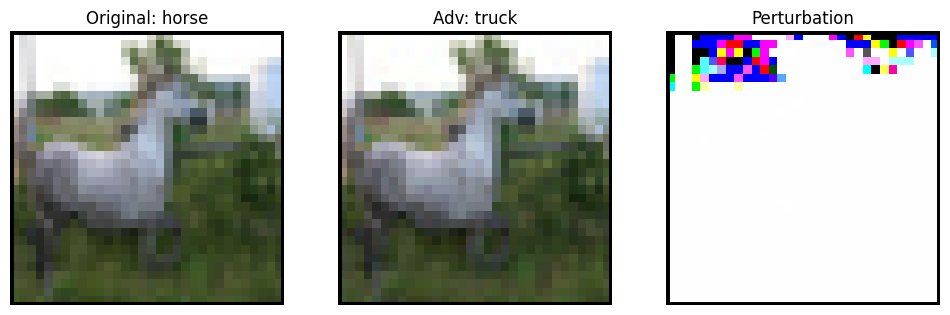

Sample 70/100
Early stopping at iter 0: ensemble misclassification!


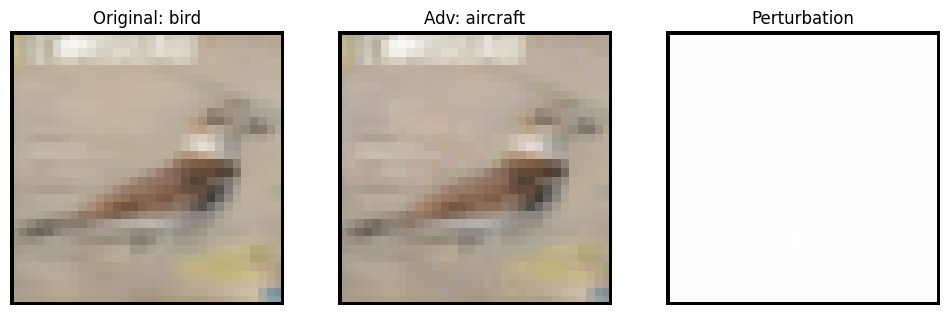

Sample 71/100
Early stopping at iter 2: ensemble misclassification!


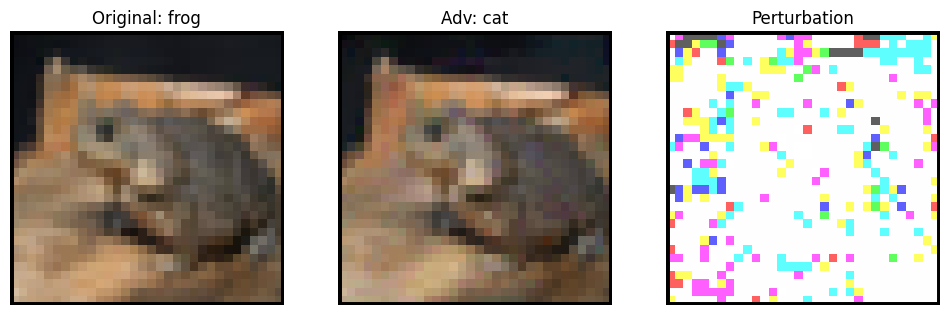

Sample 72/100


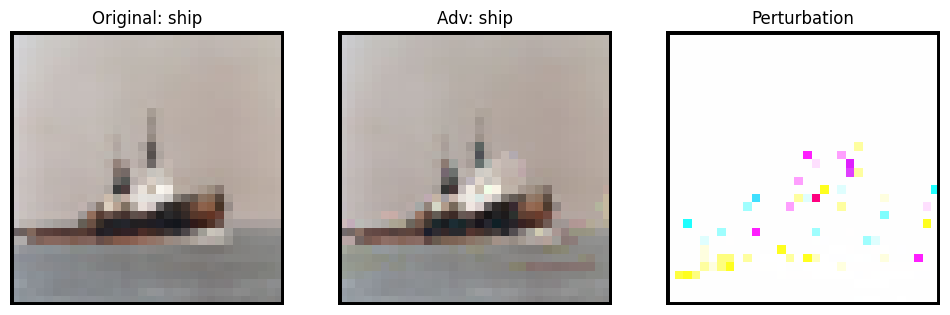

Sample 73/100


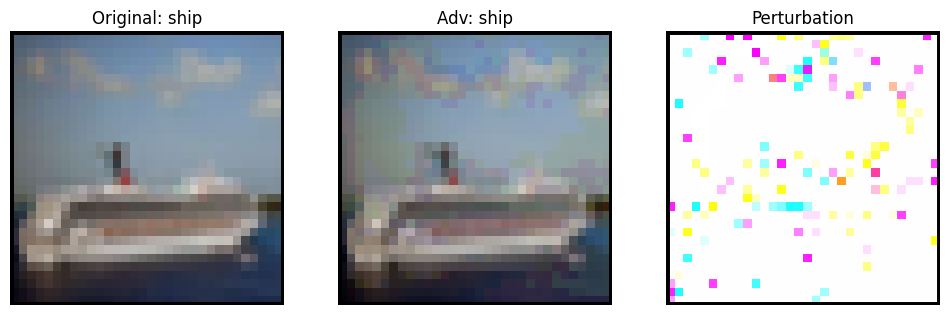

Sample 74/100
Early stopping at iter 1: ensemble misclassification!


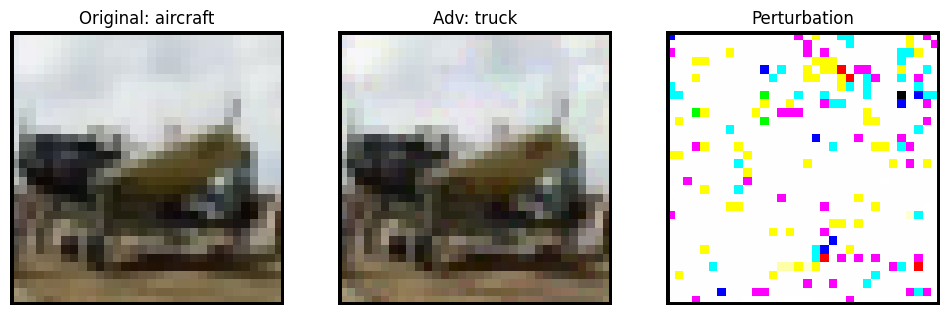

Sample 75/100


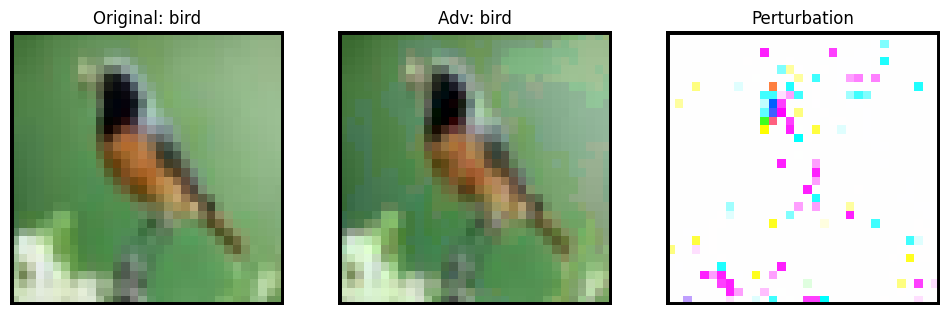

Sample 76/100


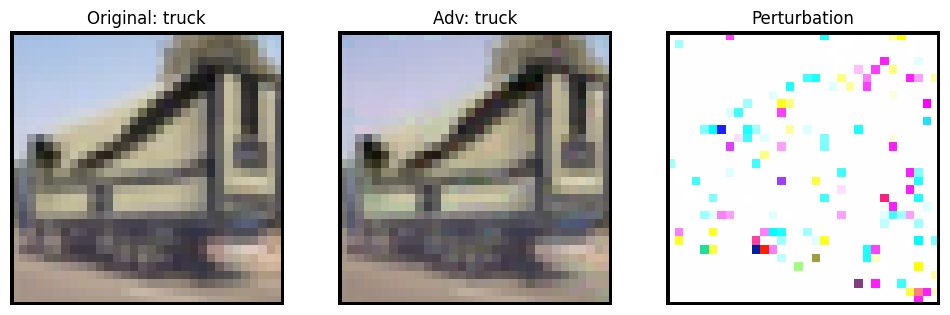

Sample 77/100
Early stopping at iter 0: ensemble misclassification!


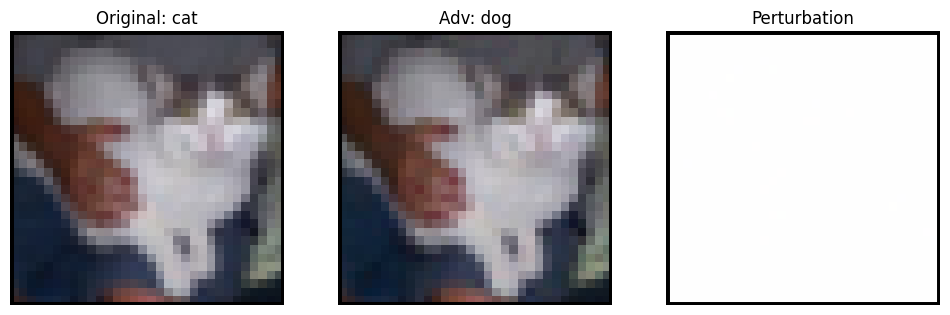

Sample 78/100


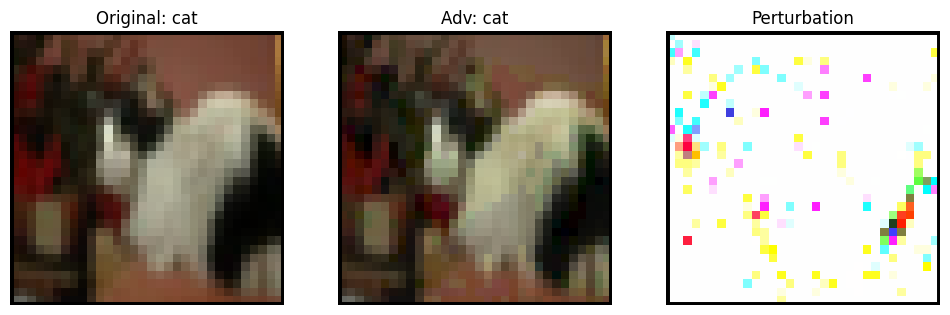

Sample 79/100


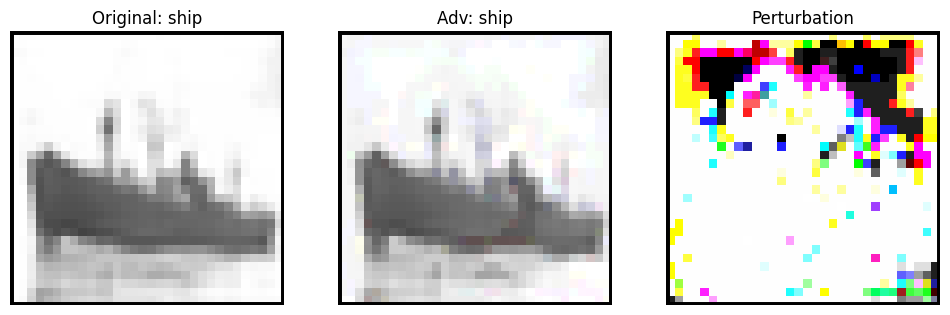

Sample 80/100


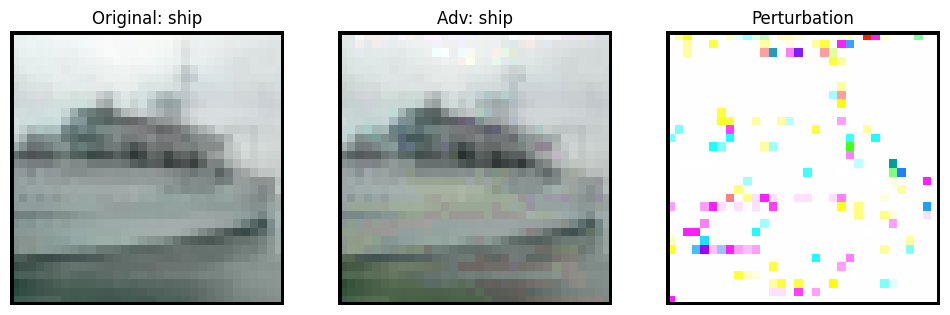

Sample 81/100


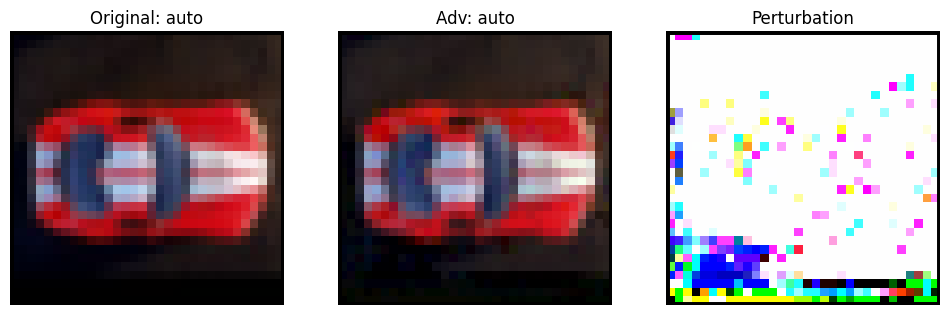

Sample 82/100


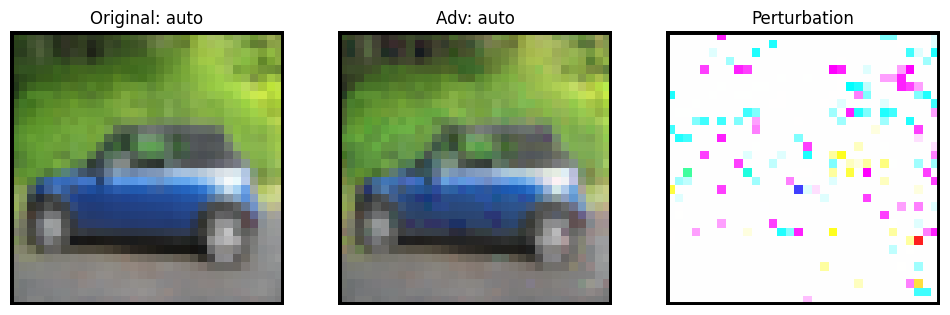

Sample 83/100


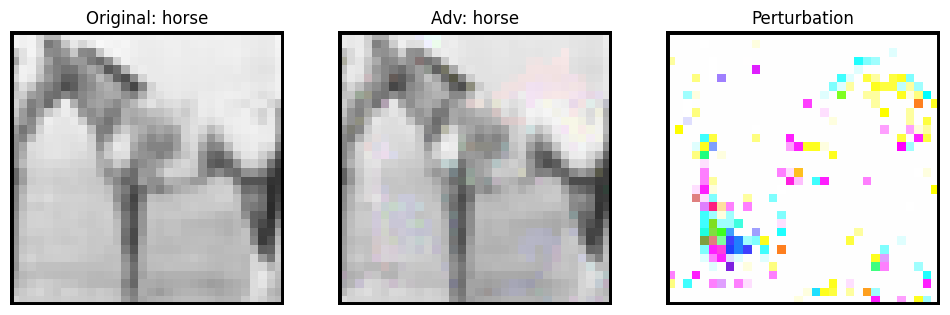

Sample 84/100


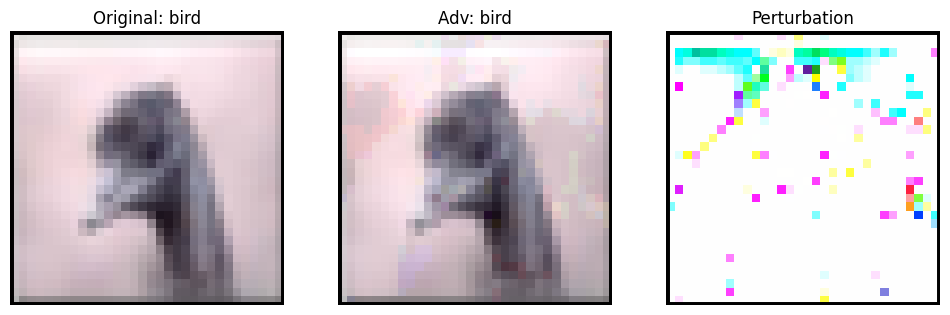

Sample 85/100
skipped element because y_pred=7 and y_true=tensor([5])
Sample 86/100


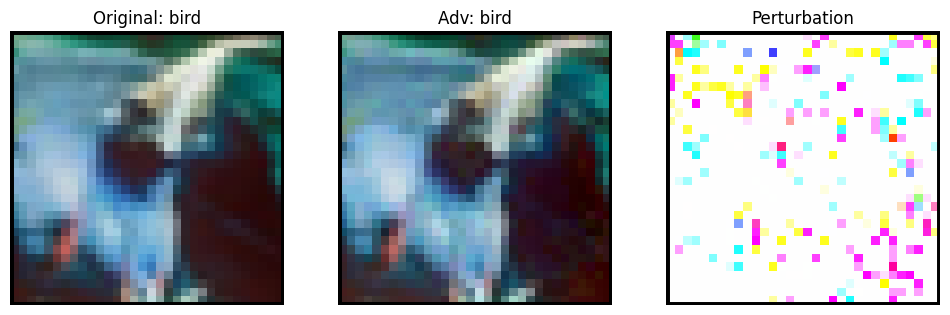

Sample 87/100
skipped element because y_pred=8 and y_true=tensor([7])
Sample 88/100


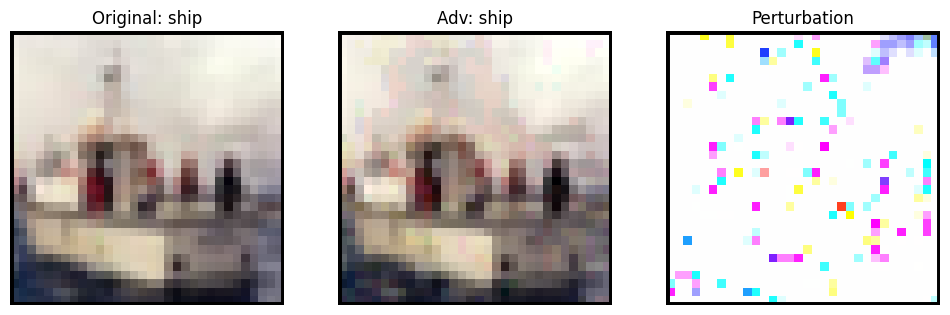

Sample 89/100


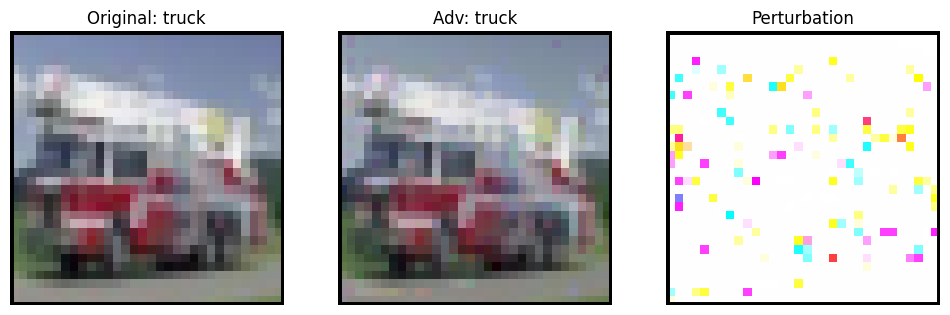

Sample 90/100


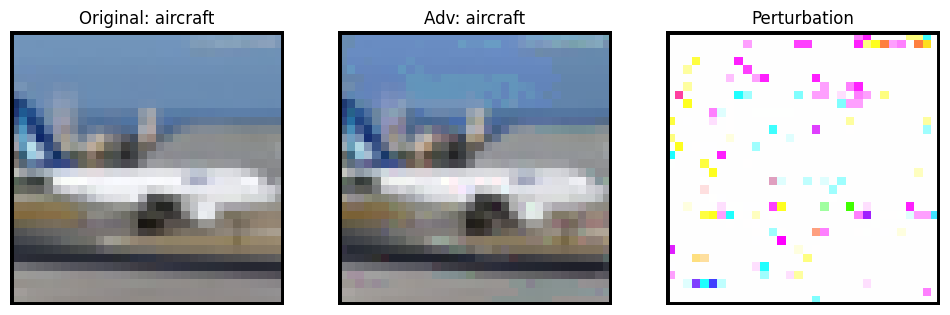

Sample 91/100
skipped element because y_pred=4 and y_true=tensor([3])
Sample 92/100


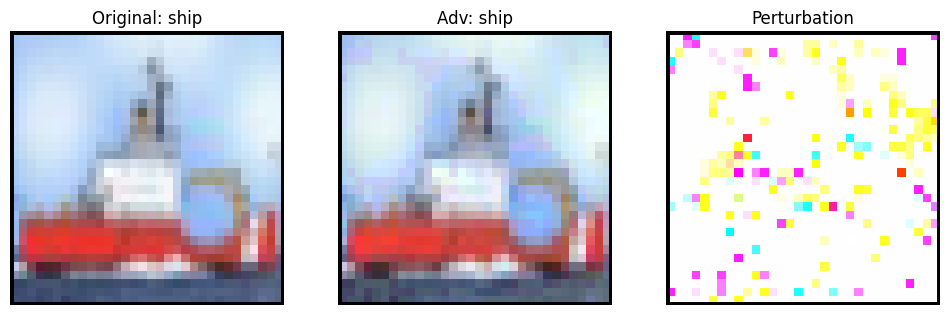

Sample 93/100


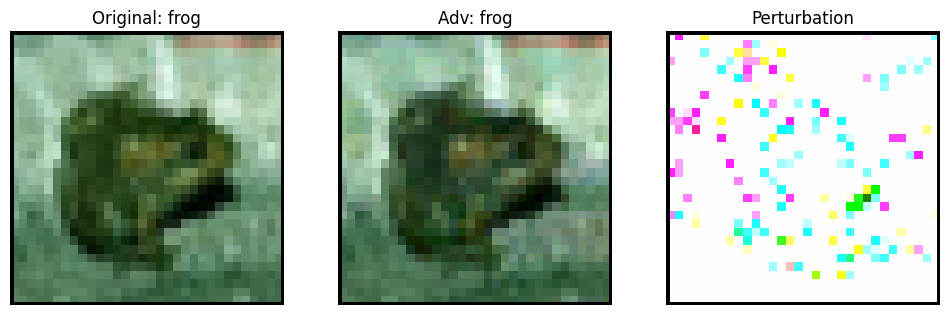

Sample 94/100


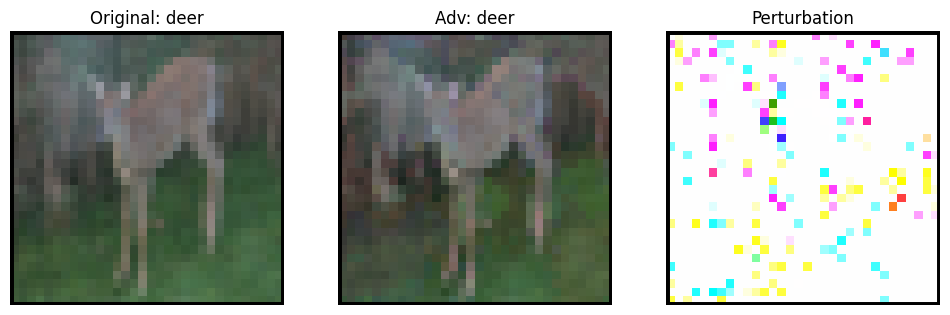

Sample 95/100
Early stopping at iter 2: ensemble misclassification!


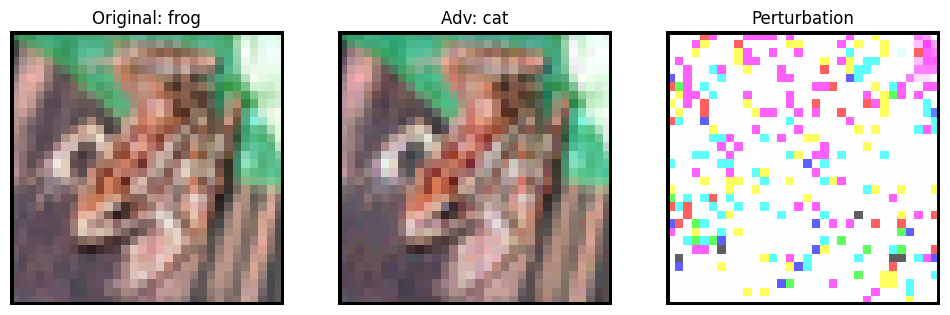

Sample 96/100


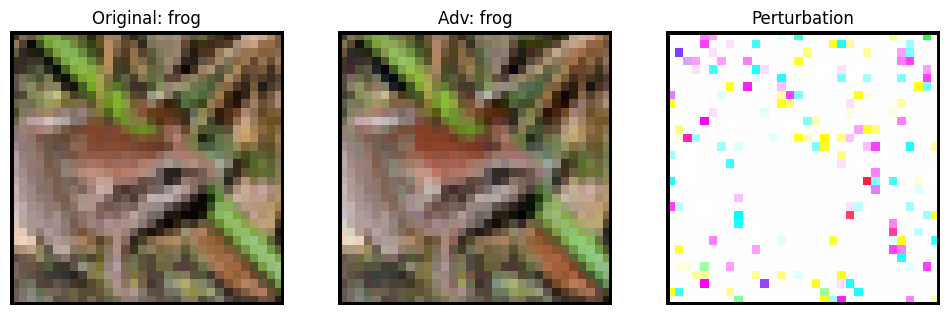

Sample 97/100


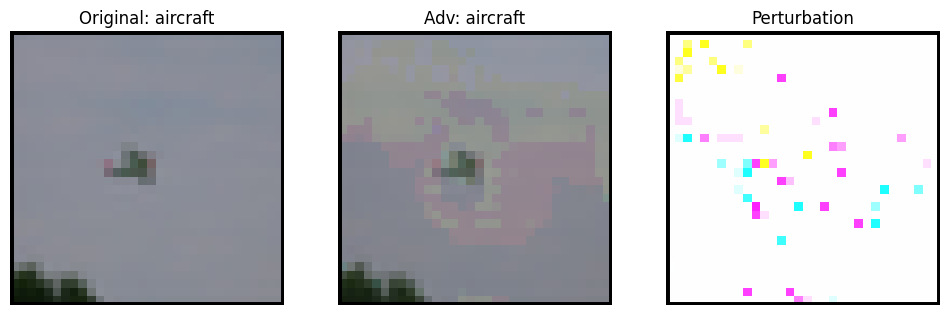

Sample 98/100


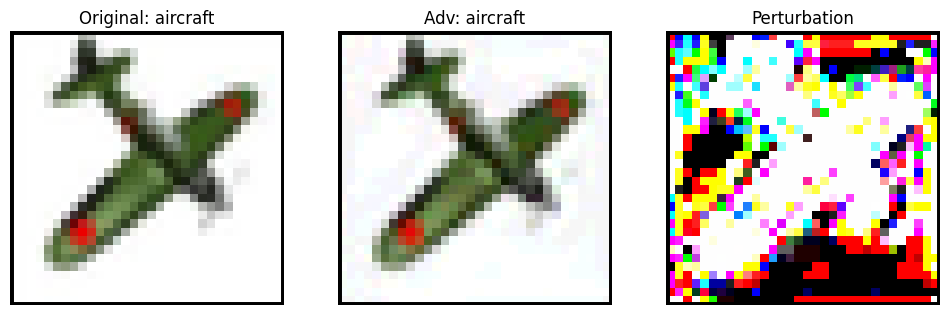

Sample 99/100


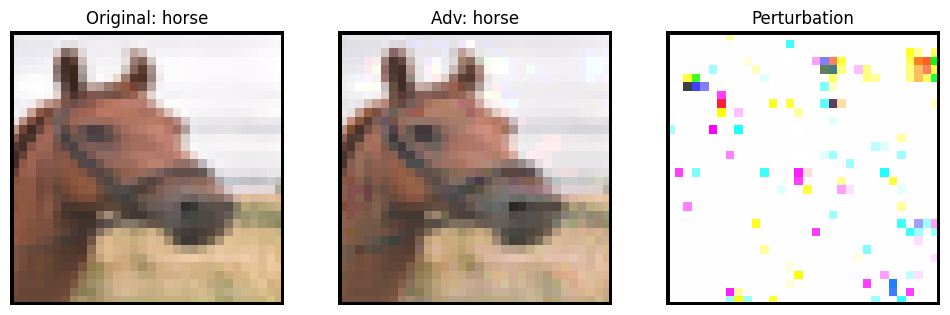

FINISHED. Computed n.24 adversarial examples, skipped n.13 samples


In [ ]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from robustbench.utils import load_model
from torch.utils.data import DataLoader, Subset
import torch.nn.functional as F
from collections import defaultdict

DEBUG = 0
SEED = 42
NUM_SAMPLES = 100
CIFAR10_CLASSES = ['aircraft', 'auto', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']

def optimize_against_ensemble():
    # Set common seed for reproducibility
    set_seed(SEED)

    # Load models from RobustBench
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    models = [
        load_model(model_name='Sehwag2021Proxy_R18', dataset='cifar10', threat_model='Linf').to(device).eval(),
        load_model(model_name='Addepalli2022Efficient_RN18', dataset='cifar10', threat_model='Linf').to(device).eval(),
        load_model(model_name='Addepalli2021Towards_RN18', dataset='cifar10', threat_model='Linf').to(device).eval()
    ]

    # Load cifar 10
    transform = transforms.Compose([transforms.ToTensor()])
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    # Take the first NUM_SAMPLES samples (For the presentation, we included 100 samples)
    subset = Subset(testset, range(NUM_SAMPLES))
    testloader = DataLoader(subset, batch_size=1)

    # Prepare the implemented attack
    attacks = [
        fgsm_ensemble,
        pgd_ensemble,
        mi_fgsm_ensemble
    ]

    # The dictionary `res_adv_images` will use the attack name as the key,
    # and as the value, it will store a list of tuples in the form (adversarial image, true label).
    # This dictionary will be useful in the next section, where we will transfer
    # our adversarial examples to seven other models from RobustBench.
    res_adv_images = defaultdict(list)

    for attack in attacks:
        # Variables useful for attack's statistics
        total_adv_examples = 0
        skipped_elements = 0

        # Compute the attack for each sample in the dataset (limited to NUM_SAMPLES)
        for i, (x, y_true) in enumerate(testloader):
            print(f'Sample {i}/{NUM_SAMPLES}')
            x, y_true = x.to(device), y_true.to(device)

            # Check ensemble prediction: consider optimizabile only those samples
            # for which the ensemble predicts the correct label
            y_pred, _ = ensemble_predict(models, x)

            if y_pred != y_true: # Skip if the ensemble made an error
                print(f'skipped element because y_pred={y_pred} and y_true={y_true}')
                skipped_elements += 1
                continue

            # Optimize the adversarial example using the current attack
            x_adv, y_pred_adv = attack(models, x, y_true, epsilon=8/255)

            # Check whether the ensemble has predicted wrongly the sample.
            # If this check is positive, then save the adversarial image
            if y_pred_adv != y_true:
                res_adv_images[attack.__name__].append((x_adv, y_true.item()))
                total_adv_examples += 1

            # Finally, plot the image regardless of whether it is adversarial or not
            plot_original_adv_images(x, x_adv, y_pred, y_pred_adv)

        print(f'FINISHED. Computed n.{total_adv_examples} adversarial examples, skipped n.{skipped_elements} samples')

    return res_adv_images

res_adv_images = optimize_against_ensemble()

# Transferability Evaluation

In this section, we take the results from the previous blocks and transfer the adversarial examples against the other models.

In [ ]:
import os
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image
from robustbench.utils import download_gdrive, load_model
from collections import defaultdict


def inference(model, image, device):
    model.eval()
    predictions = []

    with torch.no_grad():
        image = image.to(device)
        outputs = model(image)
        preds = torch.argmax(outputs, 1)
        predictions.extend(preds.cpu().numpy())

    return predictions

def transferability_test(res_adv_images):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Take 7 models from RobustBench
    models = [
        load_model(model_name='Standard', dataset='cifar10', threat_model='Linf').to(device).eval(),
        load_model(model_name='Bartoldson2024Adversarial_WRN-94-16', dataset='cifar10', threat_model='Linf').to(device).eval(),
        load_model(model_name='Amini2024MeanSparse_S-WRN-94-16', dataset='cifar10', threat_model='Linf').to(device).eval(),
        load_model(model_name='Bartoldson2024Adversarial_WRN-82-8', dataset='cifar10', threat_model='Linf').to(device).eval(),
        load_model(model_name='Debenedetti2022Light_XCiT-M12', dataset='cifar10', threat_model='Linf').to(device).eval(),
        load_model(model_name='Debenedetti2022Light_XCiT-S12', dataset='cifar10', threat_model='Linf').to(device).eval(),
        load_model(model_name='Rebuffi2021Fixing_70_16_cutmix_ddpm', dataset='cifar10', threat_model='Linf').to(device).eval(),
    ]

    # Similarly to the res_adv_images dictionary, the new transfer_success_rates
    # dictionary will have as keys the name of the attack, and as values the
    # transfer success rate for each model attacked
    transfer_success_rates = defaultdict(list)

    for attack, images in res_adv_images.items():
        print(f'>>>>>>> Attack: {attack} - num_images = {len(images)}')
        for model in models:
            transfer_success = 0

            # Iterate over each adversarial image for the current attack
            for image, y_true in images:
                model = model.to(device)
                pred = inference(model, image, device)

                # Add a success only whether the predicted label by the model
                # is misclassified (so the attack was successfully transferred!)
                transfer_success += int(pred[0] != y_true)

            print(f'Model {model.__class__.__name__} - Transfer success = {transfer_success}')
            transfer_success_rates[attack].append((model.__class__.__name__, transfer_success / len(images)))

    return transfer_success_rates

# tsr = transfer_success_rates
tsr = transferability_test(res_adv_images)
print(tsr)

>>>>>>> Attack: fgsm_ensemble - num_images = 16
Model WideResNet - Transfer success = 5
Model DMWideResNet - Transfer success = 2
Model MeanSparse_DMWideResNet - Transfer success = 2
Model DMWideResNet - Transfer success = 3
Model Sequential - Transfer success = 9
Model Sequential - Transfer success = 11
Model DMWideResNet - Transfer success = 11
>>>>>>> Attack: pgd_ensemble - num_images = 19
Model WideResNet - Transfer success = 4
Model DMWideResNet - Transfer success = 4
Model MeanSparse_DMWideResNet - Transfer success = 4
Model DMWideResNet - Transfer success = 2
Model Sequential - Transfer success = 5
Model Sequential - Transfer success = 6
Model DMWideResNet - Transfer success = 5
>>>>>>> Attack: mi_fgsm_ensemble - num_images = 24
Model WideResNet - Transfer success = 4
Model DMWideResNet - Transfer success = 5
Model MeanSparse_DMWideResNet - Transfer success = 4
Model DMWideResNet - Transfer success = 5
Model Sequential - Transfer success = 8
Model Sequential - Transfer success =